In [3]:
import os
import glob
import pickle 

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.colors
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

# Catalog of Galaxies

In [4]:
# Apparent V Magnitudes from McConnachie et al. (2012), except Crater II, from Torrealba et al. (2016)
# and Leo P, from Kristen et al. (2015)

galaxies_VI_path = os.path.join('Periods', 'galaxies_VI.txt')

galaxies_VI_names = ['Galaxy Name', 'Apparent V Magnitude', 'Error in Magnitude', 'V Band Extinction']

galaxies_VI_table = pd.read_csv(galaxies_VI_path, sep = ',', header = None, names = galaxies_VI_names, engine = 'python')
galaxies_VI_table = galaxies_VI_table.sort_values('Galaxy Name')

galaxies_VI_table.info()
display(galaxies_VI_table)
galaxies_VI_table.to_csv('Monte Carlo/galaxies_VI.csv')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30 entries, 0 to 29
Data columns (total 4 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Galaxy Name           30 non-null     object 
 1   Apparent V Magnitude  30 non-null     float64
 2   Error in Magnitude    30 non-null     float64
 3   V Band Extinction     30 non-null     float64
dtypes: float64(3), object(1)
memory usage: 1.2+ KB


,Galaxy Name,Apparent V Magnitude,Error in Magnitude,V Band Extinction
0,Andromeda I,12.70,0.10,0.145
1,Andromeda II,11.70,0.20,0.167
2,Andromeda III,14.40,0.30,0.152
3,Andromeda XI,17.50,1.20,0.219
4,Andromeda XIII,18.10,1.20,0.226
5,Andromeda XV,14.60,0.30,0.128
6,Andromeda XVI,14.40,0.30,0.182
7,Andromeda XXVIII,15.60,0.90,0.247
8,Bootes I,12.80,0.20,0.047
9,Carina I,11.00,0.50,0.169


In [5]:
galaxies_BV_path = os.path.join('Periods', 'galaxies_BV.txt')

galaxies_BV_names = ['Galaxy Name', 'Apparent V Magnitude', 'Error in Magnitude', 'V Band Extinction']

galaxies_BV_table = pd.read_csv(galaxies_BV_path, sep = ',', header = None, names = galaxies_BV_names, engine = 'python')
galaxies_BV_table = galaxies_BV_table.sort_values('Galaxy Name')

galaxies_BV_table.info()
display(galaxies_BV_table)
galaxies_BV_table.to_csv('Monte Carlo/galaxies_BV.csv')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8 entries, 0 to 7
Data columns (total 4 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Galaxy Name           8 non-null      object 
 1   Apparent V Magnitude  8 non-null      float64
 2   Error in Magnitude    8 non-null      float64
 3   V Band Extinction     8 non-null      float64
dtypes: float64(3), object(1)
memory usage: 320.0+ bytes


,Galaxy Name,Apparent V Magnitude,Error in Magnitude,V Band Extinction
0,Canes Venatici I,13.10,0.2,0.043
1,Canes Venatici II,16.10,0.5,0.027
2,Hercules,14.00,0.3,0.171
3,Leo IV,15.10,0.4,0.069
4,Sagittarius II,13.83,0.1,0.302
5,Segue II,15.20,0.3,0.507
6,Ursa Major I,14.40,0.3,0.054
7,Ursa Major II,13.30,0.5,0.257


In [6]:
n_rrls = [296, 251, 111, 15, 9, 117, 8, 85, 15, 23, 2, 83, 3, 172, 2, 34, 267, 232, 268, 1443, 2, 12, 
          90, 10, 164, 3, 10, 1, 177, 820, 121, 1, 5, 536, 1, 358, 7, 1]
paper_filters = ['F475W, F814W', 'F475W, F814W', 'F475W, F814W', 'F606W, F814W', 'F606W, F814W',
                 'F475W, F814W', 'F475W, F814W', 'F475W, F814W', 'V, I', 'BVI', 'BVI', 'UBVI', 
                 'gri', 'F475W, F814W', 'BVI', 'BVI', 'V, I', 'F606W, F814W', 'F606W, F814W', 'ugriz', 'gri', 'B, V', 
                 'F475W, F814W', 'F475W, F814W', 'UBVRI', 'BVI', 'F475W, F814W', 'F606W, F814W', 'F606W, F814W', 
                 'F606W, F814W', 'F555W, F814W', 'gri', 'B, V', 'BVRI', 'B, V', 'F475W, F814W', 'B, V', 'BVI']
sources = ['Martinez-Vasquez et al. (2017)', 'Martinez-Vasquez et al. (2017)', 'Martinez-Vasquez et al. (2017)', 
           'Yang and Sarajedini (2012)', 'Yang and Sarajedini (2012)', 'Martinez-Vasquez et al. (2017)', 
           'Monelli et al. (2016)', 'Martinez-Vasquez et al. (2017)', 'Dall\'Ora et al. (2006)', 
           'Kuehn et al. (2008)', 'Greco et al. (2008)', 'Coppola et al. (2015)', 'Torrealba et al. (2018)', 
           'Bernard et al. (2009)', 'Musella et al. (2009)', 'Monelli et al. (2018)', 'Kinemuchi et al. (2008)', 
           'Yang et al. (2014)', 'Yang et al. (2014)', 'Stringer et al. (2020)', 'Martinez-Vasquez et al. (2019)', 
           'Musella et al. (2012)', 'Bernard et al. (2010)', 'Bernard et al. (2013)', 'Stetson et al. (2014)', 
           'Moretti et al. (2009)', 'McQuinn et al. (2015)', 'Clementini et al. (2012)', 'Monelli et al. (2017)', 
           'Monelli et al. (2017)', 'Ordonez et al. (2014)',  'Martinez-Vasquez et al. (2019)', 
           'Joo et al. (2019)', 'Martinez-Vasquez et al. (2016)', 'Boettcher et al. (2013)', 'Bernard et al. (2009)', 
           'Garofalo et al. (2013)', 'Dall\'Ora et al. (2012)']
transformed = ['V, I', 'V, I', 'V, I', 'V, I', 'V, I', 'V, I', 'V, I', 'V, I', 'V, I', 'B, V', 'B, V', 'V, I', 'V, I', 
               'V, I', 'V, I', 'V, I', 'V, I', 'V, I', 'V, I', 'V, I', 'V, I', 'B, V', 'V, I', 'V, I', 'V, I', 'B, V', 
               'V, I', 'V, I', 'V, I', 'V, I', 'V, I', 'V, I', 'B, V', 'V, I', 'B, V', 'V, I', 'B, V', 'B, V']

summary = pd.concat([galaxies_VI_table, galaxies_BV_table], ignore_index = True).sort_values('Galaxy Name')
summary['Apparent V Magnitude'] = (summary['Apparent V Magnitude'].astype('str') + r' $\pm$ ' 
                                   + summary['Error in Magnitude'].astype('str'))
summary = summary.drop('Error in Magnitude', axis = 1)
summary['Number of RRL'] = n_rrls
summary['Observed Filters'] = paper_filters
summary['Transformed Filters'] = transformed
summary['References'] = sources
summary = summary.reset_index().drop('index', axis = 1)
display(summary)

,Galaxy Name,Apparent V Magnitude,V Band Extinction,Number of RRL,Observed Filters,Transformed Filters,References
0,Andromeda I,12.7 $\pm$ 0.1,0.145,296,"F475W, F814W","V, I",Martinez-Vasquez et al. (2017)
1,Andromeda II,11.7 $\pm$ 0.2,0.167,251,"F475W, F814W","V, I",Martinez-Vasquez et al. (2017)
2,Andromeda III,14.4 $\pm$ 0.3,0.152,111,"F475W, F814W","V, I",Martinez-Vasquez et al. (2017)
3,Andromeda XI,17.5 $\pm$ 1.2,0.219,15,"F606W, F814W","V, I",Yang and Sarajedini (2012)
4,Andromeda XIII,18.1 $\pm$ 1.2,0.226,9,"F606W, F814W","V, I",Yang and Sarajedini (2012)
5,Andromeda XV,14.6 $\pm$ 0.3,0.128,117,"F475W, F814W","V, I",Martinez-Vasquez et al. (2017)
6,Andromeda XVI,14.4 $\pm$ 0.3,0.182,8,"F475W, F814W","V, I",Monelli et al. (2016)
7,Andromeda XXVIII,15.6 $\pm$ 0.9,0.247,85,"F475W, F814W","V, I",Martinez-Vasquez et al. (2017)
8,Bootes I,12.8 $\pm$ 0.2,0.047,15,"V, I","V, I",Dall'Ora et al. (2006)
9,Canes Venatici I,13.1 $\pm$ 0.2,0.043,23,BVI,"B, V",Kuehn et al. (2008)


# Filter Transformations

In [7]:
def des_to_sdss(g, r, i, z):
    """Computes g - i color in SDSS bands from mean g, r, i, and z magnitudes in DES bands."""
    g_minus_r = (1 / 0.998) * ((g - r) + 0.01)
    i_minus_z = (1 / 0.830) * ((i - z) - 0.01)
    g_minus_i = (g - i) + 0.104 * g_minus_r - 0.256 * i_minus_z + 0.01
    return g_minus_i

def sdss_to_johnson(color):
    """Converts g - i color to V - I color."""
    if color <= 2.1:
        return 0.674 * color + 0.406
    else:
        return 0.674 * color
    
def des_transform(g, r, i, z):
    """Computes V - I color from DES photometric data."""
    return sdss_to_johnson(des_to_sdss(g, r, i, z))    

def calc_wesenheit_des(g, r, i, z):
    """Computes V - I Wesenheit magnitude from DES photometric data."""
    color = des_transform(g, r, i, z)
    g_minus_r = (1 / 0.998) * ((g - r) + 0.01)
    sdss_g = g + 0.104 * g_minus_r - 0.01
    V_minus_g = -0.569 * g_minus_r + 0.021
    johnson_I = (V_minus_g + sdss_g) - color
    return [V_minus_g + sdss_g, johnson_I - 1.467 * color]

def hubble_to_johnson(f606w, f814w):
    """Computes V - I color from Hubble photometric data."""
    color = f606w - f814w
    return (1 / 0.812) * (color + 0.930)

def calc_wesenheit_hubble(f606w, f814w):
    """Computes V - I Wesenheit magnitude from Hubble photometric data."""
    f606w = f606w - 26.168
    f814w = f814w - 25.501
    color = hubble_to_johnson(f606w, f814w)
    johnson_V = f606w + 26.410 + 0.212 * color
    johnson_I = f814w + 25.480 + 0.024 * color
    return [johnson_V, johnson_I - 1.467 * color]

def convergence(mag_1, mag_2, corr_1, corr_2, c0_1, c0_2, c1_1, c1_2, a, b = False):
    """Computes Wesenheit magnitude from Hubble photometric data."""
    mag_1 = mag_1 - corr_1
    mag_2 = mag_2 - corr_2
    initial_color = mag_1 - mag_2
    guess_1 = mag_1 + c0_1 + c1_1 * initial_color
    guess_2 = mag_2 + c0_2 + c1_2 * initial_color
    new_color = guess_1 - guess_2
    while abs(new_color - initial_color) > 0.001:
        guess_1 = mag_1 + c0_1 + c1_1 * initial_color
        guess_2 = mag_2 + c0_2 + c1_2 * initial_color
        initial_color = new_color
        new_color = guess_1 - guess_2
    guess_1 = mag_1 + c0_1 + c1_1 * initial_color
    guess_2 = mag_2 + c0_2 + c1_2 * initial_color
    if not b:
        target = guess_1
    else:
        target = guess_2
    return [target, guess_2 - a * new_color]

In [8]:
mean_v_rrl = []

def convert_table(file, galaxy, columns, usecols = None, convert = '', b = False, z = True, sep = '\s{1,}', impute = False):
    """Convert photometric data to desired format for MCMC model."""
    
    if usecols is not None:
        pulsation = pd.read_csv(file, sep = sep, header = None, names = columns, engine = 'python', usecols = usecols)
    else:
        pulsation = pd.read_csv(file, sep = sep, header = None, names = columns, engine = 'python')

    if convert == 'des':
        for filt in ['g', 'r', 'i']:
                pulsation[f'{filt} Magnitude'] = pulsation[f'{filt} Magnitude'].astype('float64')
        if z:
            pulsation['z Magnitude'] = pulsation['z Magnitude'].astype('float64')
        else:
            mean_z = []
            for index, row in pulsation.iterrows():
                if row['Type'] == 'ab' or row['Type'] == 'RRab':
                    mean_z.append(row['i Magnitude'] - 0.013)
                else:
                    mean_z.append(row['i Magnitude'] + 0.006)
            pulsation['z Magnitude'] = np.array(mean_z)
        wesenheit = []
        v_mags = []
        for index, row in pulsation.iterrows():
            result = calc_wesenheit_des(row['g Magnitude'], row['r Magnitude'], row['i Magnitude'], row['z Magnitude'])
            v_mags.append(result[0])
            wesenheit.append(result[1])
        pulsation['V Magnitude'] = np.array(v_mags)
        pulsation['Wesenheit Magnitude'] = np.array(wesenheit)
         
    elif convert == 'hubble':
        if b:
            v_mags = []
            wesenheit = []
            for index, row in pulsation.iterrows():
                result = convergence(row['F435W Magnitude'], row['F555W Magnitude'], 
                                     25.779, 25.724, 25.853, 25.740, -0.087, -0.081, 3.058, b = True)
                v_mags.append(result[0])
                wesenheit.append(result[1])
            pulsation['V Magnitude'] = np.array(v_mags)
            pulsation['Wesenheit Magnitude'] = np.array(wesenheit)
        else:
            result = calc_wesenheit_hubble(pulsation['F606W Magnitude'], pulsation['F814W Magnitude'])
            pulsation['V Magnitude'] = result[0]
            pulsation['Wesenheit Magnitude'] = result[1]
            
    else:
        if b:
            pulsation['Wesenheit Magnitude'] = (pulsation['V Magnitude'] - 3.058 * 
                                                (pulsation['B Magnitude'] - pulsation['V Magnitude']))
        else:
            pulsation['Wesenheit Magnitude'] = (pulsation['I Magnitude'] - 1.467 * 
                                                (pulsation['V Magnitude'] - pulsation['I Magnitude']))
        
    
    lin_reg = pulsation[['Star', 'Type', 'Period (Days)', 'Wesenheit Magnitude', 'V Magnitude']]
    
    if impute:
        lin_reg = lin_reg[lin_reg['Period (Days)'] != '---']
    lin_reg = lin_reg.astype({'Period (Days)' : 'float64'})
    
    lin_reg['Uncertainty in Wesenheit Magnitude'] = 0.03
    lin_reg['Log Period'] = np.log10(lin_reg['Period (Days)'])
    
    graph_tab = lin_reg.rename({'Type' : 'Variable Type'}, axis = 1)
    
    lin_reg = lin_reg[(lin_reg['Type'] == 'ab') | (lin_reg['Type'] == 'RRab')].reset_index().drop(['index', 'Type'], axis = 1)
    
    num_stars = len(lin_reg['Star'].unique())
    lookup = dict(zip(lin_reg['Star'].unique(), range(num_stars)))
    lin_reg['Star Code'] = lin_reg['Star'].replace(lookup).values
    
    mean_v_rrl.append([galaxy, np.mean(lin_reg['V Magnitude'])])
    
    lin_reg = lin_reg[['Star', 'Wesenheit Magnitude', 'Uncertainty in Wesenheit Magnitude', 'Log Period', 'Star Code']]
    lin_reg = lin_reg.reset_index().drop('index', axis = 1)
    
    return graph_tab, lin_reg

In [9]:
def fix_star_code(lin_reg):
    """Fix discrepancies due to the removal of outliers."""
    num_stars = len(lin_reg['Star'].unique())
    lookup = dict(zip(lin_reg['Star'].unique(), range(num_stars)))
    lin_reg['Star Code'] = lin_reg['Star'].replace(lookup).values
    lin_reg = lin_reg.reset_index().drop('index', axis = 1)
    return lin_reg

# Application to Andromeda Satellites

In [10]:
path = 'Andromeda/J_ApJ_850_137'
pulsation_data = glob.glob(os.path.join(path, 'd4*.dat'))

hubble_names = ['Galaxy', 'Star', 'RA (Hour)', 'RA (Minutes)', 'RA (Seconds)', 'Dec (Degrees)', 'Dec (Minutes)', 
                  'Dec (Seconds)', 'Period (Days)', 'Magnitude (F475W)', 'Amplitude (F475W)', 'Magnitude (F814W)', 
                  'Amplitude (F814W)', 'Magnitude (B-Band)', 'Amplitude (B-Band)', 'Magnitude (V-Band)', 'Amplitude (V-Band)', 
                  'Magnitude (Ic-Band)', 'Amplitude (Ic-Band)', 'Variable Type', 'Camera']

hubble_pulsation = pd.concat((pd.read_csv(file, sep = '\s{1,}', header = None, names = hubble_names, engine = 'python') 
                              for file in pulsation_data)).sort_values(by = ['Galaxy', 'Star'])

hubble_pulsation['Star'] = hubble_pulsation['Star'].str.replace('-', '')
hubble_pulsation.head()

,Galaxy,Star,RA (Hour),RA (Minutes),RA (Seconds),Dec (Degrees),Dec (Minutes),Dec (Seconds),Period (Days),Magnitude (F475W),...,Magnitude (F814W),Amplitude (F814W),Magnitude (B-Band),Amplitude (B-Band),Magnitude (V-Band),Amplitude (V-Band),Magnitude (Ic-Band),Amplitude (Ic-Band),Variable Type,Camera
0,AndI,V001,0,45,9.233,37,58,47.19,0.569,25.532,...,24.692,0.574,25.657,1.137,25.266,0.915,24.677,0.580,RRab,WFC3
1,AndI,V002,0,45,9.646,37,59,48.86,0.567,25.505,...,24.737,0.358,25.613,0.669,25.251,0.436,24.719,0.360,RRab,WFC3
2,AndI,V003,0,45,9.819,37,59,32.31,0.296,25.329,...,24.831,0.091,25.398,0.392,25.159,0.207,24.819,0.097,RRc,WFC3
3,AndI,V004,0,45,10.116,37,58,44.43,0.598,25.322,...,24.607,0.699,25.415,1.605,25.103,0.949,24.599,0.669,RRab,WFC3
4,AndI,V005,0,45,10.429,37,58,56.47,0.585,25.557,...,24.733,0.608,25.680,0.864,25.276,0.660,24.722,0.576,RRab,WFC3


In [11]:
hubble_lin_reg = hubble_pulsation[['Galaxy', 'Star', 'Magnitude (B-Band)', 'Magnitude (V-Band)', 'Magnitude (Ic-Band)',
                                   'Variable Type']]

for gal in ['AndI', 'AndII', 'AndIII', 'AndXV', 'AndXXVIII']:
    name = 'Andromeda ' + gal[3:]
    mini_hub = hubble_lin_reg[(hubble_lin_reg['Galaxy'] == gal) & (hubble_lin_reg['Variable Type'] == 'RRab')]
    mean_v_rrl.append([name, np.mean(mini_hub['Magnitude (V-Band)'])])
    
hubble_lin_reg['Wesenheit Magnitude'] = hubble_lin_reg['Magnitude (Ic-Band)'] - 1.467 * (hubble_lin_reg['Magnitude (V-Band)'] - 
                                                                                         hubble_lin_reg['Magnitude (Ic-Band)'])

hubble_lin_reg['Uncertainty in Wesenheit Magnitude'] = 0.03

hubble_lin_reg['Log Period'] = np.log10(hubble_pulsation['Period (Days)'])

hubble_lin_reg = hubble_lin_reg[['Galaxy', 'Star', 'Wesenheit Magnitude', 'Uncertainty in Wesenheit Magnitude',
                                 'Log Period', 'Variable Type']]

hubble_lin_reg = hubble_lin_reg[hubble_lin_reg['Galaxy'] != 'AndXVI']

hubble_lin_reg.head()

,Galaxy,Star,Wesenheit Magnitude,Uncertainty in Wesenheit Magnitude,Log Period,Variable Type
0,AndI,V001,23.812937,0.03,-0.244888,RRab
1,AndI,V002,23.938556,0.03,-0.246417,RRab
2,AndI,V003,24.320220,0.03,-0.528708,RRc
3,AndI,V004,23.859632,0.03,-0.223299,RRab
4,AndI,V005,23.909282,0.03,-0.232844,RRab


In [12]:
and_galaxies = hubble_lin_reg['Galaxy'].unique()
graph_tabs = []

for galaxy in and_galaxies:
    graph_tabs.append(hubble_lin_reg[hubble_lin_reg['Galaxy'] == galaxy])

[and_one_graph_tab, and_two_graph_tab, and_three_graph_tab, and_fifteen_graph_tab, and_twenty_eight_graph_tab] = graph_tabs
print(and_galaxies)

['AndI' 'AndII' 'AndIII' 'AndXV' 'AndXXVIII']


In [13]:
hubble_lin_reg = hubble_lin_reg[hubble_lin_reg['Variable Type'] == 'RRab']
hubble_lin_reg = hubble_lin_reg.drop('Variable Type', axis = 1)

hubble_lin_reg.head()

,Galaxy,Star,Wesenheit Magnitude,Uncertainty in Wesenheit Magnitude,Log Period
0,AndI,V001,23.812937,0.03,-0.244888
1,AndI,V002,23.938556,0.03,-0.246417
3,AndI,V004,23.859632,0.03,-0.223299
4,AndI,V005,23.909282,0.03,-0.232844
7,AndI,V008,23.537866,0.03,-0.101824


In [14]:
def gen_hubble_lin_reg(galaxy, file):
    """Generates linear regression table for an Andromeda satellite."""
    lin_reg = hubble_lin_reg[hubble_lin_reg['Galaxy'] == galaxy].reset_index().drop(['index', 'Galaxy'], axis = 1)
    num_stars = len(lin_reg['Star'].unique())
    lookup = dict(zip(lin_reg['Star'].unique(), range(num_stars)))
    lin_reg['Star Code'] = lin_reg['Star'].replace(lookup).values
    lin_reg.to_csv(f'Monte Carlo/{file}_mcmc.csv', index = False)
    return lin_reg

In [15]:
file_names = ['and_one', 'and_two', 'and_three', 'and_fifteen', 'and_twenty_eight']

for pair in list(zip(and_galaxies, file_names)):
    lin_reg = gen_hubble_lin_reg(*pair)
    display(lin_reg.head())

,Star,Wesenheit Magnitude,Uncertainty in Wesenheit Magnitude,Log Period,Star Code
0,V001,23.812937,0.03,-0.244888,0
1,V002,23.938556,0.03,-0.246417,1
2,V004,23.859632,0.03,-0.223299,2
3,V005,23.909282,0.03,-0.232844,3
4,V008,23.537866,0.03,-0.101824,4


,Star,Wesenheit Magnitude,Uncertainty in Wesenheit Magnitude,Log Period,Star Code
0,V002,23.438018,0.03,-0.221126,0
1,V003,23.380140,0.03,-0.204120,1
2,V004,23.330531,0.03,-0.178486,2
3,V005,23.238607,0.03,-0.114074,3
4,V006,23.318480,0.03,-0.229148,4


,Star,Wesenheit Magnitude,Uncertainty in Wesenheit Magnitude,Log Period,Star Code
0,V002,23.584861,0.03,-0.190440,0
1,V003,23.633678,0.03,-0.183759,1
2,V004,23.710404,0.03,-0.203426,2
3,V006,23.704475,0.03,-0.202732,3
4,V007,23.432942,0.03,-0.151195,4


,Star,Wesenheit Magnitude,Uncertainty in Wesenheit Magnitude,Log Period,Star Code
0,V001,23.931505,0.03,-0.298432,0
1,V002,23.682079,0.03,-0.209012,1
2,V003,23.756759,0.03,-0.231362,2
3,V005,23.718749,0.03,-0.262013,3
4,V007,23.608541,0.03,-0.201349,4


,Star,Wesenheit Magnitude,Uncertainty in Wesenheit Magnitude,Log Period,Star Code
0,V001,23.773470,0.03,-0.192465,0
1,V005,23.741597,0.03,-0.247952,1
2,V006,23.794277,0.03,-0.267606,2
3,V007,23.550130,0.03,-0.166853,3
4,V010,23.894891,0.03,-0.292430,4


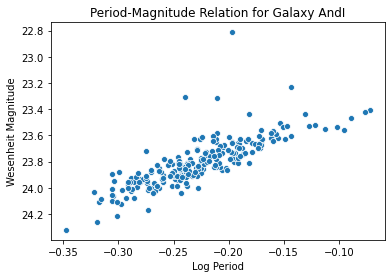

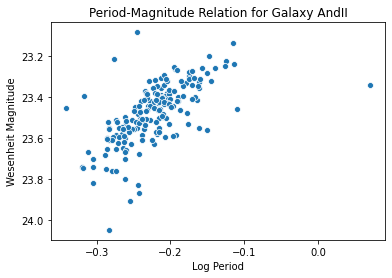

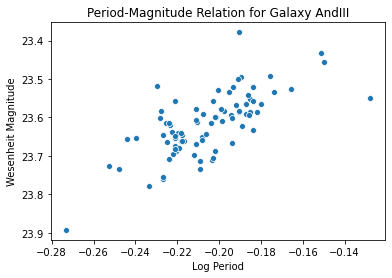

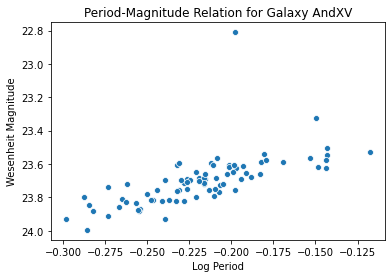

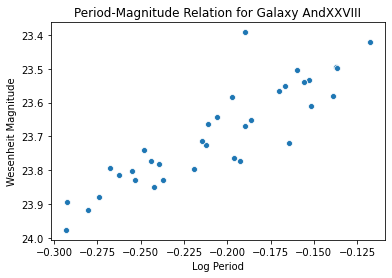

In [16]:
for gal in and_galaxies:
    plt.figure()
    hub_filtered = hubble_lin_reg[(hubble_lin_reg['Galaxy'] == gal)]
    sns.scatterplot(data = hub_filtered, x = 'Log Period', y = 'Wesenheit Magnitude')
    plt.gca().invert_yaxis()
    plt.title(f'Period-Magnitude Relation for Galaxy {gal}');

In [17]:
and_vi_path = os.path.join('Andromeda', 'Andromeda VI/and_vi.txt')

and_vi_names = ['Star', 'RA Hour', 'RA Minute', 'RA Second', 'Dec Degree', 'Dec Minute', 'Dec Second', 'Period (Days)', 
                 'V Magnitude', 'B Magnitude', 'Color', 'V Amplitude', 'B Amplitude', 'Period Error', 'Metallicity', 'Type']

and_six_graph_tab, and_vi_lin_reg = convert_table(and_vi_path, 'Andromeda VI', and_vi_names, b = True)

In [18]:
display(and_vi_lin_reg.head())
and_vi_lin_reg.to_csv('Monte Carlo/and_six_mcmc.csv', index = False)

,Star,Wesenheit Magnitude,Uncertainty in Wesenheit Magnitude,Log Period,Star Code
0,V01,24.325874,0.03,-0.237321,0
1,V07,24.336150,0.03,-0.185752,1
2,V08,24.346644,0.03,-0.229148,2
3,V09,24.385252,0.03,-0.239578,3
4,V11,24.430834,0.03,-0.272459,4


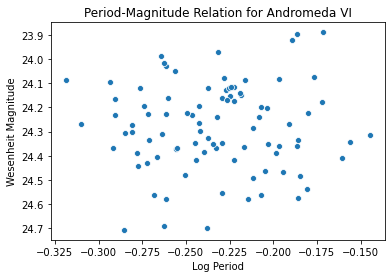

In [19]:
plt.figure()
sns.scatterplot(data = and_vi_lin_reg, x = 'Log Period', y = 'Wesenheit Magnitude')
plt.gca().invert_yaxis()
plt.title(f'Period-Magnitude Relation for Andromeda VI');

In [20]:
and_vii_path = os.path.join('Andromeda', 'Andromeda VII/and_vii.txt')

and_vii_names = ['Star', 'RA Hour', 'RA Minute', 'RA Second', 'Dec Degree', 'Dec Minute', 'Dec Second', 'Period (Days)', 
                 'F435W Magnitude', 'F435W Amplitude', 'F555W Magnitude', 'F555W Amplitude', 'Color', 'Type']

and_seven_graph_tab, and_vii_lin_reg = convert_table(and_vii_path, 'Andromeda VI', and_vii_names, convert = 'hubble', b = True)

In [21]:
display(and_vii_lin_reg.head())
and_vii_lin_reg.to_csv('Monte Carlo/and_seven_mcmc.csv', index = False)

,Star,Wesenheit Magnitude,Uncertainty in Wesenheit Magnitude,Log Period,Star Code
0,V001,24.602205,0.03,-0.281498,0
1,V002,23.762850,0.03,-0.203426,1
2,V003,23.930544,0.03,-0.134896,2
3,V004,25.874456,0.03,-0.299296,3
4,V008,22.190573,0.03,-0.203426,4


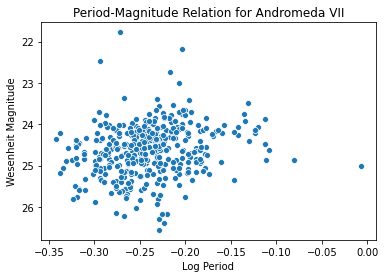

In [22]:
plt.figure()
sns.scatterplot(data = and_vii_lin_reg, x = 'Log Period', y = 'Wesenheit Magnitude')
plt.gca().invert_yaxis()
plt.title(f'Period-Magnitude Relation for Andromeda VII');

In [23]:
def and_xi_xiii_parser(path, galaxy, names):
    """Generates linear regression table for And XI and And XIII."""
    pulsation = pd.read_csv(path, header = None, names = names, sep = '\s{1,}', engine = 'python')
    pulsation['I Magnitude'] = pulsation['V Magnitude'] - pulsation['Color']
    
    lin_reg = pulsation[['Star', 'V Magnitude', 'I Magnitude', 'Color', 'Period (Days)', 'Type']]
    
    mean_v_rrl.append([galaxy, np.mean(lin_reg['V Magnitude'])])

    lin_reg['Wesenheit Magnitude'] = lin_reg['I Magnitude'] - 1.467 * lin_reg['Color']
    lin_reg['Uncertainty in Wesenheit Magnitude'] = 0.03

    lin_reg['Log Period'] = np.log10(lin_reg['Period (Days)'])
    lin_reg = lin_reg[['Star', 'Wesenheit Magnitude', 'Uncertainty in Wesenheit Magnitude', 'Log Period', 'Type']]

    graph_tab = lin_reg.copy().rename({'Type' : 'Variable Type'}, axis = 1)
    lin_reg =  lin_reg[lin_reg['Type'] == 'ab'].reset_index().drop(['index', 'Type'], axis = 1)
    
    num_stars = len(lin_reg['Star'].unique())
    lookup = dict(zip(lin_reg['Star'].unique(), range(num_stars)))
    lin_reg['Star Code'] = lin_reg['Star'].replace(lookup).values
    
    return graph_tab, lin_reg

In [24]:
and_xi_path = os.path.join('Andromeda', 'Andromeda XI and XIII/and_xi.txt')

and_xi_names = ['Star', 'RA Hour', 'RA Min', 'RA Sec', 'Dec Degree', 'Dec Arcmin', 'Dec Arcsec', 'V Magnitude', 'Color', 
                'Period (Days)', 'V Amplitude', 'Type']

and_eleven_graph_tab, and_xi_lin_reg = and_xi_xiii_parser(and_xi_path, 'Andromeda XI', and_xi_names)

display(and_xi_lin_reg.head())
and_xi_lin_reg.to_csv('Monte Carlo/and_eleven_mcmc.csv', index = False)

,Star,Wesenheit Magnitude,Uncertainty in Wesenheit Magnitude,Log Period,Star Code
0,V00409,23.515206,0.03,-0.197432,0
1,V00424,23.568245,0.03,-0.251037,1
2,V00425,23.970568,0.03,-0.274660,2
3,V02120,23.370835,0.03,-0.140862,3
4,V02157,23.753403,0.03,-0.096910,4


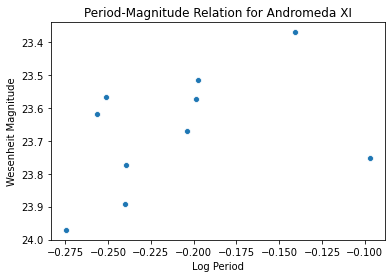

In [25]:
plt.figure()
sns.scatterplot(data = and_xi_lin_reg, x = 'Log Period', y = 'Wesenheit Magnitude')
plt.gca().invert_yaxis()
plt.title(f'Period-Magnitude Relation for Andromeda XI');

In [26]:
xi_path = os.path.join('Andromeda', 'A11_RRL.dat')

xi_names = ['Star', 'Period (Days)', 'V Magnitude', 'V Magnitude Error', 'I Magnitude', 'I Magnitude Error', 'Type']

xi_pulsation = pd.read_csv(xi_path, header = None, names = xi_names, sep = '\s{1,}', engine = 'python', 
                           usecols = [0, 1, 4, 5, 6, 7, 8])

xi_lin_reg = xi_pulsation[['Star', 'V Magnitude', 'I Magnitude', 'Period (Days)', 'Type']]
xi_lin_reg['V Magnitude'] = xi_lin_reg['V Magnitude'].astype(np.float64)
xi_lin_reg['I Magnitude'] = xi_lin_reg['I Magnitude'].astype(np.float64)

xi_lin_reg['Wesenheit Magnitude'] = xi_lin_reg['I Magnitude'] - 1.467 * (xi_lin_reg['V Magnitude'] - xi_lin_reg['I Magnitude'])
xi_lin_reg['Uncertainty in Wesenheit Magnitude'] = np.sqrt(xi_pulsation['V Magnitude Error'] ** 2 + 
                                                           xi_pulsation['I Magnitude Error'] ** 2)

xi_lin_reg['Log Period'] = np.log10(xi_lin_reg['Period (Days)'])
xi_lin_reg = xi_lin_reg[['Star', 'Wesenheit Magnitude', 'Uncertainty in Wesenheit Magnitude', 'Log Period', 'Type']]
xi_lin_reg =  xi_lin_reg[xi_lin_reg['Type'] == 'ab'].reset_index().drop(['index', 'Type'], axis = 1)

num_stars = len(xi_lin_reg['Star'].unique())
lookup = dict(zip(xi_lin_reg['Star'].unique(), range(num_stars)))
xi_lin_reg['Star Code'] = xi_lin_reg['Star'].replace(lookup).values

display(xi_lin_reg.head())
xi_lin_reg.to_csv('Monte Carlo/and_eleven_mcmc_test.csv', index = False)

,Star,Wesenheit Magnitude,Uncertainty in Wesenheit Magnitude,Log Period,Star Code
0,5872,23.544171,0.062129,-0.112946,0
1,6005,23.518760,0.086400,-0.177832,1
2,6026,23.571699,0.208701,-0.178486,2
3,6051,23.603308,0.123810,-0.190440,3
4,6114,23.671780,0.262545,-0.221126,4


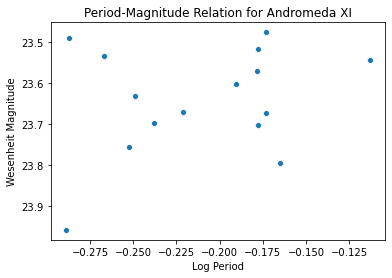

In [27]:
plt.figure()
sns.scatterplot(data = xi_lin_reg, x = 'Log Period', y = 'Wesenheit Magnitude')
plt.gca().invert_yaxis()
plt.title(f'Period-Magnitude Relation for Andromeda XI');

In [28]:
and_xiii_path = os.path.join('Andromeda', 'Andromeda XI and XIII/and_xiii.txt')

and_thirteen_graph_tab, and_xiii_lin_reg = and_xi_xiii_parser(and_xiii_path, 'Andromeda XIII', and_xi_names)

display(and_xiii_lin_reg.head())
and_xiii_lin_reg.to_csv('Monte Carlo/and_thirteen_mcmc.csv', index = False)

,Star,Wesenheit Magnitude,Uncertainty in Wesenheit Magnitude,Log Period,Star Code
0,V00026,23.764237,0.03,-0.225556,0
1,V00620,23.467850,0.03,-0.170118,1
2,V00629,23.565731,0.03,-0.212256,2
3,V00636,23.567077,0.03,-0.090658,3
4,V00651,23.732918,0.03,-0.223299,4


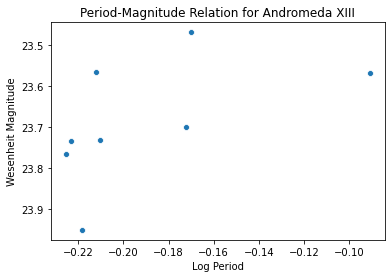

In [29]:
plt.figure()
sns.scatterplot(data = and_xiii_lin_reg, x = 'Log Period', y = 'Wesenheit Magnitude')
plt.gca().invert_yaxis()
plt.title(f'Period-Magnitude Relation for Andromeda XIII');

In [30]:
and_xvi_path = os.path.join('Andromeda', 'Andromeda XVI/and_xvi.txt')

and_xvi_names = ['Star', 'RA', 'Dec', 'Type', 'Period (Days)', 'F475W Magnitude', 'F475 Amplitude',
                 'F814W Magnitude', 'F814W Amplitude', 'B Magnitude', 'B Amplitude', 
                 'V Magnitude', 'V Amplitude', 'I Magnitude', 'I Amplitude']

and_xvi_graph_tab, and_xvi_lin_reg = convert_table(and_xvi_path, 'Andromeda XVI', and_xvi_names)

In [31]:
filter_sixteen = (and_xvi_graph_tab['Variable Type'] == 'ab')
and_xvi_graph_tab['Outlier'] = filter_sixteen & (and_xvi_graph_tab['Wesenheit Magnitude'] > 23.5)
display(and_xvi_graph_tab.head())

,Star,Variable Type,Period (Days),Wesenheit Magnitude,V Magnitude,Uncertainty in Wesenheit Magnitude,Log Period,Outlier
0,V0,ab,0.622,23.827942,25.244,0.03,-0.206210,True
1,V1,c,0.358,23.166043,24.328,0.03,-0.446117,False
2,V2,c,0.391,23.084368,24.308,0.03,-0.407823,False
3,V3,c,0.350,23.209916,24.325,0.03,-0.455932,False
4,V4,ab,0.617,22.887074,24.313,0.03,-0.209715,False


In [32]:
bool_filter_sixteen = and_xvi_graph_tab[and_xvi_graph_tab['Variable Type'] == 'ab'].reset_index()['Outlier']
and_xvi_lin_reg = and_xvi_lin_reg.loc[~(bool_filter_sixteen), :]
and_xvi_lin_reg = fix_star_code(and_xvi_lin_reg)
and_sixteen_graph_tab = and_xvi_graph_tab.copy()
display(and_xvi_lin_reg.head())
and_xvi_lin_reg.to_csv('Monte Carlo/and_sixteen_mcmc.csv', index = False)

,Star,Wesenheit Magnitude,Uncertainty in Wesenheit Magnitude,Log Period,Star Code
0,V4,22.887074,0.03,-0.209715,0
1,V5,22.862536,0.03,-0.195179,1
2,V8,22.945480,0.03,-0.186419,2


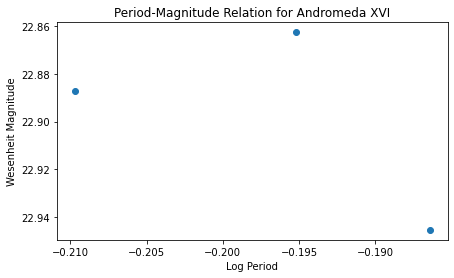

In [33]:
plt.figure(figsize = (7, 4))
plt.scatter(and_xvi_lin_reg['Log Period'], and_xvi_lin_reg['Wesenheit Magnitude'])
plt.gca().invert_yaxis()
plt.xlabel('Log Period')
plt.ylabel('Wesenheit Magnitude')
plt.title(f'Period-Magnitude Relation for Andromeda XVI');

In [34]:
xvi_path = os.path.join('Andromeda', 'AND16_ACS_RRL.dat')

xvi_names = ['Star', 'Period (Days)', 'V Magnitude', 'V Magnitude Error', 'I Magnitude', 'I Magnitude Error', 'Type']

xvi_pulsation = pd.read_csv(xvi_path, header = None, names = xvi_names, sep = '\s{1,}', engine = 'python', 
                           usecols = [0, 3, 6, 7, 8, 9, 14])

xvi_lin_reg = xvi_pulsation[['Star', 'V Magnitude', 'I Magnitude', 'Period (Days)', 'Type']]
xvi_lin_reg['V Magnitude'] = xvi_lin_reg['V Magnitude'].astype(np.float64)
xvi_lin_reg['I Magnitude'] = xvi_lin_reg['I Magnitude'].astype(np.float64)

xvi_lin_reg['Wesenheit Magnitude'] = xvi_lin_reg['I Magnitude'] - 1.467 * (xvi_lin_reg['V Magnitude'] - xvi_lin_reg['I Magnitude'])
xvi_lin_reg['Uncertainty in Wesenheit Magnitude'] = np.sqrt(xvi_pulsation['V Magnitude Error'] ** 2 + 
                                                           xvi_pulsation['I Magnitude Error'] ** 2)

xvi_lin_reg['Log Period'] = np.log10(xvi_lin_reg['Period (Days)'])
xvi_lin_reg = xvi_lin_reg[['Star', 'Wesenheit Magnitude', 'Uncertainty in Wesenheit Magnitude', 'Log Period', 'Type']]
xvi_lin_reg =  xvi_lin_reg[xvi_lin_reg['Type'] == 'ab'].reset_index().drop(['index', 'Type'], axis = 1)

num_stars = len(xvi_lin_reg['Star'].unique())
lookup = dict(zip(xvi_lin_reg['Star'].unique(), range(num_stars)))
xvi_lin_reg['Star Code'] = xvi_lin_reg['Star'].replace(lookup).values

display(xvi_lin_reg.head())
xvi_lin_reg.to_csv('Monte Carlo/and_sixteen_mcmc_test.csv', index = False)

,Star,Wesenheit Magnitude,Uncertainty in Wesenheit Magnitude,Log Period,Star Code
0,971,22.774328,0.032932,-0.202732,0
1,1022,22.842277,0.031713,-0.194499,1
2,1157,22.928135,0.052219,-0.207608,2


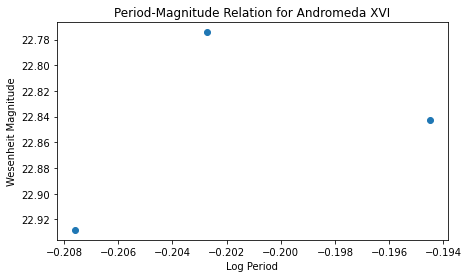

In [35]:
plt.figure(figsize = (7, 4))
plt.scatter(xvi_lin_reg['Log Period'], xvi_lin_reg['Wesenheit Magnitude'])
plt.gca().invert_yaxis()
plt.xlabel('Log Period')
plt.ylabel('Wesenheit Magnitude')
plt.title(f'Period-Magnitude Relation for Andromeda XVI');

In [36]:
and_xix_path = os.path.join('Andromeda', 'Andromeda XIX/and_xix.txt')

and_xix_names = ['Star', 'RA', 'Dec', 'Type', 'Period (Days)', 'Epoch', 'B Magnitude', 'V Magnitude', 
                 'B Amplitude', 'V Amplitude']

and_nineteen_graph_tab, and_xix_lin_reg = convert_table(and_xix_path, 'Andromeda XIX', and_xix_names, b = True)

In [37]:
display(and_xix_lin_reg.head())
and_xix_lin_reg.to_csv('Monte Carlo/and_nineteen_mcmc.csv', index = False)

,Star,Wesenheit Magnitude,Uncertainty in Wesenheit Magnitude,Log Period,Star Code
0,V1,23.82158,0.03,-0.253366,0
1,V2,24.23680,0.03,-0.232399,1
2,V9,23.61926,0.03,-0.210490,2
3,V10,23.74100,0.03,-0.217958,3
4,V11,23.76042,0.03,-0.208029,4


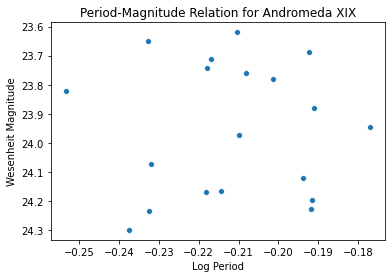

In [38]:
plt.figure()
sns.scatterplot(data = and_xix_lin_reg, x = 'Log Period', y = 'Wesenheit Magnitude')
plt.gca().invert_yaxis()
plt.title(f'Period-Magnitude Relation for Andromeda XIX');

In [39]:
and_xxi_path = os.path.join('Andromeda', 'Andromeda XXI/and_xxi.txt')

and_xxi_names = ['Star', 'RA', 'Dec', 'Type', 'Period (Days)', 'Epoch', 'B Magnitude', 'V Magnitude', 
                 'B Amplitude', 'V Amplitude']

and_twenty_one_graph_tab, and_xxi_lin_reg = convert_table(and_xxi_path, 'Andromeda XXI', and_xxi_names, b = True)

In [40]:
display(and_xxi_lin_reg.head())
and_xxi_lin_reg.to_csv('Monte Carlo/and_twenty_one_mcmc.csv', index = False)

,Star,Wesenheit Magnitude,Uncertainty in Wesenheit Magnitude,Log Period,Star Code
0,V2,24.37738,0.03,-0.215739,0
1,V3,23.86274,0.03,-0.235824,1
2,V5,23.62984,0.03,-0.173407,2
3,V7,23.97332,0.03,-0.212398,3
4,V8,23.03404,0.03,-0.078730,4


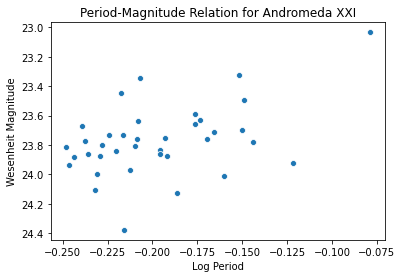

In [41]:
plt.figure()
sns.scatterplot(data = and_xxi_lin_reg, x = 'Log Period', y = 'Wesenheit Magnitude')
plt.gca().invert_yaxis()
plt.title(f'Period-Magnitude Relation for Andromeda XXI');

In [42]:
and_xxii_path = os.path.join('Andromeda', 'AND22_ACS_RRL.dat')

and_xxii_names = ['Star', 'Period (Days)', 'V Magnitude', 'V Magnitude Error', 'I Magnitude', 'I Magnitude Error', 'Type']

and_xxii_pulsation = pd.read_csv(and_xxii_path, header = None, names = and_xxii_names, sep = '\s{1,}', engine = 'python', 
                           usecols = [0, 3, 6, 7, 8, 9, 14])

and_xxii_lin_reg = and_xxii_pulsation[['Star', 'V Magnitude', 'I Magnitude', 'Period (Days)', 'Type']]
and_xxii_lin_reg['V Magnitude'] = and_xxii_lin_reg['V Magnitude'].astype(np.float64)
and_xxii_lin_reg['I Magnitude'] = and_xxii_lin_reg['I Magnitude'].astype(np.float64)

and_xxii_lin_reg['Wesenheit Magnitude'] = and_xxii_lin_reg['I Magnitude'] - 1.467 * (and_xxii_lin_reg['V Magnitude'] - and_xxii_lin_reg['I Magnitude'])
and_xxii_lin_reg['Uncertainty in Wesenheit Magnitude'] = np.sqrt(and_xxii_pulsation['V Magnitude Error'] ** 2 + 
                                                           and_xxii_pulsation['I Magnitude Error'] ** 2)

and_xxii_lin_reg['Log Period'] = np.log10(and_xxii_lin_reg['Period (Days)'])
and_xxii_lin_reg = and_xxii_lin_reg[['Star', 'Wesenheit Magnitude', 'Uncertainty in Wesenheit Magnitude', 'Log Period', 'Type']]
and_xxii_lin_reg =  and_xxii_lin_reg[and_xxii_lin_reg['Type'] == 'ab'].reset_index().drop(['index', 'Type'], axis = 1)

num_stars = len(and_xxii_lin_reg['Star'].unique())
lookup = dict(zip(and_xxii_lin_reg['Star'].unique(), range(num_stars)))
and_xxii_lin_reg['Star Code'] = and_xxii_lin_reg['Star'].replace(lookup).values

display(and_xxii_lin_reg.head())
and_xxii_lin_reg.to_csv('Monte Carlo/and_twenty_two_mcmc_test.csv', index = False)

,Star,Wesenheit Magnitude,Uncertainty in Wesenheit Magnitude,Log Period,Star Code
0,2495,23.339958,0.040116,-0.210419,0
1,3244,23.532780,0.054306,-0.164309,1
2,3548,23.635176,0.030066,-0.209012,2
3,3663,23.699841,0.041628,-0.241088,3
4,3752,23.720897,0.063372,-0.227678,4


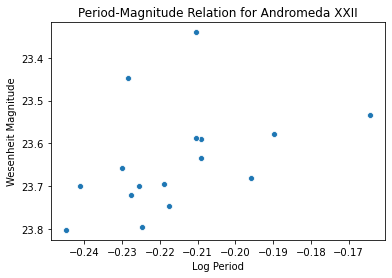

In [43]:
plt.figure()
sns.scatterplot(data = and_xxii_lin_reg, x = 'Log Period', y = 'Wesenheit Magnitude')
plt.gca().invert_yaxis()
plt.title(f'Period-Magnitude Relation for Andromeda XXII');

In [44]:
and_xxv_path = os.path.join('Andromeda', 'Andromeda XXV/and_xxv.txt')

and_xxv_names = ['Star', 'RA Hour', 'RA Minute', 'RA Second', 'Dec Degree', 'Dec Minute', 'Dec Second', 'Type', 
                 'Period (Days)', 'Epoch', 'B Magnitude', 'V Magnitude', 'B Amplitude', 'V Amplitude']

and_xxv_graph_tab, and_xxv_lin_reg = convert_table(and_xxv_path, 'Andromeda XXV', and_xxv_names, b = True)

In [45]:
filter_twenty_five = (and_xxv_graph_tab['Variable Type'] == 'RRab')
and_xxv_graph_tab['Outlier'] = filter_twenty_five & (and_xxv_graph_tab['Wesenheit Magnitude'] < 23.25)
display(and_xxv_graph_tab.head())

,Star,Variable Type,Period (Days),Wesenheit Magnitude,V Magnitude,Uncertainty in Wesenheit Magnitude,Log Period,Outlier
0,V1,RRab,0.6078,23.95216,25.42,0.03,-0.216239,False
1,V2,RRab,0.5459,24.18738,25.38,0.03,-0.262887,False
2,V3,RRab,0.6147,24.29854,25.43,0.03,-0.211337,False
3,V5,RRc,0.3858,24.15622,25.41,0.03,-0.413638,False
4,V6,RRab,0.6090,24.15970,25.23,0.03,-0.215383,False


In [46]:
bool_filter_twenty_five = and_xxv_graph_tab[and_xxv_graph_tab['Variable Type'] == 'RRab'].reset_index()['Outlier']
and_xxv_lin_reg = and_xxv_lin_reg.loc[~(bool_filter_twenty_five), :]
and_xxv_lin_reg = fix_star_code(and_xxv_lin_reg)
and_twenty_five_graph_tab = and_xxv_graph_tab.copy()
display(and_xxv_lin_reg.head())
and_xxv_lin_reg.to_csv('Monte Carlo/and_twenty_five_mcmc.csv', index = False)

,Star,Wesenheit Magnitude,Uncertainty in Wesenheit Magnitude,Log Period,Star Code
0,V1,23.95216,0.03,-0.216239,0
1,V2,24.18738,0.03,-0.262887,1
2,V3,24.29854,0.03,-0.211337,2
3,V6,24.15970,0.03,-0.215383,3
4,V7,24.13622,0.03,-0.213533,4


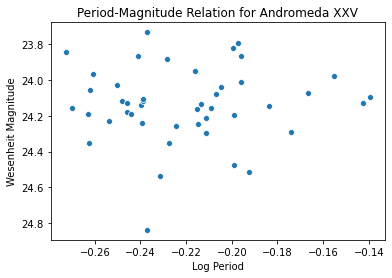

In [47]:
plt.figure()
sns.scatterplot(data = and_xxv_lin_reg, x = 'Log Period', y = 'Wesenheit Magnitude')
plt.gca().invert_yaxis()
plt.title(f'Period-Magnitude Relation for Andromeda XXV');

In [48]:
and_xxvi_path = os.path.join('Andromeda', 'AND26_ACS_RRL.dat')

and_xxvi_names = ['Star', 'Period (Days)', 'V Magnitude', 'V Magnitude Error', 'I Magnitude', 'I Magnitude Error', 'Type']

and_xxvi_pulsation = pd.read_csv(and_xxvi_path, header = None, names = and_xxvi_names, sep = '\s{1,}', engine = 'python', 
                           usecols = [0, 3, 6, 7, 8, 9, 14])

and_xxvi_lin_reg = and_xxvi_pulsation[['Star', 'V Magnitude', 'I Magnitude', 'Period (Days)', 'Type']]
and_xxvi_lin_reg['V Magnitude'] = and_xxvi_lin_reg['V Magnitude'].astype(np.float64)
and_xxvi_lin_reg['I Magnitude'] = and_xxvi_lin_reg['I Magnitude'].astype(np.float64)

and_xxvi_lin_reg['Wesenheit Magnitude'] = and_xxvi_lin_reg['I Magnitude'] - 1.467 * (and_xxvi_lin_reg['V Magnitude'] - and_xxvi_lin_reg['I Magnitude'])
and_xxvi_lin_reg['Uncertainty in Wesenheit Magnitude'] = np.sqrt(and_xxvi_pulsation['V Magnitude Error'] ** 2 + 
                                                           and_xxvi_pulsation['I Magnitude Error'] ** 2)

and_xxvi_lin_reg['Log Period'] = np.log10(and_xxvi_lin_reg['Period (Days)'])
and_xxvi_lin_reg = and_xxvi_lin_reg[['Star', 'Wesenheit Magnitude', 'Uncertainty in Wesenheit Magnitude', 'Log Period', 'Type']]
and_xxvi_lin_reg =  and_xxvi_lin_reg[and_xxvi_lin_reg['Type'] == 'ab'].reset_index().drop(['index', 'Type'], axis = 1)

num_stars = len(and_xxvi_lin_reg['Star'].unique())
lookup = dict(zip(and_xxvi_lin_reg['Star'].unique(), range(num_stars)))
and_xxvi_lin_reg['Star Code'] = and_xxvi_lin_reg['Star'].replace(lookup).values

display(and_xxvi_lin_reg.head())
and_xxvi_lin_reg.to_csv('Monte Carlo/and_twenty_six_mcmc_test.csv', index = False)

,Star,Wesenheit Magnitude,Uncertainty in Wesenheit Magnitude,Log Period,Star Code
0,2473,23.203085,0.058223,-0.163676,0
1,3417,23.663841,0.076761,-0.200659,1
2,3519,23.556755,0.028064,-0.136083,2
3,3674,23.580765,0.040259,-0.126098,3
4,3698,23.693308,0.081530,-0.198596,4


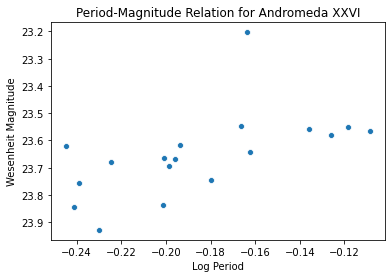

In [49]:
plt.figure()
sns.scatterplot(data = and_xxvi_lin_reg, x = 'Log Period', y = 'Wesenheit Magnitude')
plt.gca().invert_yaxis()
plt.title(f'Period-Magnitude Relation for Andromeda XXVI');

In [50]:
and_xxvii_path = os.path.join('Andromeda', 'Andromeda XXVII/and_xxvii.txt')

and_xxvii_names = ['Star', 'RA', 'Dec', 'Type', 'Period (Days)', 'Epoch', 'B Magnitude', 'B Amplitude', 'V Magnitude', 
                   'V Amplitude']

and_twenty_seven_graph_tab, and_xxvii_lin_reg = convert_table(and_xxvii_path, 'Andromda XXVII', and_xxvii_names, b = True)

In [51]:
display(and_xxvii_lin_reg.head())
and_xxvii_lin_reg.to_csv('Monte Carlo/and_twenty_seven_mcmc.csv', index = False)

,Star,Wesenheit Magnitude,Uncertainty in Wesenheit Magnitude,Log Period,Star Code
0,V1,23.59448,0.03,-0.209644,0
1,V5,24.29970,0.03,-0.218388,1
2,V7,23.62926,0.03,-0.236722,2
3,V8,23.88622,0.03,-0.221921,3
4,V9,24.05854,0.03,-0.160522,4


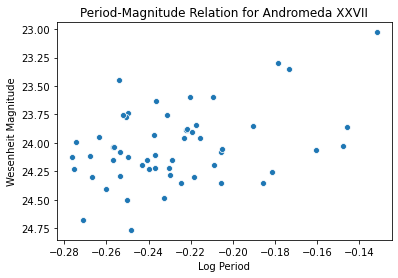

In [52]:
plt.figure()
sns.scatterplot(data = and_xxvii_lin_reg, x = 'Log Period', y = 'Wesenheit Magnitude')
plt.gca().invert_yaxis()
plt.title(f'Period-Magnitude Relation for Andromeda XXVII');

# Application to Sculptor 

In [53]:
sculptor_path = os.path.join('Sculptor/J_MNRAS_462_4349', 'table4.dat')

sculptor_names = ['Star', 'Name 1', 'Name 2', 'RA (Hour)', 'RA (Minutes)', 'RA (Seconds)', 'Dec (Degrees)', 'Dec (Minutes)', 
                  'Dec (Seconds)', 'Period (Days)', 'Uncertainty Flag on Period', 'Mean Magnitude (B)', 'Mean Magnitude (V)', 
                  'Mean Magnitude (I)', 'Amplitude (B)', 'Amplitude (V)', 'Amplitude (I)', 'Quality Flag 1', 'Quality Flag 2',
                  'Variable Type']

sculptor_pulsation = pd.read_csv(sculptor_path, sep = '\s{1,}', header = None, names = sculptor_names, engine = 'python', 
                                 usecols = [i for i in range(21)])

sculptor_pulsation = sculptor_pulsation.replace({"--" : np.nan, "----" : np.nan, "-----" : np.nan})
sculptor_pulsation.head()

,Star,Name 1,Name 2,RA (Hour),RA (Minutes),RA (Seconds),Dec (Degrees),Dec (Minutes),Dec (Seconds),Period (Days),Uncertainty Flag on Period,Mean Magnitude (B),Mean Magnitude (V),Mean Magnitude (I),Amplitude (B),Amplitude (V),Amplitude (I),Quality Flag 1,Quality Flag 2,Variable Type
0,scl-CEMV001,V461,NaN,0,55,21.02,-33,41,1.5,0.420876,::,20.150,19.830,19.460,0.900,0.630,0.000,1,0,RRab
1,scl-CEMV002,NaN,NaN,0,56,9.15,-33,29,20.1,0.305970,NaN,20.326,20.163,19.840,0.298,0.254,0.168,0,1,RRc
2,scl-CEMV005,NaN,NaN,0,56,38.94,-33,24,32.4,0.309746,NaN,20.260,20.086,19.778,0.494,0.359,0.165,0,1,RRc
3,scl-CEMV006,NaN,NaN,0,56,48.78,-33,31,16.3,0.332111,NaN,20.333,20.117,19.738,0.568,0.479,0.401,0,1,RRc
4,scl-CEMV008,NaN,NaN,0,57,4.83,-33,45,20.6,0.281318,NaN,20.357,20.047,19.570,0.881,0.576,0.485,2,0,RRc


In [54]:
sculptor_lin_reg = sculptor_pulsation[['Star', 'Mean Magnitude (B)', 'Mean Magnitude (V)', 
                                       'Mean Magnitude (I)', 'Variable Type']]

sculptor_lin_reg['Wesenheit Magnitude'] = (sculptor_lin_reg['Mean Magnitude (I)'] - 1.467 * 
                                           (sculptor_lin_reg['Mean Magnitude (V)'] - sculptor_lin_reg['Mean Magnitude (I)']))

sculptor_lin_reg['Uncertainty in Wesenheit Magnitude'] = 0.03

sculptor_lin_reg['Log Period'] = np.log10(sculptor_pulsation['Period (Days)'])

sculptor_graph_tab = sculptor_lin_reg.copy()

sculptor_lin_reg = sculptor_lin_reg[(sculptor_lin_reg['Variable Type'] == 'RRab') & (sculptor_lin_reg['Log Period'] < 0) 
                                    & (sculptor_lin_reg['Wesenheit Magnitude'] > 18.5)]

num_stars = len(sculptor_lin_reg['Star'].unique())
sculptor_lookup = dict(zip(sculptor_lin_reg['Star'].unique(), range(num_stars)))
sculptor_lin_reg['Star Code'] = sculptor_lin_reg['Star'].replace(sculptor_lookup).values

mean_v_rrl.append(['Sculptor', np.mean(sculptor_lin_reg['Mean Magnitude (V)'])])

sculptor_lin_reg = sculptor_lin_reg[['Star', 'Wesenheit Magnitude', 'Uncertainty in Wesenheit Magnitude',
                                     'Log Period', 'Star Code']]

sculptor_lin_reg = sculptor_lin_reg.reset_index().drop('index', axis = 1)
display(sculptor_lin_reg.head())
sculptor_lin_reg.to_csv('Monte Carlo/sculptor_mcmc.csv', index = False)

,Star,Wesenheit Magnitude,Uncertainty in Wesenheit Magnitude,Log Period,Star Code
0,scl-CEMV001,18.917210,0.03,-0.375846,0
1,scl-CEMV015,18.749754,0.03,-0.180738,1
2,scl-CEMV018,18.817292,0.03,-0.237532,2
3,scl-CEMV021,18.656998,0.03,-0.172550,3
4,scl-CEMV022,18.801490,0.03,-0.236795,4


In [55]:
sculptor_graph_tab['Outlier'] = ~((sculptor_graph_tab['Log Period'] < 0) & (sculptor_graph_tab['Wesenheit Magnitude'] > 18.5))
display(sculptor_graph_tab.head())

,Star,Mean Magnitude (B),Mean Magnitude (V),Mean Magnitude (I),Variable Type,Wesenheit Magnitude,Uncertainty in Wesenheit Magnitude,Log Period,Outlier
0,scl-CEMV001,20.150,19.830,19.460,RRab,18.917210,0.03,-0.375846,False
1,scl-CEMV002,20.326,20.163,19.840,RRc,19.366159,0.03,-0.514320,False
2,scl-CEMV005,20.260,20.086,19.778,RRc,19.326164,0.03,-0.508994,False
3,scl-CEMV006,20.333,20.117,19.738,RRc,19.182007,0.03,-0.478716,False
4,scl-CEMV008,20.357,20.047,19.570,RRc,18.870241,0.03,-0.550802,False


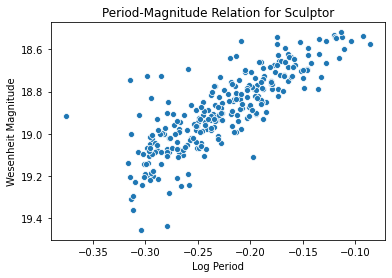

In [56]:
plt.figure()
sns.scatterplot(data = sculptor_lin_reg, x = 'Log Period', y = 'Wesenheit Magnitude')
plt.gca().invert_yaxis()
plt.title(f'Period-Magnitude Relation for Sculptor');

# Application to Crater II

In [57]:
crater_path = os.path.join('Crater II', 'crater_pulsation.csv')

crater_names = ['Star', 'RA', 'Dec', 'Period (Days)', 'Mean Magnitude (B)', 'Mean Amplitude (B)', 'Mean Magnitude (V)', 
                'Mean Amplitude (V)', 'Mean Magnitude (I)', 'Mean Amplitude (I)', 'Type', 'Period (Joo)', 'Notes']

crater_pulsation = pd.read_csv(crater_path, header = None, names = crater_names)
crater_pulsation.head()

,Star,RA,Dec,Period (Days),Mean Magnitude (B),Mean Amplitude (B),Mean Magnitude (V),Mean Amplitude (V),Mean Magnitude (I),Mean Amplitude (I),Type,Period (Joo),Notes
0,V001,11:48:46.94,−18:37:28.8,0.7633058,20.925,0.984,20.553,0.820,19.950,0.503,Peculiar,0.7633,NaN
1,V002,11:48:59.49,−18:10: 9.8,0.6043024,21.432,0.913,20.966,0.759,20.406,0.546,RRab,0.6053,NaN
2,V003,11:48:38.77,−18:31:40.2,0.6009024,21.217,1.019,20.920,0.834,20.349,0.515,RRab,0.6009,NaN
3,V004,11:48:51.17,−18:16:34.1,0.4091809,21.260,0.477,20.906,0.470,20.403,0.218,RRc,0.4189,NaN
4,V005,11:48:51.89,−18:31:56.7,0.5989511,21.227,1.229,20.904,0.966,20.335,0.575,RRab,0.5989,NaN


In [58]:
crater_lin_reg = crater_pulsation[['Star', 'Mean Magnitude (B)', 'Mean Magnitude (V)', 'Mean Magnitude (I)', 'Type']]

crater_lin_reg['Star'] = crater_lin_reg['Star'].str.strip()

crater_lin_reg = crater_lin_reg.astype({'Mean Magnitude (B)' : 'float64', 'Mean Magnitude (V)' : 'float64', 
                                        'Mean Magnitude (I)' : 'float64'})

crater_lin_reg['Type'] = crater_lin_reg['Type'].str.strip()

crater_lin_reg['Wesenheit Magnitude'] = (crater_lin_reg['Mean Magnitude (I)'] - 1.467 * 
                                         (crater_lin_reg['Mean Magnitude (V)'] - crater_lin_reg['Mean Magnitude (I)']))

crater_lin_reg['Uncertainty in Wesenheit Magnitude'] = 0.03

crater_lin_reg['Log Period'] = np.log10(crater_pulsation['Period (Days)'].astype('float64'))

crater_graph_tab = crater_lin_reg.rename({'Type' : 'Variable Type'}, axis = 1)

crater_lin_reg = crater_lin_reg[(crater_lin_reg['Type'] == 'RRab')]

num_stars = len(crater_lin_reg['Star'].unique())
crater_lookup = dict(zip(crater_lin_reg['Star'].unique(), range(num_stars)))
crater_lin_reg['Star Code'] = crater_lin_reg['Star'].replace(crater_lookup).values

mean_v_rrl.append(['Crater II', np.mean(crater_lin_reg['Mean Magnitude (V)'])])

crater_lin_reg = crater_lin_reg[['Star', 'Wesenheit Magnitude', 'Uncertainty in Wesenheit Magnitude',
                                 'Log Period', 'Star Code']]

crater_lin_reg = crater_lin_reg.reset_index().drop('index', axis = 1)
display(crater_lin_reg.head())

,Star,Wesenheit Magnitude,Uncertainty in Wesenheit Magnitude,Log Period,Star Code
0,V002,19.584480,0.03,-0.218746,0
1,V003,19.511343,0.03,-0.221196,1
2,V005,19.500277,0.03,-0.222609,2
3,V008,19.421866,0.03,-0.187286,3
4,V010,19.278521,0.03,-0.213724,4


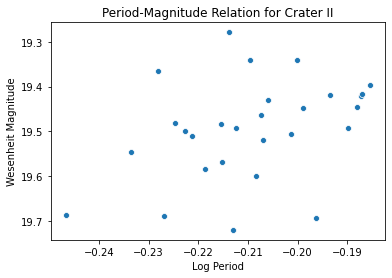

In [59]:
plt.figure()
sns.scatterplot(data = crater_lin_reg, x = 'Log Period', y = 'Wesenheit Magnitude')
plt.gca().invert_yaxis()
plt.title(f'Period-Magnitude Relation for Crater II');

In [60]:
vivas_periods = pd.read_csv('Crater II/crater_periods_new.csv')

filtered_vivas = vivas_periods[vivas_periods['Type'] == 'ab'].reset_index().drop(['index'], axis = 1)
filtered_vivas = filtered_vivas[filtered_vivas['Star'].isin(crater_lin_reg['Star'].unique())]
filtered_vivas = filtered_vivas.iloc[:, :2]

filtered_vivas.info()
filtered_vivas.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28 entries, 0 to 68
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Star           28 non-null     object 
 1   Period (Days)  28 non-null     float64
dtypes: float64(1), object(1)
memory usage: 672.0+ bytes


,Star,Period (Days)
0,V002,0.60442
1,V003,0.60078
2,V005,0.59900
4,V008,0.64982
6,V010,0.62107


In [61]:
vivas_log_periods = np.array(np.log10(filtered_vivas['Period (Days)']))
crater_lin_reg.loc[:, 'Log Period'] = vivas_log_periods
display(crater_lin_reg.head())
crater_lin_reg.to_csv('Monte Carlo/crater_mcmc.csv', index = False)

,Star,Wesenheit Magnitude,Uncertainty in Wesenheit Magnitude,Log Period,Star Code
0,V002,19.584480,0.03,-0.218661,0
1,V003,19.511343,0.03,-0.221285,1
2,V005,19.500277,0.03,-0.222573,2
3,V008,19.421866,0.03,-0.187207,3
4,V010,19.278521,0.03,-0.206859,4


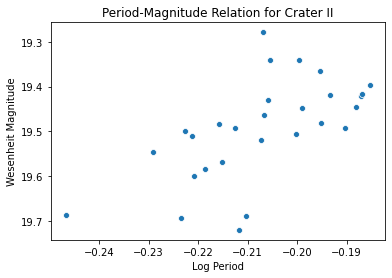

In [62]:
plt.figure()
sns.scatterplot(data = crater_lin_reg, x = 'Log Period', y = 'Wesenheit Magnitude')
plt.gca().invert_yaxis()
plt.title(f'Period-Magnitude Relation for Crater II');

In [63]:
filt_vivas_graph = vivas_periods[vivas_periods['Star'].isin(crater_graph_tab['Star'].unique())]
filt_vivas_graph = filt_vivas_graph.iloc[:, :2]
vivas_log_periods_graph = np.array(np.log10(filt_vivas_graph['Period (Days)']))
crater_graph_tab = crater_graph_tab[crater_graph_tab['Star'].isin(filt_vivas_graph['Star'].unique())]
crater_graph_tab.loc[:, 'Log Period'] = vivas_log_periods_graph
crater_graph_tab.head()

,Star,Mean Magnitude (B),Mean Magnitude (V),Mean Magnitude (I),Variable Type,Wesenheit Magnitude,Uncertainty in Wesenheit Magnitude,Log Period
0,V001,20.925,20.553,19.950,Peculiar,19.065399,0.03,-0.117231
1,V002,21.432,20.966,20.406,RRab,19.584480,0.03,-0.218661
2,V003,21.217,20.920,20.349,RRab,19.511343,0.03,-0.221285
3,V004,21.260,20.906,20.403,RRc,19.665099,0.03,-0.380375
4,V005,21.227,20.904,20.335,RRab,19.500277,0.03,-0.222573


# Application to IC1613

In [64]:
ic_path = os.path.join('IC1613', 'apj335928t4_mrt.txt')

ic_names = ['Star', 'Type', 'RA (Hour)', 'RA (Min)', 'RA (Sec)', 'Dec (Deg)', 'Dec (Min)', 'Dec (Sec)',
            'Uncertainty Flag', 'Period (Days)', 'Log Period (Days)', 'F475W Magnitude', 'F475W Amplitude', 
            'F814W Magnitude', 'F814W Amplitude', 'Color', 'B Magnitude', 'B Amplitude', 
            'V Magnitude', 'V Amplitude', 'I Magnitude', 'I Amplitude']

ic_graph_tab, ic_lin_reg = convert_table(ic_path, 'IC 1613', ic_names)

In [65]:
display(ic_lin_reg.head())
ic_lin_reg.to_csv('Monte Carlo/ic_mcmc.csv', index = False)

,Star,Wesenheit Magnitude,Uncertainty in Wesenheit Magnitude,Log Period,Star Code
0,V001,23.823236,0.03,-0.227678,0
1,V005,24.018068,0.03,-0.315155,1
2,V007,23.581211,0.03,-0.175224,2
3,V012,23.678972,0.03,-0.193142,3
4,V013,23.686114,0.03,-0.186419,4


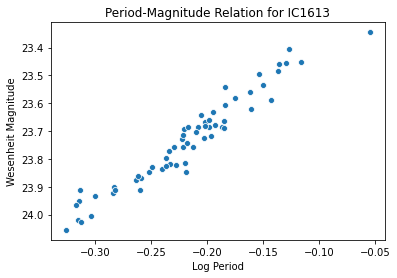

In [66]:
plt.figure()
sns.scatterplot(data = ic_lin_reg, x = 'Log Period', y = 'Wesenheit Magnitude')
plt.gca().invert_yaxis()
plt.title(f'Period-Magnitude Relation for IC1613');

# Application to Cetus and Tucana

In [67]:
cetus_path = os.path.join('Cetus', 'apj298915t7_mrt.txt')

cetus_names = ['Star', 'Type', 'RA (Hour)', 'RA (Min)', 'RA (Sec)', 'Dec (Deg)', 'Dec (Min)', 'Dec (Sec)',
               'Uncertainty Flag', 'Period (Days)', 'Log Period (Days)', 'F475W Magnitude', 'F475W Amplitude', 
               'F814W Magnitude', 'F814W Amplitude', 'Color', 'B Magnitude', 'B Amplitude', 
               'V Magnitude', 'V Amplitude', 'I Magnitude', 'I Amplitude']

cetus_graph_tab, cetus_lin_reg = convert_table(cetus_path, 'Cetus', cetus_names, impute = True)

In [68]:
display(cetus_lin_reg.head())
cetus_lin_reg.to_csv('Monte Carlo/cetus_mcmc.csv', index = False)

,Star,Wesenheit Magnitude,Uncertainty in Wesenheit Magnitude,Log Period,Star Code
0,V001,23.609409,0.03,-0.177832,0
1,V003,23.719419,0.03,-0.228413,1
2,V004,23.631541,0.03,-0.195179,2
3,V005,23.782891,0.03,-0.221126,3
4,V006,23.502668,0.03,-0.098542,4


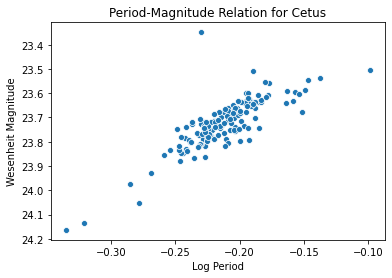

In [69]:
plt.figure()
sns.scatterplot(data = cetus_lin_reg, x = 'Log Period', y = 'Wesenheit Magnitude')
plt.gca().invert_yaxis()
plt.title(f'Period-Magnitude Relation for Cetus');

In [70]:
tucana_path = os.path.join('Tucana', 'apj298915t8_mrt.txt')

tucana_names = ['Star', 'Type', 'RA (Hour)', 'RA (Min)', 'RA (Sec)', 'Dec (Deg)', 'Dec (Min)', 'Dec (Sec)',
                'Uncertainty Flag', 'Period (Days)', 'Log Period (Days)', 'F475W Magnitude', 'F475W Amplitude', 
                'F814W Magnitude', 'F814W Amplitude', 'Color', 'B Magnitude', 'B Amplitude', 
                'V Magnitude', 'V Amplitude', 'I Magnitude', 'I Amplitude']

tucana_graph_tab, tucana_lin_reg = convert_table(tucana_path, 'Tucana', tucana_names, impute = True)

In [71]:
display(tucana_lin_reg.head())
tucana_lin_reg.to_csv('Monte Carlo/tucana_mcmc.csv', index = False)

,Star,Wesenheit Magnitude,Uncertainty in Wesenheit Magnitude,Log Period,Star Code
0,V003,24.060043,0.03,-0.202732,0
1,V005,24.276053,0.03,-0.265200,1
2,V007,23.884150,0.03,-0.166853,2
3,V011,24.071952,0.03,-0.226214,3
4,V014,24.073906,0.03,-0.246417,4


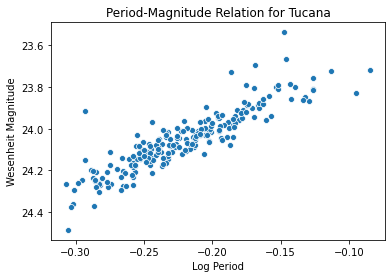

In [72]:
plt.figure()
sns.scatterplot(data = tucana_lin_reg, x = 'Log Period', y = 'Wesenheit Magnitude')
plt.gca().invert_yaxis()
plt.title(f'Period-Magnitude Relation for Tucana');

# Application to Leo Dwarf Galaxies

In [73]:
leo_a_path = os.path.join('Leo', 'Leo_A_variables.dat')
leo_a_names = ['Star', 'Type', 'Period (Days)', 'V Magnitude', 'I Magnitude']
leo_a_graph_tab, leo_a_lin_reg = convert_table(leo_a_path, 'Leo A', leo_a_names, usecols = [0, 1, 8, 17, 19])

In [74]:
display(leo_a_lin_reg.head())
leo_a_lin_reg.to_csv('Monte Carlo/leo_a_mcmc.csv', index = False)

,Star,Wesenheit Magnitude,Uncertainty in Wesenheit Magnitude,Log Period,Star Code
0,V001,23.357739,0.03,-0.161151,0
1,V019,23.655627,0.03,-0.204120,1
2,V029,23.853053,0.03,-0.231362,2
3,V052,23.727206,0.03,-0.190440,3
4,V077,23.562013,0.03,-0.167491,4


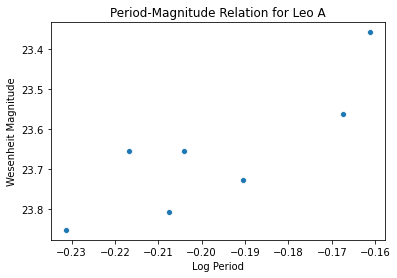

In [75]:
plt.figure()
sns.scatterplot(data = leo_a_lin_reg, x = 'Log Period', y = 'Wesenheit Magnitude')
plt.gca().invert_yaxis()
plt.title(f'Period-Magnitude Relation for Leo A');

In [76]:
leo_i_path = os.path.join('Leo', 'Leo_I_variables.dat')

leo_i_names = ['Star', 'Type', 'Period (Days)', 'V Magnitude', 'I Magnitude', 'Quality']

leo_i_pulsation = pd.read_csv(leo_i_path, sep = '\s{1,}', header = None, names = leo_i_names, engine = 'python', 
                            usecols = [0, 1, 2, 4, 6, 11])

leo_i_pulsation = leo_i_pulsation[leo_i_pulsation['Quality'] == 'A'].drop({'Quality'}, axis = 1)
leo_i_pulsation = leo_i_pulsation[leo_i_pulsation['I Magnitude'] != '-'].astype({'I Magnitude' : 'float64'})

leo_i_pulsation.info()
leo_i_pulsation.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 80 entries, 6 to 158
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Star           80 non-null     object 
 1   Type           80 non-null     object 
 2   Period (Days)  80 non-null     float64
 3   V Magnitude    80 non-null     float64
 4   I Magnitude    80 non-null     float64
dtypes: float64(3), object(2)
memory usage: 3.8+ KB


,Star,Type,Period (Days),V Magnitude,I Magnitude
6,V7,RRab,0.602402,22.75,22.25
8,V9,RRab,0.574817,22.69,22.34
21,V24,RRab,0.607729,22.78,22.25
26,V32,RRab,0.580355,22.66,22.27
28,V36,RRab,0.558055,22.70,22.23


In [77]:
leo_i_lin_reg = leo_i_pulsation[['Star', 'Type', 'V Magnitude', 'I Magnitude']]

leo_i_lin_reg['Wesenheit Magnitude'] = (leo_i_lin_reg['I Magnitude'] - 1.467 * 
                                     (leo_i_lin_reg['V Magnitude'] - leo_i_lin_reg['I Magnitude']))

leo_i_lin_reg['Uncertainty in Wesenheit Magnitude'] = 0.03

leo_i_lin_reg['Log Period'] = np.log10(leo_i_pulsation['Period (Days)'])

leo_i_graph_tab = leo_i_lin_reg.rename({'Type' : 'Variable Type'}, axis = 1)

leo_i_lin_reg = leo_i_lin_reg[leo_i_lin_reg['Type'] == 'RRab'].drop({'Type'}, axis = 1)

num_stars = len(leo_i_lin_reg['Star'].unique())
leo_i_lookup = dict(zip(leo_i_lin_reg['Star'].unique(), range(num_stars)))
leo_i_lin_reg['Star Code'] = leo_i_lin_reg['Star'].replace(leo_i_lookup).values

mean_v_rrl.append(['Leo I', np.mean(leo_i_lin_reg['V Magnitude'])])

leo_i_lin_reg = leo_i_lin_reg[['Star', 'Wesenheit Magnitude', 'Uncertainty in Wesenheit Magnitude', 'Log Period', 'Star Code']]

leo_i_lin_reg = leo_i_lin_reg.reset_index().drop('index', axis = 1)

display(leo_i_lin_reg.head())
leo_i_lin_reg.to_csv('Monte Carlo/leo_i_mcmc.csv', index = False)

,Star,Wesenheit Magnitude,Uncertainty in Wesenheit Magnitude,Log Period,Star Code
0,V7,21.51650,0.03,-0.220114,0
1,V9,21.82655,0.03,-0.240470,1
2,V24,21.47249,0.03,-0.216290,2
3,V32,21.69787,0.03,-0.236306,3
4,V36,21.54051,0.03,-0.253323,4


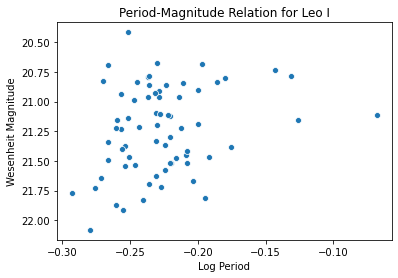

In [78]:
plt.figure()
sns.scatterplot(data = leo_i_lin_reg, x = 'Log Period', y = 'Wesenheit Magnitude')
plt.gca().invert_yaxis()
plt.title(f'Period-Magnitude Relation for Leo I');

In [79]:
leo_iv_path = os.path.join('Leo', 'Leo_IV_variables.txt')
leo_iv_names = ['Star', 'RA', 'Dec', 'Type', 'Period (Days)', 'Epoch',  'V Magnitude', 'B Magnitude', 
                'V Amplitude', 'B Amplitude']
leo_iv_graph_tab, leo_iv_lin_reg = convert_table(leo_iv_path, 'Leo IV', leo_iv_names, b = True)

In [80]:
display(leo_iv_lin_reg.head())
leo_iv_lin_reg.to_csv('Monte Carlo/leo_iv_mcmc.csv', index = False)

,Star,Wesenheit Magnitude,Uncertainty in Wesenheit Magnitude,Log Period,Star Code
0,V1,20.39970,0.03,-0.208344,0
1,V2,20.23680,0.03,-0.148986,1
2,V3,20.63318,0.03,-0.197226,2


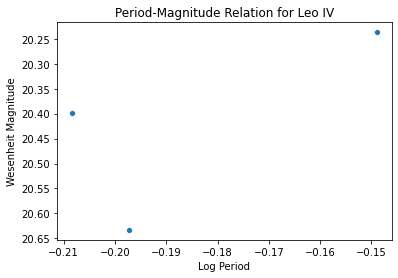

In [81]:
plt.figure()
sns.scatterplot(data = leo_iv_lin_reg, x = 'Log Period', y = 'Wesenheit Magnitude')
plt.gca().invert_yaxis()
plt.title(f'Period-Magnitude Relation for Leo IV');

In [82]:
leo_p_path = os.path.join('Leo', 'Leo_P_variables.txt')

leo_p_names = ['Star', 'F475 Magnitude', 'F814 Magnitude', 'Period (Days)']

leo_p_pulsation = pd.read_csv(leo_p_path, sep = '\s{1,}', header = None, names = leo_p_names, engine = 'python', 
                              usecols = [0, 7, 9, 13])

leo_p_pulsation.info()
leo_p_pulsation.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Star            10 non-null     int64  
 1   F475 Magnitude  10 non-null     float64
 2   F814 Magnitude  10 non-null     float64
 3   Period (Days)   10 non-null     float64
dtypes: float64(3), int64(1)
memory usage: 448.0 bytes


,Star,F475 Magnitude,F814 Magnitude,Period (Days)
0,1,26.87,26.04,0.61
1,2,26.85,26.22,0.52
2,3,26.89,26.11,0.69
3,4,26.90,26.16,0.64
4,5,26.90,26.25,0.57


In [83]:
leo_p_lin_reg = leo_p_pulsation[['Star']]

leo_p_color = leo_p_pulsation['F475 Magnitude'] - leo_p_pulsation['F814 Magnitude']
leo_p_V_mag = 0.026 + leo_p_pulsation['F475 Magnitude'] - 0.406 * leo_p_color
leo_p_I_mag = -0.038 + leo_p_pulsation['F814 Magnitude'] + 0.014 * leo_p_color

mean_v_rrl.append(['Leo P', np.mean(leo_p_V_mag)])

leo_p_lin_reg['Wesenheit Magnitude'] = leo_p_I_mag - 1.467 * (leo_p_V_mag - leo_p_I_mag)
leo_p_lin_reg['Uncertainty in Wesenheit Magnitude'] = 0.03

leo_p_lin_reg['Log Period'] = np.log10(leo_p_pulsation['Period (Days)'])

leo_p_graph_tab = leo_p_lin_reg.copy()
leo_p_graph_tab['Variable Type'] = 'RRab'

In [84]:
leo_p_graph_tab['Outlier'] = (leo_p_graph_tab['Log Period'] < -0.4)
display(leo_p_graph_tab.head())

,Star,Wesenheit Magnitude,Uncertainty in Wesenheit Magnitude,Log Period,Variable Type,Outlier
0,1,25.213518,0.03,-0.214670,RRab,False
1,2,25.560890,0.03,-0.283997,RRab,False
2,3,25.325361,0.03,-0.161151,RRab,False
3,4,25.408836,0.03,-0.193820,RRab,False
4,5,25.574153,0.03,-0.244125,RRab,False


In [85]:
leo_p_lin_reg = leo_p_lin_reg.loc[~leo_p_graph_tab['Outlier'], :]

num_stars = len(leo_p_lin_reg['Star'].unique())
leo_p_lookup = dict(zip(leo_p_lin_reg['Star'].unique(), range(num_stars)))
leo_p_lin_reg['Star Code'] = leo_p_lin_reg['Star'].replace(leo_p_lookup).values

leo_p_lin_reg = leo_p_lin_reg[['Star', 'Wesenheit Magnitude', 'Uncertainty in Wesenheit Magnitude', 'Log Period', 'Star Code']]
leo_p_lin_reg = leo_p_lin_reg.reset_index().drop('index', axis = 1)

display(leo_p_lin_reg.head())
leo_p_lin_reg.to_csv('Monte Carlo/leo_p_mcmc.csv', index = False)

,Star,Wesenheit Magnitude,Uncertainty in Wesenheit Magnitude,Log Period,Star Code
0,1,25.213518,0.03,-0.214670,0
1,2,25.560890,0.03,-0.283997,1
2,3,25.325361,0.03,-0.161151,2
3,4,25.408836,0.03,-0.193820,3
4,5,25.574153,0.03,-0.244125,4


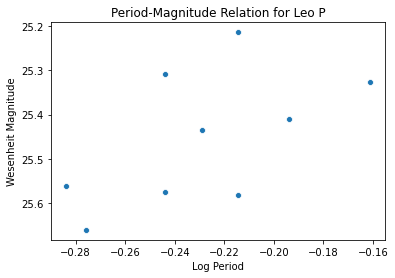

In [86]:
plt.figure()
sns.scatterplot(data = leo_p_lin_reg, x = 'Log Period', y = 'Wesenheit Magnitude')
plt.gca().invert_yaxis()
plt.title(f'Period-Magnitude Relation for Leo P');

In [87]:
# Leo T: Clementini et al. (2012)
mean_v_rrl.append(['Leo T', 23.59])
leo_t_wesenheit = 23.13 - 1.467 * (23.59 - 23.13)
leo_t_dict = {'Star' : 1, 'Wesenheit Magnitude' : leo_t_wesenheit, 'Uncertainty in Wesenheit Magnitude' : 0.03, 
              'Log Period' : np.log10(0.6027), 'Star Code' : 0}
leo_t_lin_reg = pd.DataFrame(leo_t_dict, index = [0])
leo_t_graph_tab = leo_t_lin_reg.copy()
leo_t_graph_tab['Variable Type'] = 'RRab'
display(leo_t_graph_tab.head())
display(leo_t_lin_reg.head())
leo_t_lin_reg.to_csv('Monte Carlo/leo_t_mcmc.csv', index = False)

,Star,Wesenheit Magnitude,Uncertainty in Wesenheit Magnitude,Log Period,Star Code,Variable Type
0,1,22.45518,0.03,-0.219899,0,RRab


,Star,Wesenheit Magnitude,Uncertainty in Wesenheit Magnitude,Log Period,Star Code
0,1,22.45518,0.03,-0.219899,0


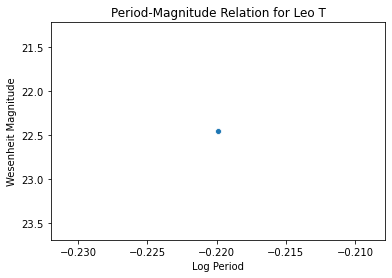

In [88]:
plt.figure()
sns.scatterplot(data = leo_t_lin_reg, x = 'Log Period', y = 'Wesenheit Magnitude')
plt.gca().invert_yaxis()
plt.title(f'Period-Magnitude Relation for Leo T');

# Application to NGC 147 and 185

In [89]:
NGC_147_path = os.path.join('NGC', 'NGC_147.txt')
NGC_147_names = ['Star', 'RA Hour', 'RA Minute', 'RA Second', 'Dec Degree', 'Dec Minute', 'Dec Second', 'Period (Days)', 
                 'F606W Magnitude', 'F606W Amplitude', 'F814W Magnitude', 'F814W Amplitude', 'Color', 'Type']

NGC_147_graph_tab, NGC_147_lin_reg = convert_table(NGC_147_path, 'NGC 147', NGC_147_names, convert = 'hubble')

In [90]:
filter_147 = (NGC_147_graph_tab['Variable Type'] == 'RRab')
outlier_one = (NGC_147_graph_tab['Log Period'] < -0.2) & (NGC_147_graph_tab['Wesenheit Magnitude'] < 23.0)
outlier_two = (NGC_147_graph_tab['Log Period'] > -0.2) & (NGC_147_graph_tab['Wesenheit Magnitude'] > 23.7)
NGC_147_graph_tab['Outlier'] = filter_147 & (outlier_one | outlier_two | (NGC_147_graph_tab['Log Period'] > 0.0))
display(NGC_147_graph_tab.head())

,Star,Variable Type,Period (Days),Wesenheit Magnitude,V Magnitude,Uncertainty in Wesenheit Magnitude,Log Period,Outlier
0,V001,RRab,0.610,23.255885,25.707695,0.03,-0.214670,False
1,V002,RRc,0.306,23.771914,25.856103,0.03,-0.514279,False
2,V003,RRab,0.560,23.440229,25.937611,0.03,-0.251812,False
3,V004,RRab,0.539,23.540294,25.834118,0.03,-0.268411,False
4,V005,RRab,0.703,23.230241,25.782310,0.03,-0.153045,False


In [91]:
bool_filter_one = NGC_147_graph_tab[NGC_147_graph_tab['Variable Type'] == 'RRab'].reset_index()['Outlier']
NGC_147_lin_reg = NGC_147_lin_reg.loc[~(bool_filter_one), :]
NGC_147_lin_reg = fix_star_code(NGC_147_lin_reg)
display(NGC_147_lin_reg.head())
NGC_147_lin_reg.to_csv('Monte Carlo/NGC_147_mcmc.csv', index = False)

,Star,Wesenheit Magnitude,Uncertainty in Wesenheit Magnitude,Log Period,Star Code
0,V001,23.255885,0.03,-0.214670,0
1,V003,23.440229,0.03,-0.251812,1
2,V004,23.540294,0.03,-0.268411,2
3,V005,23.230241,0.03,-0.153045,3
4,V006,23.130767,0.03,-0.221126,4


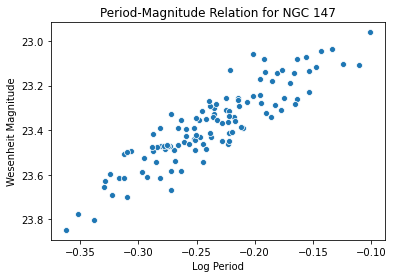

In [92]:
plt.figure()
sns.scatterplot(data = NGC_147_lin_reg, x = 'Log Period', y = 'Wesenheit Magnitude')
plt.gca().invert_yaxis()
plt.title(f'Period-Magnitude Relation for NGC 147');

In [93]:
NGC_185_path = os.path.join('NGC', 'NGC_185.txt')
NGC_185_graph_tab, NGC_185_lin_reg = convert_table(NGC_185_path, 'NGC 185', NGC_147_names, convert = 'hubble')

In [94]:
filter_185 = (NGC_185_graph_tab['Variable Type'] == 'RRab')
outlier_three = (NGC_185_graph_tab['Log Period'] < -0.25) & (NGC_185_graph_tab['Wesenheit Magnitude'] < 23.0)
outlier_four = (NGC_185_graph_tab['Wesenheit Magnitude'] < 22.55)
NGC_185_graph_tab['Outlier'] = filter_185 & (outlier_three | outlier_four | (NGC_185_graph_tab['Log Period'] > 0.0))
display(NGC_185_graph_tab.head())

,Star,Variable Type,Period (Days),Wesenheit Magnitude,V Magnitude,Uncertainty in Wesenheit Magnitude,Log Period,Outlier
0,V001,AC?,0.654,21.928430,24.823813,0.03,-0.184422,False
1,V002,RRc,0.318,23.472728,25.717941,0.03,-0.497573,False
2,V003,RRc,0.264,23.567945,25.788852,0.03,-0.578396,False
3,V004,RRc,0.351,23.149115,25.631305,0.03,-0.454693,False
4,V005,RRab,0.643,22.856055,25.569148,0.03,-0.191789,False


In [95]:
bool_filter_two = NGC_185_graph_tab[NGC_185_graph_tab['Variable Type'] == 'RRab'].reset_index()['Outlier']
NGC_185_lin_reg = NGC_185_lin_reg.loc[~(bool_filter_two), :]
NGC_185_lin_reg = fix_star_code(NGC_185_lin_reg)
display(NGC_185_lin_reg.head())
NGC_185_lin_reg.to_csv('Monte Carlo/NGC_185_mcmc.csv', index = False)

,Star,Wesenheit Magnitude,Uncertainty in Wesenheit Magnitude,Log Period,Star Code
0,V005,22.856055,0.03,-0.191789,0
1,V009,23.341186,0.03,-0.322393,1
2,V010,23.289632,0.03,-0.310691,2
3,V013,23.111675,0.03,-0.232844,3
4,V014,23.231663,0.03,-0.308919,4


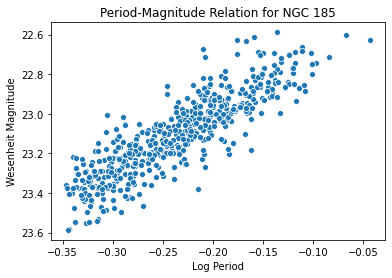

In [96]:
plt.figure()
sns.scatterplot(data = NGC_185_lin_reg, x = 'Log Period', y = 'Wesenheit Magnitude')
plt.gca().invert_yaxis()
plt.title(f'Period-Magnitude Relation for NGC 185');

# Application to NGC 6822

In [97]:
NGC_6822_path = os.path.join('NGC', 'NGC_6822.dat')
NGC_6822_names = ['Star', 'Type', 'Period (Days)', 'B Magnitude', 'V Magnitude']
NGC_6822_graph_tab, NGC_6822_lin_reg = convert_table(NGC_6822_path, 'NGC 6822', NGC_6822_names, 
                                                     usecols = [0, 2, 3, 7, 8], b = True)

In [98]:
display(NGC_6822_lin_reg.head())
NGC_6822_lin_reg.to_csv('Monte Carlo/NGC_6822_mcmc.csv', index = False)

,Star,Wesenheit Magnitude,Uncertainty in Wesenheit Magnitude,Log Period,Star Code
0,V367,22.585806,0.03,-0.240332,0
1,V283,23.654524,0.03,-0.238824,1
2,V241,22.131834,0.03,-0.232844,2
3,V152,23.147974,0.03,-0.228413,3
4,V077,23.549596,0.03,-0.226214,4


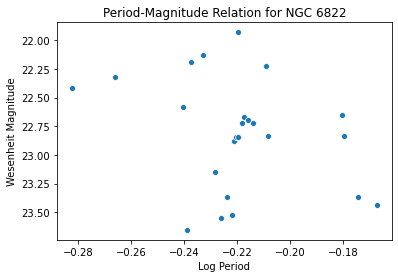

In [99]:
plt.figure()
sns.scatterplot(data = NGC_6822_lin_reg, x = 'Log Period', y = 'Wesenheit Magnitude')
plt.gca().invert_yaxis()
plt.title(f'Period-Magnitude Relation for NGC 6822');

# Application to Fornax

In [100]:
fornax_path = os.path.join('Fornax', 'fornax_catalog.csv')
fornax_names = ['Star', 'g Magnitude', 'r Magnitude', 'i Magnitude', 'z Magnitude', 'Period (Days)', 'Type']
fornax_graph_tab, fornax_lin_reg = convert_table(fornax_path, 'Fornax', fornax_names,  usecols = [0, 8, 9, 10, 11, 14, 37], 
                                                 sep = ',', convert = 'des')

In [101]:
fornax_graph_tab = fornax_graph_tab.dropna()
fornax_graph_tab['Star'] = np.array(['Star ' + elem for elem in np.array(list(range(len(fornax_graph_tab)))).astype(str)])
outlier_fornax = (fornax_graph_tab['Log Period'] > -0.05) | (fornax_graph_tab['Wesenheit Magnitude'] < 19.0)
fornax_graph_tab['Outlier'] = outlier_fornax
fornax_graph_tab.head()

,Star,Variable Type,Period (Days),Wesenheit Magnitude,V Magnitude,Uncertainty in Wesenheit Magnitude,Log Period,Outlier
0,Star 0,ab,0.578921,19.983004,21.369678,0.03,-0.237380,False
1,Star 1,ab,0.601540,20.102479,21.485093,0.03,-0.220736,False
2,Star 2,ab,0.612595,20.157855,21.472124,0.03,-0.212827,False
3,Star 3,ab,0.581395,19.934078,21.328872,0.03,-0.235528,False
4,Star 4,ab,0.569833,20.163488,21.399803,0.03,-0.244252,False


In [102]:
fornax_lin_reg = fornax_lin_reg.dropna()
fornax_lin_reg['Star'] = np.array(['Star ' + elem for elem in np.array(list(range(len(fornax_lin_reg)))).astype(str)])
fornax_lin_reg = fornax_lin_reg.loc[~(fornax_graph_tab['Outlier']), :]
fornax_lin_reg = fix_star_code(fornax_lin_reg)
display(fornax_lin_reg.head())
fornax_lin_reg.to_csv('Monte Carlo/fornax_mcmc.csv', index = False)

,Star,Wesenheit Magnitude,Uncertainty in Wesenheit Magnitude,Log Period,Star Code
0,Star 0,19.983004,0.03,-0.237380,0
1,Star 1,20.102479,0.03,-0.220736,1
2,Star 2,20.157855,0.03,-0.212827,2
3,Star 3,19.934078,0.03,-0.235528,3
4,Star 4,20.163488,0.03,-0.244252,4


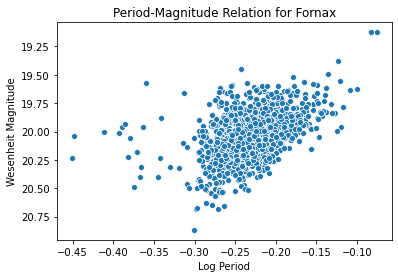

In [103]:
plt.figure()
sns.scatterplot(data = fornax_lin_reg, x = 'Log Period', y = 'Wesenheit Magnitude')
plt.gca().invert_yaxis()
plt.title(f'Period-Magnitude Relation for Fornax');

# Application to ESO294-G010 and ESO410-G005

In [104]:
def eso_analysis(path, name):
    """Converts photometric data to desired format for MCMC model."""

    names = ['Type', 'Star', 'V Magnitude', 'Color', 'Period (Days)']
    pulsation = pd.read_csv(path, header = None, names = names, usecols = [0, 2, 9, 10, 11], sep = '\s{1,}', engine = 'python')
    pulsation['I Magnitude'] = pulsation['V Magnitude'] - pulsation['Color']
    
    lin_reg = pulsation[['Star', 'V Magnitude', 'I Magnitude', 'Color', 'Period (Days)', 'Type']]
    
    lin_reg['Wesenheit Magnitude'] = lin_reg['I Magnitude'] - 1.467 * lin_reg['Color']
    lin_reg['Uncertainty in Wesenheit Magnitude'] = 0.03

    lin_reg['Log Period'] = np.log10(lin_reg['Period (Days)'])
    
    graph_tab = lin_reg.copy().rename({'Type' : 'Variable Type'}, axis = 1)
    graph_tab['Star'] = np.array(['Star ' + elem for elem in np.array(list(range(len(graph_tab)))).astype(str)])

    lin_reg =  lin_reg[lin_reg['Type'] == 'RRab'].reset_index().drop(['index', 'Type'], axis = 1)
    lin_reg['Star'] = np.array(['Star ' + elem for elem in np.array(list(range(len(lin_reg)))).astype(str)])
    
    mean_v_rrl.append([name, np.mean(lin_reg['V Magnitude'])])
    lin_reg = lin_reg[['Star', 'Wesenheit Magnitude', 'Uncertainty in Wesenheit Magnitude', 'Log Period']]
    
    num_stars = len(lin_reg['Star'].unique())
    lookup = dict(zip(lin_reg['Star'].unique(), range(num_stars)))
    lin_reg['Star Code'] = lin_reg['Star'].replace(lookup).values
    
    return graph_tab, lin_reg

In [105]:
ESO_294_path = os.path.join('ESO', 'ESO294-G010.txt')
ESO_294_graph_tab, ESO_294_lin_reg = eso_analysis(ESO_294_path, 'ESO294-G010')
display(ESO_294_lin_reg.head())
ESO_294_lin_reg.to_csv('Monte Carlo/eso_294_mcmc.csv', index = False)

,Star,Wesenheit Magnitude,Uncertainty in Wesenheit Magnitude,Log Period,Star Code
0,Star 0,25.734084,0.03,-0.283997,0
1,Star 1,25.853454,0.03,-0.170053,1
2,Star 2,25.787002,0.03,-0.189029,2
3,Star 3,25.390181,0.03,-0.305307,3
4,Star 4,25.631389,0.03,-0.226799,4


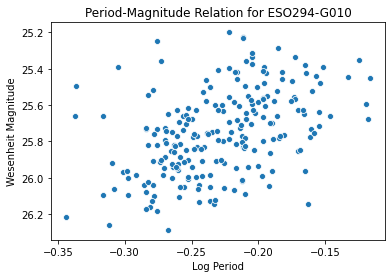

In [106]:
plt.figure()
sns.scatterplot(data = ESO_294_lin_reg, x = 'Log Period', y = 'Wesenheit Magnitude')
plt.gca().invert_yaxis()
plt.title(f'Period-Magnitude Relation for ESO294-G010');

In [107]:
ESO_410_path = os.path.join('ESO', 'ESO410-G005.txt')
ESO_410_graph_tab, ESO_410_lin_reg = eso_analysis(ESO_410_path, 'ESO410-G005')
display(ESO_410_lin_reg.head())
ESO_410_lin_reg.to_csv('Monte Carlo/eso_410_mcmc.csv', index = False)

,Star,Wesenheit Magnitude,Uncertainty in Wesenheit Magnitude,Log Period,Star Code
0,Star 0,25.705094,0.03,-0.249955,0
1,Star 1,25.260988,0.03,-0.172760,1
2,Star 2,25.684246,0.03,-0.164246,2
3,Star 3,25.780596,0.03,-0.226726,3
4,Star 4,25.909596,0.03,-0.243592,4


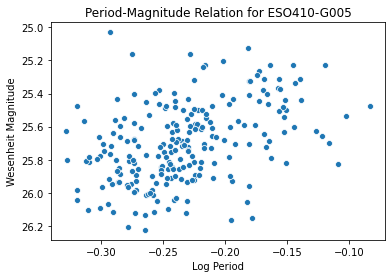

In [108]:
plt.figure()
sns.scatterplot(data = ESO_410_lin_reg, x = 'Log Period', y = 'Wesenheit Magnitude')
plt.gca().invert_yaxis()
plt.title(f'Period-Magnitude Relation for ESO410-G005');

# Application to Phoenix Dwarf Galaxies

In [109]:
phoenix_path = os.path.join('Phoenix', 'phoenix.txt')
phoenix_names = ['Star', 'Type', 'Period (Days)', 'V Magnitude', 'I Magnitude']
phoenix_graph_tab, phoenix_lin_reg = convert_table(phoenix_path, 'Phoenix I', phoenix_names, usecols = [0, 7, 8, 11, 12])

In [110]:
display(phoenix_lin_reg.head())
phoenix_lin_reg.to_csv('Monte Carlo/phoenix_mcmc.csv', index = False)

,Star,Wesenheit Magnitude,Uncertainty in Wesenheit Magnitude,Log Period,Star Code
0,V00030,22.691429,0.03,-0.259637,0
1,V01828,22.501165,0.03,-0.238824,1
2,V01851,22.252262,0.03,-0.182435,2
3,V01852,22.689393,0.03,-0.259637,3
4,V01862,22.395140,0.03,-0.221849,4


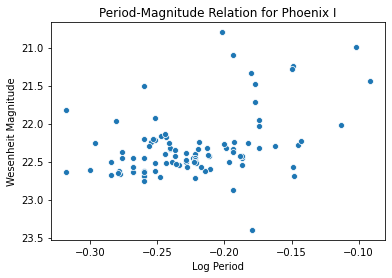

In [111]:
plt.figure()
sns.scatterplot(data = phoenix_lin_reg, x = 'Log Period', y = 'Wesenheit Magnitude')
plt.gca().invert_yaxis()
plt.title(f'Period-Magnitude Relation for Phoenix I');

In [112]:
# Martinez-Vasquez et al. (2019), gri Photometry
phoenix_two_result = calc_wesenheit_des(20.34, 20.22, 20.21, 20.197)
phoenix_two_wesenheit = [phoenix_two_result[1]]
phoenix_two_dict = {'Star' : ['V1'], 'Wesenheit Magnitude' : phoenix_two_wesenheit, 
                    'Uncertainty in Wesenheit Magnitude' : [0.03], 'Log Period' : [np.log10(0.6082742)], 'Star Code' : [0], 
                    'Variable Type' : ['RRab']}
phoenix_two_graph_tab = pd.DataFrame(phoenix_two_dict)
phoenix_two_lin_reg = phoenix_two_graph_tab[phoenix_two_graph_tab['Variable Type'] == 'RRab']
phoenix_two_lin_reg = phoenix_two_lin_reg.reset_index().drop(['Variable Type', 'index'], axis = 1)
mean_v_rrl.append(['Phoenix II', phoenix_two_result[0]])
display(phoenix_two_graph_tab.head())
display(phoenix_two_lin_reg.head())
phoenix_two_lin_reg.to_csv('Monte Carlo/phoenix_two_mcmc.csv', index = False)

,Star,Wesenheit Magnitude,Uncertainty in Wesenheit Magnitude,Log Period,Star Code,Variable Type
0,V1,19.035054,0.03,-0.215901,0,RRab


,Star,Wesenheit Magnitude,Uncertainty in Wesenheit Magnitude,Log Period,Star Code
0,V1,19.035054,0.03,-0.215901,0


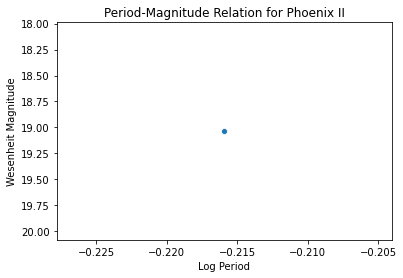

In [113]:
plt.figure()
sns.scatterplot(data = phoenix_two_lin_reg, x = 'Log Period', y = 'Wesenheit Magnitude')
plt.gca().invert_yaxis()
plt.title(f'Period-Magnitude Relation for Phoenix II');

# Application to Carina Dwarf Galaxies

In [114]:
carina_path = os.path.join('Carina', 'carina.txt')
carina_names = ['Star', 'Type', 'Period (Days)', 'V Magnitude', 'I Magnitude']
carina_graph_tab, carina_lin_reg = convert_table(carina_path, 'Carina I', carina_names, usecols = [0, 1, 3, 6, 7])

In [115]:
all_outlier_carina = (carina_graph_tab['Wesenheit Magnitude'] == 
                      carina_graph_tab[carina_graph_tab['Variable Type'] == 'ab']['Wesenheit Magnitude'].min())
carina_graph_tab['Outlier'] = all_outlier_carina
carina_graph_tab.head()

,Star,Variable Type,Period (Days),Wesenheit Magnitude,V Magnitude,Uncertainty in Wesenheit Magnitude,Log Period,Outlier
0,3,ab,0.578658,19.387013,20.771,0.03,-0.237578,False
1,4,c,0.397351,19.572383,20.685,0.03,-0.400826,False
2,7,ab,0.603312,19.453561,20.729,0.03,-0.219458,False
3,10,ab,0.584514,19.438693,20.724,0.03,-0.233205,False
4,14,AC,0.476698,18.792571,19.994,0.03,-0.321757,False


In [116]:
outlier_carina = (carina_lin_reg['Wesenheit Magnitude'] == carina_lin_reg['Wesenheit Magnitude'].min())
carina_lin_reg = carina_lin_reg.loc[~outlier_carina, :]
carina_lin_reg = fix_star_code(carina_lin_reg)
display(carina_lin_reg.head())
carina_lin_reg.to_csv('Monte Carlo/carina_mcmc.csv', index = False)

,Star,Wesenheit Magnitude,Uncertainty in Wesenheit Magnitude,Log Period,Star Code
0,3,19.387013,0.03,-0.237578,0
1,7,19.453561,0.03,-0.219458,1
2,10,19.438693,0.03,-0.233205,2
3,22,19.233729,0.03,-0.195136,3
4,24,19.239932,0.03,-0.208872,4


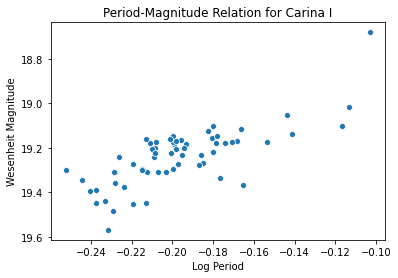

In [117]:
plt.figure()
sns.scatterplot(data = carina_lin_reg, x = 'Log Period', y = 'Wesenheit Magnitude')
plt.gca().invert_yaxis()
plt.title(f'Period-Magnitude Relation for Carina I');

In [118]:
carina_two_path = os.path.join('Carina', 'carina_two.txt')
carina_two_names = ['Star', 'RA', 'Dec', 'Type', 'Period (Days)', 'g Amplitude', 'g Magnitude', 'r Amplitude', 'r Magnitude', 
                    'i Amplitude', 'i Magnitude', 'Distance 1', 'Distance 2']
carina_two_graph_tab, carina_two_lin_reg = convert_table(carina_two_path, 'Carina II', 
                                                         carina_two_names, convert = 'des', z = False)

In [119]:
display(carina_two_lin_reg.head())
carina_two_lin_reg.to_csv('Monte Carlo/carina_two_mcmc.csv', index = False)

,Star,Wesenheit Magnitude,Uncertainty in Wesenheit Magnitude,Log Period,Star Code
0,CarII-V1,16.904895,0.03,-0.192194,0
1,CarII-V3,16.774777,0.03,-0.151749,1


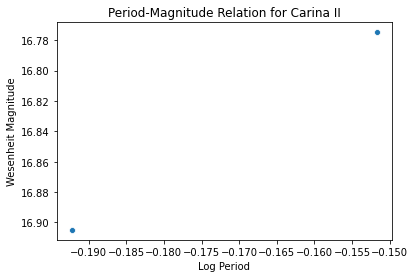

In [120]:
plt.figure()
sns.scatterplot(data = carina_two_lin_reg, x = 'Log Period', y = 'Wesenheit Magnitude')
plt.gca().invert_yaxis()
plt.title(f'Period-Magnitude Relation for Carina II');

# Application to Draco

In [121]:
draco_path = os.path.join('Draco', 'draco.txt')
draco_names = ['Star', 'Period (Days)', 'V Magnitude', 'I Magnitude', 'Type']
draco_graph_tab, draco_lin_reg = convert_table(draco_path, 'Draco', draco_names, usecols = [0, 7, 9, 10, 11])

In [122]:
all_outlier_draco = (draco_graph_tab[draco_graph_tab['Variable Type'] == 'ab']['Wesenheit Magnitude'] < 17.0)
draco_graph_tab['Outlier'] = all_outlier_draco
carina_graph_tab.head()

,Star,Variable Type,Period (Days),Wesenheit Magnitude,V Magnitude,Uncertainty in Wesenheit Magnitude,Log Period,Outlier
0,3,ab,0.578658,19.387013,20.771,0.03,-0.237578,False
1,4,c,0.397351,19.572383,20.685,0.03,-0.400826,False
2,7,ab,0.603312,19.453561,20.729,0.03,-0.219458,False
3,10,ab,0.584514,19.438693,20.724,0.03,-0.233205,False
4,14,AC,0.476698,18.792571,19.994,0.03,-0.321757,False


In [123]:
draco_lin_reg = draco_lin_reg.loc[~(draco_lin_reg['Wesenheit Magnitude'] < 17.0), :]
draco_lin_reg = fix_star_code(draco_lin_reg)
display(draco_lin_reg.head())
draco_lin_reg.to_csv('Monte Carlo/draco_mcmc.csv', index = False)

,Star,Wesenheit Magnitude,Uncertainty in Wesenheit Magnitude,Log Period,Star Code
0,2,18.60315,0.03,-0.227246,0
1,3,18.49513,0.03,-0.187916,1
2,4,18.82315,0.03,-0.203252,2
3,6,18.45980,0.03,-0.158109,3
4,7,18.66046,0.03,-0.208337,4


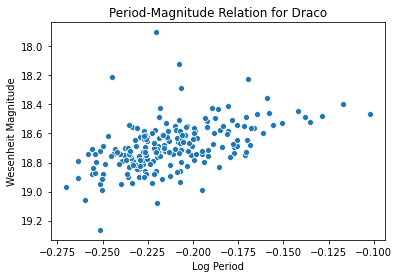

In [124]:
plt.figure()
sns.scatterplot(data = draco_lin_reg, x = 'Log Period', y = 'Wesenheit Magnitude')
plt.gca().invert_yaxis()
plt.title(f'Period-Magnitude Relation for Draco');

# Application to Bootes

In [125]:
bootes_path = os.path.join('Bootes', 'bootes.txt')
bootes_names = ['Star', 'RA Hour', 'RA Min', 'RA Sec', 'Dec Degree', 'Dec Arcmin', 'Dec Arcsec',
               'Type', 'Period (Days)', 'Epoch', 'V Magnitude', 'NV', 'I Magnitude', 'NI', 'V Amplitude']
bootes_graph_tab, bootes_lin_reg = convert_table(bootes_path, 'Bootes I', bootes_names)

In [126]:
display(bootes_lin_reg.head())
bootes_lin_reg.to_csv('Monte Carlo/bootes_mcmc.csv', index = False)

,Star,Wesenheit Magnitude,Uncertainty in Wesenheit Magnitude,Log Period,Star Code
0,V5,18.26985,0.03,-0.186686,0
1,V9,18.36584,0.03,-0.239955,1
2,V10,18.26117,0.03,-0.202040,2
3,V14,18.34051,0.03,-0.143513,3
4,V15,18.11782,0.03,-0.072835,4


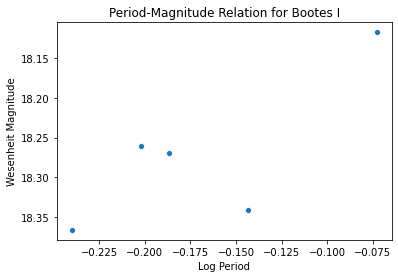

In [127]:
plt.figure()
sns.scatterplot(data = bootes_lin_reg, x = 'Log Period', y = 'Wesenheit Magnitude')
plt.gca().invert_yaxis()
plt.title(f'Period-Magnitude Relation for Bootes I');

# Application to Coma Berenices

In [128]:
# Musella et al. (2009), BVI Photometry
coma_wesenheit = [17.74 - 1.467 * (18.44 - 17.74), 18.20 - 1.467 * (18.69 - 18.20)]
coma_dict = {'Star' : ['V1', 'V2'], 'Wesenheit Magnitude' : coma_wesenheit, 'Uncertainty in Wesenheit Magnitude' : [0.03, 0.03], 
             'Log Period' : [np.log10(0.66971), np.log10(0.31964)], 'Star Code' : [0, 1], 'Variable Type' : ['RRab', 'RRc']}
coma_graph_tab = pd.DataFrame(coma_dict)
coma_lin_reg = coma_graph_tab[coma_graph_tab['Variable Type'] == 'RRab']
coma_lin_reg = coma_lin_reg.reset_index().drop(['Variable Type', 'index'], axis = 1)
mean_v_rrl.append(['Coma Berenices', 18.44])
display(coma_graph_tab.head())
display(coma_lin_reg.head())
coma_lin_reg.to_csv('Monte Carlo/coma_mcmc.csv', index = False)

,Star,Wesenheit Magnitude,Uncertainty in Wesenheit Magnitude,Log Period,Star Code,Variable Type
0,V1,16.71310,0.03,-0.174113,0,RRab
1,V2,17.48117,0.03,-0.495339,1,RRc


,Star,Wesenheit Magnitude,Uncertainty in Wesenheit Magnitude,Log Period,Star Code
0,V1,16.7131,0.03,-0.174113,0


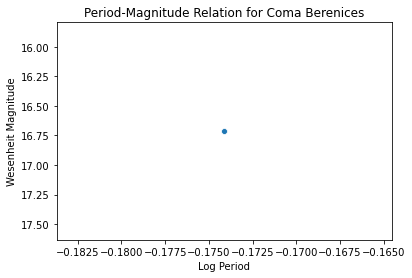

In [129]:
plt.figure()
sns.scatterplot(data = coma_lin_reg, x = 'Log Period', y = 'Wesenheit Magnitude')
plt.gca().invert_yaxis()
plt.title(f'Period-Magnitude Relation for Coma Berenices');

# Application to Grus

In [130]:
# Martinez-Vasquez et al. (2019), gri Photometry
grus_wesenheit = [calc_wesenheit_des(20.93, 20.76, 20.71, 20.697)[1], calc_wesenheit_des(21, 20.87, 20.85, 20.837)[1]]
grus_dict = {'Star' : ['V1', 'V2'], 'Wesenheit Magnitude' : grus_wesenheit, 'Uncertainty in Wesenheit Magnitude' : [0.03, 0.03], 
             'Log Period' : [np.log10(0.8487313), np.log10(0.6355080)], 'Star Code' : [0, 1], 'Variable Type' : ['RRab', 'RRab']}
grus_graph_tab = pd.DataFrame(grus_dict)
grus_lin_reg = grus_graph_tab[grus_graph_tab['Variable Type'] == 'RRab']
grus_lin_reg = grus_lin_reg.reset_index().drop(['Variable Type', 'index'], axis = 1)
grus_mean = 0.5 * (calc_wesenheit_des(20.93, 20.76, 20.71, 20.697)[0] + calc_wesenheit_des(21, 20.87, 20.85, 20.837)[0])
mean_v_rrl.append(['Grus I', grus_mean])
display(grus_graph_tab.head())
display(grus_lin_reg.head())
grus_lin_reg.to_csv('Monte Carlo/grus_mcmc.csv', index = False)

,Star,Wesenheit Magnitude,Uncertainty in Wesenheit Magnitude,Log Period,Star Code,Variable Type
0,V1,19.443445,0.03,-0.071230,0,RRab
1,V2,19.655407,0.03,-0.196879,1,RRab


,Star,Wesenheit Magnitude,Uncertainty in Wesenheit Magnitude,Log Period,Star Code
0,V1,19.443445,0.03,-0.071230,0
1,V2,19.655407,0.03,-0.196879,1


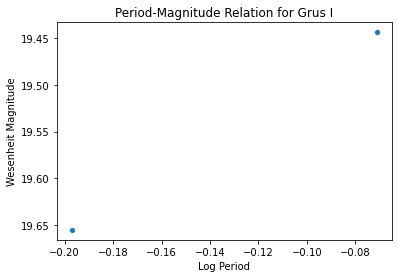

In [131]:
plt.figure()
sns.scatterplot(data = grus_lin_reg, x = 'Log Period', y = 'Wesenheit Magnitude')
plt.gca().invert_yaxis()
plt.title(f'Period-Magnitude Relation for Grus I');

# Application to Canes Venatici

In [132]:
canes_path = os.path.join('Canes Venatici', 'canes_venatici.txt')
canes_names = ['Star', 'ID', 'RA Hour', 'RA Min', 'RA Sec', 'Dec Degree', 'Dec Minute', 'Dec Second',
               'Type', 'Period (Days)', 'Epoch', 'V Magnitude', 'B Magnitude', 'V Amplitude', 'B Amplitude']
canes_graph_tab, canes_lin_reg = convert_table(canes_path, 'Canes Venatici I', canes_names, b = True)

In [133]:
all_outlier_canes = (canes_graph_tab['Variable Type'] == 'RRab') & (canes_graph_tab['Wesenheit Magnitude'] < 20.7)
canes_graph_tab['Outlier'] = all_outlier_canes
canes_graph_tab.head()

,Star,Variable Type,Period (Days),Wesenheit Magnitude,V Magnitude,Uncertainty in Wesenheit Magnitude,Log Period,Outlier
0,V1,RRab,0.59,20.86622,22.12,0.03,-0.229148,False
1,V2,RRab,0.57,20.98738,22.18,0.03,-0.244125,False
2,V3,RRab,0.61,20.98680,22.21,0.03,-0.214670,False
3,V4,RRab,0.60,20.95448,22.30,0.03,-0.221849,False
4,V5,RRab,0.60,21.12028,22.16,0.03,-0.221849,False


In [134]:
outlier_canes = (canes_lin_reg['Wesenheit Magnitude'] < 20.7)
canes_lin_reg = canes_lin_reg.loc[~outlier_canes, :]
canes_lin_reg = fix_star_code(canes_lin_reg)
display(canes_lin_reg.head())
canes_lin_reg.to_csv('Monte Carlo/canes_mcmc.csv', index = False)

,Star,Wesenheit Magnitude,Uncertainty in Wesenheit Magnitude,Log Period,Star Code
0,V1,20.86622,0.03,-0.229148,0
1,V2,20.98738,0.03,-0.244125,1
2,V3,20.98680,0.03,-0.214670,2
3,V4,20.95448,0.03,-0.221849,3
4,V5,21.12028,0.03,-0.221849,4


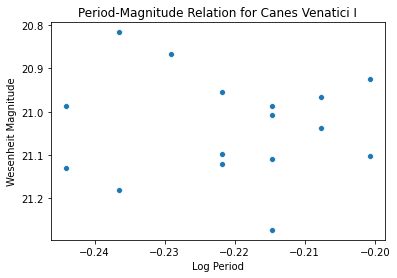

In [135]:
plt.figure()
sns.scatterplot(data = canes_lin_reg, x = 'Log Period', y = 'Wesenheit Magnitude')
plt.gca().invert_yaxis()
plt.title(f'Period-Magnitude Relation for Canes Venatici I');

In [136]:
canes_two_path = os.path.join('Canes Venatici', 'canes_venatici_two.txt')
canes_two_names = ['Star', 'RA', 'Dec', 'Type', 'Period (Days)', 'Epoch', 'V Magnitude', 'B Magnitude', 
                   'V Amplitude', 'B Amplitude']
canes_two_graph_tab, canes_two_lin_reg = convert_table(canes_two_path, 'Canes Venatici II', canes_two_names, b = True)

In [137]:
display(canes_two_lin_reg.head())
canes_two_lin_reg.to_csv('Monte Carlo/canes_two_mcmc.csv', index = False)

,Star,Wesenheit Magnitude,Uncertainty in Wesenheit Magnitude,Log Period,Star Code
0,V2,20.51202,0.03,-0.129011,0


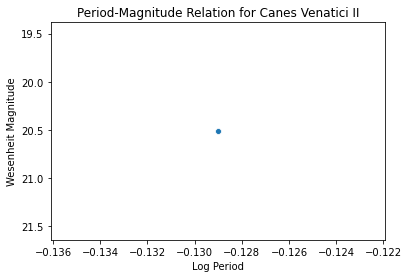

In [138]:
plt.figure()
sns.scatterplot(data = canes_two_lin_reg, x = 'Log Period', y = 'Wesenheit Magnitude')
plt.gca().invert_yaxis()
plt.title(f'Period-Magnitude Relation for Canes Venatici II');

# Application to Hercules

In [139]:
hercules_path = os.path.join('Hercules', 'hercules.txt')
hercules_names = ['Star', 'RA', 'Dec', 'Type', 'Period (Days)', 'Epoch', 'V Magnitude', 'B Magnitude', 
                  'V Amplitude', 'B Amplitude']
hercules_graph_tab, hercules_lin_reg = convert_table(hercules_path, 'Hercules', hercules_names, b = True)

In [140]:
display(hercules_lin_reg.head())
hercules_lin_reg.to_csv('Monte Carlo/hercules_mcmc.csv', index = False)

,Star,Wesenheit Magnitude,Uncertainty in Wesenheit Magnitude,Log Period,Star Code
0,V1,20.01622,0.03,-0.194359,0
1,V6,20.09622,0.03,-0.155020,1
2,V7,19.90506,0.03,-0.168777,2
3,V8,19.90448,0.03,-0.178919,3
4,V9,19.89564,0.03,-0.137040,4


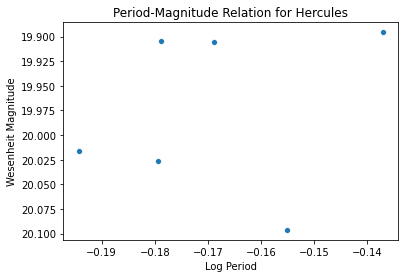

In [141]:
plt.figure()
sns.scatterplot(data = hercules_lin_reg, x = 'Log Period', y = 'Wesenheit Magnitude')
plt.gca().invert_yaxis()
plt.title(f'Period-Magnitude Relation for Hercules');

# Application to Sagittarius

In [142]:
sag_two_path = os.path.join('Sagittarius', 'sagittarius_two.txt')
sag_two_names = ['Star', 'RA', 'Dec', 'Type', 'Period (Days)', 'B Magnitude', 'V Magnitude']
sag_two_graph_tab, sag_two_lin_reg = convert_table(sag_two_path, 'Sagittarius II', 
                                                   sag_two_names, b = True, usecols = [i for i in range(7)])

In [143]:
display(sag_two_lin_reg.head())
sag_two_lin_reg.to_csv('Monte Carlo/sagittarius_two_mcmc.csv', index = False)

,Star,Wesenheit Magnitude,Uncertainty in Wesenheit Magnitude,Log Period,Star Code
0,V3,18.35332,0.03,-0.176787,0


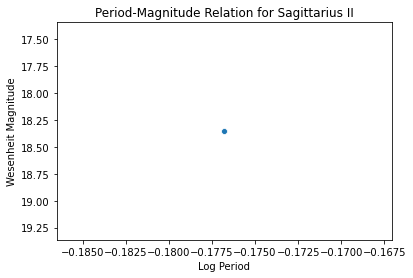

In [144]:
plt.figure()
sns.scatterplot(data = sag_two_lin_reg, x = 'Log Period', y = 'Wesenheit Magnitude')
plt.gca().invert_yaxis()
plt.title(f'Period-Magnitude Relation for Sagittarius II');

# Application to Segue II

In [145]:
# Segue II: Boettcher et al. (2013)
segue_two_wesenheit = 18.246 - 3.058 * (18.620 - 18.246)
segue_two_dict = {'Star' : 1, 'Wesenheit Magnitude' : segue_two_wesenheit, 'Uncertainty in Wesenheit Magnitude' : 0.03, 
              'Log Period' : np.log10(0.748), 'Star Code' : 0}
segue_two_lin_reg = pd.DataFrame(segue_two_dict, index = [0])
segue_two_graph_tab = segue_two_lin_reg.copy()
segue_two_graph_tab['Variable Type'] = 'RRab'
mean_v_rrl.append(['Segue II', 18.246])
display(segue_two_graph_tab.head())
display(segue_two_lin_reg.head())
segue_two_lin_reg.to_csv('Monte Carlo/segue_two_mcmc.csv', index = False)

,Star,Wesenheit Magnitude,Uncertainty in Wesenheit Magnitude,Log Period,Star Code,Variable Type
0,1,17.102308,0.03,-0.126098,0,RRab


,Star,Wesenheit Magnitude,Uncertainty in Wesenheit Magnitude,Log Period,Star Code
0,1,17.102308,0.03,-0.126098,0


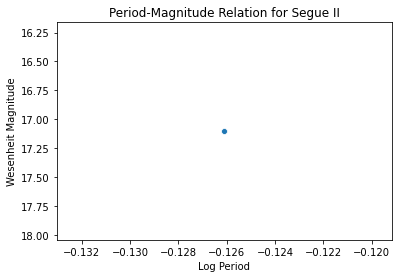

In [146]:
plt.figure()
sns.scatterplot(data = segue_two_lin_reg, x = 'Log Period', y = 'Wesenheit Magnitude')
plt.gca().invert_yaxis()
plt.title(f'Period-Magnitude Relation for Segue II');

# Application to Ursa Major

In [147]:
ursa_major_path = os.path.join('Ursa Major/', 'ursa_major.txt')
ursa_major_names = ['Star', 'RA', 'Dec', 'Type', 'Period (Days)', 'Epoch', 'B Magnitude', 'V Magnitude', 
                    'B Amplitude', 'V Amplitude']
ursa_major_graph_tab, ursa_major_lin_reg = convert_table(ursa_major_path, 'Ursa Major I', ursa_major_names, b = True)

In [148]:
display(ursa_major_lin_reg.head())
ursa_major_lin_reg.to_csv('Monte Carlo/ursa_major_mcmc.csv', index = False)

,Star,Wesenheit Magnitude,Uncertainty in Wesenheit Magnitude,Log Period,Star Code
0,V1,19.70550,0.03,-0.244705,0
1,V2,18.90216,0.03,-0.233587,1
2,V3,19.39086,0.03,-0.191688,2
3,V4,19.07796,0.03,-0.127750,3
4,V5,19.32796,0.03,-0.222088,4


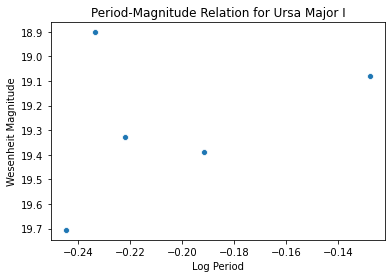

In [149]:
plt.figure()
sns.scatterplot(data = ursa_major_lin_reg, x = 'Log Period', y = 'Wesenheit Magnitude')
plt.gca().invert_yaxis()
plt.title(f'Period-Magnitude Relation for Ursa Major I');

In [150]:
# Ursa Major II: Dall'Ora et al. (2012)
uma_two_wesenheit = 18.39 - 3.058 * (18.61 - 18.39)
uma_two_dict = {'Star' : 1, 'Wesenheit Magnitude' : uma_two_wesenheit, 'Uncertainty in Wesenheit Magnitude' : 0.03, 
              'Log Period' : np.log10(0.6593), 'Star Code' : 0}
ursa_major_two_lin_reg = pd.DataFrame(uma_two_dict, index = [0])
ursa_major_two_graph_tab = ursa_major_two_lin_reg.copy()
ursa_major_two_graph_tab['Variable Type'] = 'RRab'
mean_v_rrl.append(['Ursa Major II', 18.39])
display(ursa_major_two_graph_tab.head())
display(ursa_major_two_lin_reg.head())
ursa_major_two_lin_reg.to_csv('Monte Carlo/ursa_major_two_mcmc.csv', index = False)

,Star,Wesenheit Magnitude,Uncertainty in Wesenheit Magnitude,Log Period,Star Code,Variable Type
0,1,17.71724,0.03,-0.180917,0,RRab


,Star,Wesenheit Magnitude,Uncertainty in Wesenheit Magnitude,Log Period,Star Code
0,1,17.71724,0.03,-0.180917,0


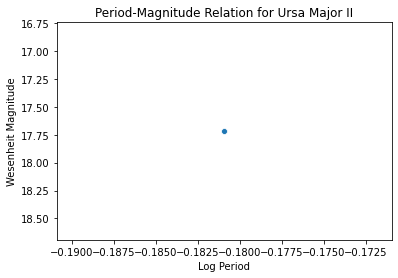

In [151]:
plt.figure()
sns.scatterplot(data = ursa_major_two_lin_reg, x = 'Log Period', y = 'Wesenheit Magnitude')
plt.gca().invert_yaxis()
plt.title(f'Period-Magnitude Relation for Ursa Major II');

# Application to Globular Clusters

In [152]:
NGC_5824_path = os.path.join('Globular Clusters', 'NGC5824.csv')

NGC_5824_names = ['Star', 'Type', 'Period (Days)', 'B Magnitude', 'V Magnitude', 'I Magnitude']

NGC_5824_pulsation = pd.read_csv(NGC_5824_path, header = None, names = NGC_5824_names)

NGC_5824_pulsation.info()
NGC_5824_pulsation.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59 entries, 0 to 58
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Star           59 non-null     object 
 1   Type           59 non-null     object 
 2   Period (Days)  59 non-null     object 
 3   B Magnitude    59 non-null     float64
 4   V Magnitude    59 non-null     float64
 5   I Magnitude    59 non-null     float64
dtypes: float64(3), object(3)
memory usage: 2.9+ KB


,Star,Type,Period (Days),B Magnitude,V Magnitude,I Magnitude
0,V1,RRab,0.597259,18.80,18.37,17.77
1,V2,RRab,0.649413,18.85,18.39,17.75
2,V3,RRab,0.732079,18.90,18.30,17.60
3,V4,RRc,0.334383,18.80,18.40,17.86
4,V5,RRab,0.630958,18.88,18.37,17.71


In [153]:
NGC_5824_lin_reg = NGC_5824_pulsation[NGC_5824_pulsation['Type'] == 'RRab'].reset_index().drop(['index', 'Type'], axis = 1)
NGC_5824_lin_reg = NGC_5824_lin_reg.astype({'Period (Days)' : 'float64'})

NGC_5824_lin_reg['Wesenheit Magnitude'] = (NGC_5824_lin_reg['I Magnitude'] - 1.467 * 
                                           (NGC_5824_lin_reg['V Magnitude'] - NGC_5824_lin_reg['I Magnitude']))

NGC_5824_lin_reg['Uncertainty in Wesenheit Magnitude'] = 0.03

NGC_5824_lin_reg['Log Period'] = np.log10(NGC_5824_lin_reg['Period (Days)'])

NGC_5824_lin_reg = NGC_5824_lin_reg[NGC_5824_lin_reg['Wesenheit Magnitude'] > 16.4]

num_stars = len(NGC_5824_lin_reg['Star'].unique())
NGC_5824_lookup = dict(zip(NGC_5824_lin_reg['Star'].unique(), range(num_stars)))
NGC_5824_lin_reg['Star Code'] = NGC_5824_lin_reg['Star'].replace(NGC_5824_lookup).values

NGC_5824_lin_reg = NGC_5824_lin_reg[['Star', 'Wesenheit Magnitude', 'Uncertainty in Wesenheit Magnitude', 
                                     'Log Period', 'Star Code']]

NGC_5824_lin_reg = NGC_5824_lin_reg.reset_index().drop('index', axis = 1)

display(NGC_5824_lin_reg.head())
NGC_5824_lin_reg.to_csv('Monte Carlo/NGC_5824_mcmc.csv', index = False)

,Star,Wesenheit Magnitude,Uncertainty in Wesenheit Magnitude,Log Period,Star Code
0,V1,16.88980,0.03,-0.223837,0
1,V2,16.81112,0.03,-0.187479,1
2,V3,16.57310,0.03,-0.135442,2
3,V5,16.74178,0.03,-0.200000,3
4,V8,16.77178,0.03,-0.220853,4


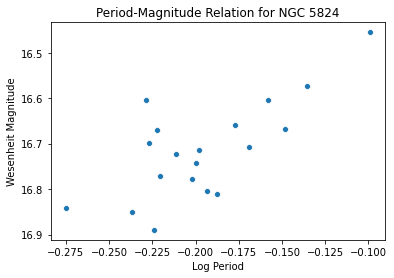

In [154]:
plt.figure()
sns.scatterplot(data = NGC_5824_lin_reg, x = 'Log Period', y = 'Wesenheit Magnitude')
plt.gca().invert_yaxis()
plt.title(f'Period-Magnitude Relation for NGC 5824');

In [155]:
M4_path = os.path.join('Globular Clusters', 'M4.txt')

M4_names = ['Star', 'Period (Days)', 'U Magnitude', 'B Magnitude', 'V Magnitude', 'R Magnitude', 'I Magnitude', 
            'U Amplitude', 'B Amplitude', 'V Amplitude', 'R Amplitude', 'I Amplitude', 'Type']

M4_pulsation = pd.read_csv(M4_path, sep = '\s{1,}', header = None, names = M4_names, engine = 'python')
M4_pulsation.head()

,Star,Period (Days),U Magnitude,B Magnitude,V Magnitude,R Magnitude,I Magnitude,U Amplitude,B Amplitude,V Amplitude,R Amplitude,I Amplitude,Type
0,V1,0.288883,14.56,14.02,13.43,13.00,12.54,0.44,0.57,0.44,0.36,0.24,RRc
1,V2,0.535682,14.50,14.12,13.41,12.91,12.39,1.09,1.26,0.96,0.76,0.61,RRab*
2,V3,0.506678,14.71,13.65,13.01,â€”,12.28,â€”,0.99,â€”,â€”,â€”,RRab
3,V5,0.622401,14.57,14.12,13.37,12.84,12.28,â€”,0.43,0.33,0.26,0.20,RRab
4,V6,0.320515,14.41,14.08,13.45,13.00,12.50,0.63,0.56,0.43,0.35,0.25,RRc


In [156]:
M4_lin_reg = M4_pulsation[['Star', 'Type', 'Period (Days)', 'B Magnitude', 'V Magnitude', 'I Magnitude']]

M4_lin_reg = M4_lin_reg[M4_lin_reg['Type'] == 'RRab'].reset_index().drop(['index', 'Type'], axis = 1)
M4_lin_reg = M4_lin_reg.astype({'Period (Days)' : 'float64', 'V Magnitude' : 'float64', 'I Magnitude' : 'float64'})

M4_lin_reg['Wesenheit Magnitude'] = (M4_lin_reg['I Magnitude'] - 1.467 * 
                                     (M4_lin_reg['V Magnitude'] - M4_lin_reg['I Magnitude']))

M4_lin_reg['Uncertainty in Wesenheit Magnitude'] = 0.03

M4_lin_reg['Log Period'] = np.log10(M4_lin_reg['Period (Days)'])

M4_lin_reg = M4_lin_reg[M4_lin_reg['Wesenheit Magnitude'] < 13.0]

num_stars = len(M4_lin_reg['Star'].unique())
M4_lookup = dict(zip(M4_lin_reg['Star'].unique(), range(num_stars)))
M4_lin_reg['Star Code'] = M4_lin_reg['Star'].replace(M4_lookup).values

M4_lin_reg = M4_lin_reg[['Star', 'Wesenheit Magnitude', 'Uncertainty in Wesenheit Magnitude', 'Log Period', 'Star Code']]

M4_lin_reg = M4_lin_reg.reset_index().drop('index', axis = 1)

display(M4_lin_reg.head())
M4_lin_reg.to_csv('Monte Carlo/M4_mcmc.csv', index = False)

,Star,Wesenheit Magnitude,Uncertainty in Wesenheit Magnitude,Log Period,Star Code
0,V3,11.20909,0.03,-0.295268,0
1,V5,10.68097,0.03,-0.205930,1
2,V7,10.90366,0.03,-0.302085,2
3,V8,10.87767,0.03,-0.293945,3
4,V9,10.83300,0.03,-0.242684,4


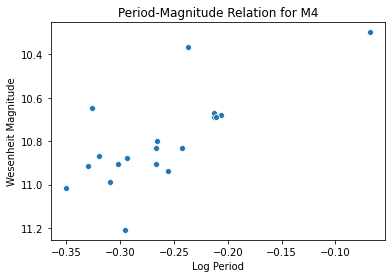

In [157]:
plt.figure()
sns.scatterplot(data = M4_lin_reg, x = 'Log Period', y = 'Wesenheit Magnitude')
plt.gca().invert_yaxis()
plt.title(f'Period-Magnitude Relation for M4');

In [158]:
NGC_362_path = os.path.join('Globular Clusters', 'NGC362.txt')

NGC_362_names = ['Star', 'RA', 'Dec', 'Period (Days)', 'V Magnitude', 'Color (V - I)', 'Amplitude', 'Epoch', 'Type']

NGC_362_pulsation = pd.read_csv(NGC_362_path, sep = '\s{1,}', header = None, names = NGC_362_names, engine = 'python')
NGC_362_pulsation.head()

,Star,RA,Dec,Period (Days),V Magnitude,Color (V - I),Amplitude,Epoch,Type
0,V6,1:01:49.14,âˆ’71:07:36.9,0.30250,18.96,0.71,1.07,3284.1702,RRab
1,V7,1:01:54.55,âˆ’70:46:59.7,0.54753,15.80,-0.12,1.32,2854.2440,RRab
2,V8,1:01:56.71,âˆ’71:10:00.2,0.29218,19.33,0.83,0.98,3284.1647,RRab
3,V15,1:02:24.02,âˆ’70:51:56.4,0.58506,15.55,0.58,0.91,2927.0715,RRab
4,V16,1:02:24.06,âˆ’71:05:13.5,0.59339,16.47,0.11,0.25,2927.1882,RRc


In [159]:
NGC_362_lin_reg = NGC_362_pulsation[['Star', 'Type', 'Period (Days)', 'V Magnitude', 'Color (V - I)']]

NGC_362_lin_reg = NGC_362_lin_reg[NGC_362_lin_reg['Type'] == 'RRab'].reset_index().drop(['index', 'Type'], axis = 1)
NGC_362_lin_reg = NGC_362_lin_reg.astype({'Period (Days)' : 'float64', 'V Magnitude' : 'float64', 'Color (V - I)' : 'float64'})

NGC_362_lin_reg['Wesenheit Magnitude'] = ((NGC_362_lin_reg['V Magnitude'] - NGC_362_lin_reg['Color (V - I)']) 
                                          - 1.467 * NGC_362_lin_reg['Color (V - I)'])

NGC_362_lin_reg['Uncertainty in Wesenheit Magnitude'] = 0.03

NGC_362_lin_reg['Log Period'] = np.log10(NGC_362_lin_reg['Period (Days)'])

num_stars = len(NGC_362_lin_reg['Star'].unique())
NGC_362_lookup = dict(zip(NGC_362_lin_reg['Star'].unique(), range(num_stars)))
NGC_362_lin_reg['Star Code'] = NGC_362_lin_reg['Star'].replace(NGC_362_lookup).values

NGC_362_lin_reg = NGC_362_lin_reg[['Star', 'Wesenheit Magnitude', 'Uncertainty in Wesenheit Magnitude', 'Log Period', 'Star Code']]

NGC_362_lin_reg = NGC_362_lin_reg.reset_index().drop('index', axis = 1)

display(NGC_362_lin_reg.head())
NGC_362_lin_reg.to_csv('Monte Carlo/NGC_362_mcmc.csv', index = False)

,Star,Wesenheit Magnitude,Uncertainty in Wesenheit Magnitude,Log Period,Star Code
0,V6,17.20843,0.03,-0.519275,0
1,V7,16.09604,0.03,-0.261592,1
2,V8,17.28239,0.03,-0.534350,2
3,V15,14.11914,0.03,-0.232800,3
4,V27,14.41452,0.03,-0.309724,4


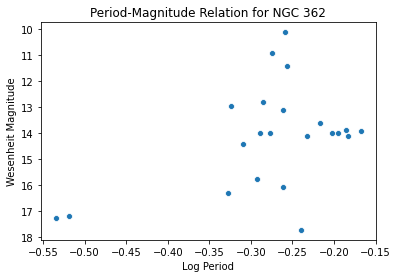

In [160]:
plt.figure()
sns.scatterplot(data = NGC_362_lin_reg, x = 'Log Period', y = 'Wesenheit Magnitude')
plt.gca().invert_yaxis()
plt.title(f'Period-Magnitude Relation for NGC 362');

# Application to Milky Way Field RR Lyrae

In [161]:
# Data from Neeley et al. (2019)
mw_info = pd.read_csv('Milky Way/field_pulsation.csv')
mw_info.head()

,Star,Period (Days),Class,Metallicity
0,AB UMa,0.599581,RRab,-0.49
1,AE Boo,0.314890,RRc,-1.39
2,AM Tuc,0.405802,RRc,-1.49
3,AN Ser,0.522071,RRab,-0.07
4,AP Ser,0.340830,RRc,-1.58


In [162]:
mw_mags = pd.read_csv('Milky Way/field_magnitudes.csv')
mw_mags.head()

,Star,Mean B Magnitude,Uncertainty in Mean B Magnitude,Mean V Magnitude,Uncertainty in Mean V Magnitude,Mean I Magnitude,Uncertainty in Mean I Magnitude
0,AB UMa,11.359,0.009,10.912,0.009,10.342,0.009
1,AE Boo,10.887,0.009,10.640,0.009,10.254,0.009
2,AM Tuc,11.918,0.006,11.626,0.006,11.188,0.006
3,AN Ser,11.321,0.008,10.935,0.008,10.446,0.008
4,AP Ser,11.368,0.008,11.129,0.008,10.765,0.008


In [163]:
mw_complete = mw_info.copy()
mw_complete['Log Period'] = np.log10(mw_complete['Period (Days)'])

mw_complete = mw_complete.reset_index().drop(['index', 'Class', 'Period (Days)'], axis = 1)

mw_num_stars = len(mw_complete['Star'].unique())
mw_lookup = dict(zip(mw_complete['Star'].unique(), range(mw_num_stars)))
mw_complete['Star Code'] = mw_complete['Star'].replace(mw_lookup).values

mw_complete.info()
display(mw_complete.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55 entries, 0 to 54
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Star         55 non-null     object 
 1   Metallicity  55 non-null     float64
 2   Log Period   55 non-null     float64
 3   Star Code    55 non-null     int64  
dtypes: float64(2), int64(1), object(1)
memory usage: 1.8+ KB


,Star,Metallicity,Log Period,Star Code
0,AB UMa,-0.49,-0.222152,0
1,AE Boo,-1.39,-0.501841,1
2,AM Tuc,-1.49,-0.391686,2
3,AN Ser,-0.07,-0.282270,3
4,AP Ser,-1.58,-0.467462,4


In [164]:
mw_lin_reg = mw_info.copy()
mw_lin_reg['Log Period'] = np.log10(mw_lin_reg['Period (Days)'])

mw_lin_reg = mw_lin_reg[mw_lin_reg['Class'] == 'RRab'].reset_index().drop(['index', 'Class', 'Period (Days)'], axis = 1)

mw_num_stars = len(mw_lin_reg['Star'].unique())
mw_lookup = dict(zip(mw_lin_reg['Star'].unique(), range(mw_num_stars)))
mw_lin_reg['Star Code'] = mw_lin_reg['Star'].replace(mw_lookup).values

mw_lin_reg.info()
display(mw_lin_reg.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37 entries, 0 to 36
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Star         37 non-null     object 
 1   Metallicity  37 non-null     float64
 2   Log Period   37 non-null     float64
 3   Star Code    37 non-null     int64  
dtypes: float64(2), int64(1), object(1)
memory usage: 1.3+ KB


,Star,Metallicity,Log Period,Star Code
0,AB UMa,-0.49,-0.222152,0
1,AN Ser,-0.07,-0.282270,1
2,AV Peg,-0.08,-0.408518,2
3,BB Pup,-0.60,-0.318262,3
4,BH Peg,-1.22,-0.193147,4


In [165]:
mw_dr3 = pd.read_csv('Milky Way/milky_way_rrl.csv')
mw_dr3.head()

,Star,RA,Dec,Gaia DR3 Parallax,Gaia DR3 Parallax Error
0,AB UMa,182.810678,47.828758,1.016028,0.021180
1,AE Boo,221.896828,16.845263,1.143184,0.021165
2,AM Tuc,19.627990,-67.918169,0.553873,0.016165
3,AN Ser,238.379390,12.961102,1.026462,0.024778
4,AP Ser,228.503658,9.980885,0.800883,0.019123


In [166]:
bright_stars = ['AE Boo', 'ST Boo', 'TV Boo', 'RZ Cep', 'RR Cet', 'UY Cyg', 'XZ Cyg', 'DX Del', 'SU Dra', 'SW Dra', 'CS Eri', 
                'RX Eri', 'VX Her', 'SV Hya', 'V Ind', 'TT Lyn', 'RV Oct', 'UV Oct', 'AV Peg', 'RU Scl', 'AN Ser', 'T Sex', 
                'V0440 Sgr', 'V0675 Sgr', 'MT Tel', 'AB UMa', 'RV UMa', 'SX UMa', 'UU Vir']

def bright_stars_correction(tab):
    """Reduces parallaxes of MW RRL with G < 11 by 0.015 mas."""
    
    for index, row in tab.iterrows():
        if row['Star'] in bright_stars:
            tab.loc[index, 'Parallax (mas)'] = row['Parallax (mas)'] - 0.015
            
    return tab

In [167]:
mw_parallaxes = pd.read_csv('Milky Way/field_parallax.csv')

for ind, row in mw_dr3.iterrows():
    if row['Star'] in mw_parallaxes['Star'].unique():
        dr3_filt = (mw_parallaxes['Star'] == row['Star'])
        mw_parallaxes.loc[dr3_filt, 'Parallax (mas)'] = row['Gaia DR3 Parallax']
        mw_parallaxes.loc[dr3_filt, 'Parallax Error (mas)'] = row['Gaia DR3 Parallax Error']

mw_parallaxes = bright_stars_correction(mw_parallaxes)
mw_parallaxes['Distance Modulus'] = 5 * np.log10(100 / mw_parallaxes['Parallax (mas)'])
mw_parallaxes['Uncertainty in Distance Modulus'] = ((5 / np.log(10)) * 
                                                    (mw_parallaxes['Parallax Error (mas)'] / mw_parallaxes['Parallax (mas)']))

mw_parallaxes.head()

,Star,Parallax (mas),Parallax Error (mas),E(B - V),Distance Modulus,Uncertainty in Distance Modulus
0,AB UMa,1.001028,0.021180,0.022,9.997768,0.045944
1,AE Boo,1.128184,0.021165,0.023,9.738100,0.040738
2,AM Tuc,0.553873,0.016165,0.023,11.282949,0.063375
3,AN Ser,1.011462,0.024778,0.040,9.975253,0.053196
4,AP Ser,0.800883,0.019123,0.042,10.482156,0.051850


In [168]:
def conv_to_abs_V(app):
    return app - mw_parallaxes['Distance Modulus'] - 3.128 * mw_parallaxes['E(B - V)']

def conv_to_abs_B(app):
    return app - mw_parallaxes['Distance Modulus'] - 4.151 * mw_parallaxes['E(B - V)']

def conv_to_abs_I(app):
    return app - mw_parallaxes['Distance Modulus'] - 1.860 * mw_parallaxes['E(B - V)']

app_mags_VI = (mw_mags['Mean I Magnitude'] - 1.467 * (mw_mags['Mean V Magnitude'] - mw_mags['Mean I Magnitude']))
app_mags_BV = (mw_mags['Mean V Magnitude'] - 3.058 * (mw_mags['Mean B Magnitude'] - mw_mags['Mean V Magnitude']))

app_unc_VI = (mw_mags['Uncertainty in Mean I Magnitude'] - 1.467 * (mw_mags['Uncertainty in Mean V Magnitude'] 
                                                                    - mw_mags['Uncertainty in Mean I Magnitude']))
app_unc_BV = (mw_mags['Uncertainty in Mean V Magnitude'] - 3.058 * (mw_mags['Uncertainty in Mean B Magnitude'] 
                                                                    - mw_mags['Uncertainty in Mean V Magnitude']))

abs_mags_VI = (conv_to_abs_I(mw_mags['Mean I Magnitude']) - 1.467 * (conv_to_abs_V(mw_mags['Mean V Magnitude']) 
                                                                     - conv_to_abs_I(mw_mags['Mean I Magnitude'])))
abs_mags_BV = (conv_to_abs_V(mw_mags['Mean V Magnitude']) - 3.058 * (conv_to_abs_B(mw_mags['Mean B Magnitude']) 
                                                                     - conv_to_abs_V(mw_mags['Mean V Magnitude'])))

In [169]:
mw_parallaxes_VI = mw_parallaxes.copy()
mw_parallaxes_VI['Apparent Wesenheit Magnitude'] = app_mags_VI
mw_parallaxes_VI['Absolute Wesenheit Magnitude'] = abs_mags_VI
mw_parallaxes_VI['Uncertainty in Apparent Wesenheit Magnitude'] = app_unc_VI
mw_parallaxes_VI.head()

,Star,Parallax (mas),Parallax Error (mas),E(B - V),Distance Modulus,Uncertainty in Distance Modulus,Apparent Wesenheit Magnitude,Absolute Wesenheit Magnitude,Uncertainty in Apparent Wesenheit Magnitude
0,AB UMa,1.001028,0.021180,0.022,9.997768,0.045944,9.505810,-0.491955,0.009
1,AE Boo,1.128184,0.021165,0.023,9.738100,0.040738,9.687738,-0.050358,0.009
2,AM Tuc,0.553873,0.016165,0.023,11.282949,0.063375,10.545454,-0.737491,0.006
3,AN Ser,1.011462,0.024778,0.040,9.975253,0.053196,9.728637,-0.246609,0.008
4,AP Ser,0.800883,0.019123,0.042,10.482156,0.051850,10.231012,-0.251137,0.008


In [170]:
mw_parallaxes_BV = mw_parallaxes.copy()
mw_parallaxes_BV['Apparent Wesenheit Magnitude'] = app_mags_BV
mw_parallaxes_BV['Absolute Wesenheit Magnitude'] = abs_mags_BV
mw_parallaxes_BV['Uncertainty in Apparent Wesenheit Magnitude'] = app_unc_BV
mw_parallaxes_BV.head()

,Star,Parallax (mas),Parallax Error (mas),E(B - V),Distance Modulus,Uncertainty in Distance Modulus,Apparent Wesenheit Magnitude,Absolute Wesenheit Magnitude,Uncertainty in Apparent Wesenheit Magnitude
0,AB UMa,1.001028,0.021180,0.022,9.997768,0.045944,9.545074,-0.452687,0.009
1,AE Boo,1.128184,0.021165,0.023,9.738100,0.040738,9.884674,0.146582,0.009
2,AM Tuc,0.553873,0.016165,0.023,11.282949,0.063375,10.733064,-0.549877,0.006
3,AN Ser,1.011462,0.024778,0.040,9.975253,0.053196,9.754612,-0.220627,0.008
4,AP Ser,0.800883,0.019123,0.042,10.482156,0.051850,10.398138,-0.084004,0.008


In [173]:
def convert_mw_lin_reg(tab):
    """Generates calibration linear regression table."""
    
    filt_tab = tab[tab['Star'].isin(mw_lin_reg['Star'].unique())]
    filt_tab = filt_tab[filt_tab['Parallax (mas)'] > 1.0]
    
    lin_reg = mw_lin_reg.copy()
    lin_reg = lin_reg[lin_reg['Star'].isin(filt_tab['Star'].unique())]
    
    lin_reg['Wesenheit Magnitude'] = np.array(filt_tab['Apparent Wesenheit Magnitude'])
    lin_reg['Uncertainty in Wesenheit Magnitude'] = (np.array(filt_tab['Uncertainty in Apparent Wesenheit Magnitude']))
    
    lin_reg['Distance Modulus'] = (np.array(filt_tab['Apparent Wesenheit Magnitude']) - 
                                   np.array(filt_tab['Absolute Wesenheit Magnitude']))
    
    lin_reg['Uncertainty in Distance Modulus'] = np.array(filt_tab['Uncertainty in Distance Modulus'])
    
    lin_reg = lin_reg[['Star', 'Log Period', 'Wesenheit Magnitude', 'Uncertainty in Wesenheit Magnitude',
                       'Distance Modulus', 'Uncertainty in Distance Modulus', 'Metallicity', 'Star Code']]
    
    lin_reg = lin_reg[mw_lin_reg['Star'] != 'RR Lyr'].reset_index().drop('index', axis = 1)
    
    return lin_reg

In [174]:
mw_lin_reg_VI = convert_mw_lin_reg(mw_parallaxes_VI)

display(mw_lin_reg_VI.head())
mw_lin_reg_VI.to_csv('Monte Carlo/milky_way_VI.csv')

,Star,Log Period,Wesenheit Magnitude,Uncertainty in Wesenheit Magnitude,Distance Modulus,Uncertainty in Distance Modulus,Metallicity,Star Code
0,AB UMa,-0.222152,9.505810,0.009,9.997765,0.045944,-0.49,0
1,AN Ser,-0.282270,9.728637,0.008,9.975246,0.053196,-0.07,1
2,AV Peg,-0.408518,9.237500,0.008,9.130393,0.028532,-0.08,2
3,BH Peg,-0.193147,8.913729,0.005,9.638158,0.046360,-1.22,4
4,DX Del,-0.325491,8.545480,0.007,8.793005,0.020967,-0.39,5


In [175]:
mw_lin_reg_BV = convert_mw_lin_reg(mw_parallaxes_BV)

display(mw_lin_reg_BV.head())
mw_lin_reg_BV.to_csv('Monte Carlo/milky_way_BV.csv')

,Star,Log Period,Wesenheit Magnitude,Uncertainty in Wesenheit Magnitude,Distance Modulus,Uncertainty in Distance Modulus,Metallicity,Star Code
0,AB UMa,-0.222152,9.545074,0.009,9.997761,0.045944,-0.49,0
1,AN Ser,-0.282270,9.754612,0.008,9.975239,0.053196,-0.07,1
2,AV Peg,-0.408518,9.275322,0.008,9.130381,0.028532,-0.08,2
3,BH Peg,-0.193147,8.979566,0.005,9.638144,0.046360,-1.22,4
4,DX Del,-0.325491,8.605944,0.007,8.792989,0.020967,-0.39,5


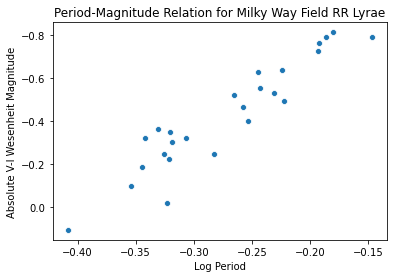

In [176]:
plt.figure()
sns.scatterplot(x = mw_lin_reg_VI['Log Period'], y = mw_lin_reg_VI['Wesenheit Magnitude'] - mw_lin_reg_VI['Distance Modulus'])
plt.gca().invert_yaxis()
plt.ylabel('Absolute V-I Wesenheit Magnitude')
plt.title(f'Period-Magnitude Relation for Milky Way Field RR Lyrae');

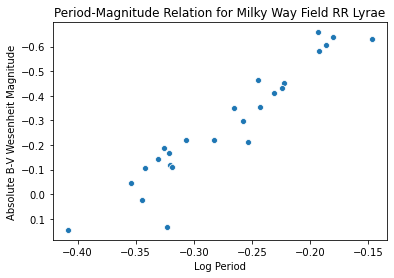

In [177]:
plt.figure()
sns.scatterplot(x = mw_lin_reg_BV['Log Period'], y = mw_lin_reg_BV['Wesenheit Magnitude'] - mw_lin_reg_BV['Distance Modulus'])
plt.gca().invert_yaxis()
plt.ylabel('Absolute B-V Wesenheit Magnitude')
plt.title(f'Period-Magnitude Relation for Milky Way Field RR Lyrae');

In [178]:
photo_names = ['Name 1', 'Name 2', 'U Magnitude', 'U Error', 'B Magnitude', 'B Error', 'V Magnitude', 'V Error','R Magnitude',
               'R Error', 'I Magnitude', 'I Error', 'J Magnitude', 'J Error', 'H Magnitude', 'H Error', 
               'K Magnitude', 'K Error']
proto = pd.read_csv('Milky Way/Neeley/magnitudes.txt', header = None, names = photo_names, sep = '\s{1,}', engine = 'python', 
            usecols = [i for i in range(len(photo_names))])
combined = proto['Name 1'] + ' ' + proto['Name 2']

mw_paper = pd.DataFrame({'Star' : combined})
for filt in ['U', 'B', 'V', 'R', 'I', 'J', 'H', 'K']:
    mw_paper[r'$\langle$' + f'{filt}' + r'$\rangle$'] = (proto[f'{filt} Magnitude'].astype(str).str[:6] + r' $\pm$ ' 
                             + proto[f'{filt} Error'].astype(str).str[:5])
mw_paper = mw_paper.replace({r'- $\pm$ -' : np.nan})

mw_paper = mw_info.merge(mw_paper, on = 'Star').drop('Metallicity', axis = 1)
mw_paper = mw_dr3.merge(mw_paper, on = 'Star').rename({'Gaia DR3 Parallax' : 'Parallax (mas)'}, axis = 1)
mw_paper = bright_stars_correction(mw_paper).rename({'Parallax (mas)' : 'Parallax'}, axis = 1)
mw_paper['Parallax'] = (mw_paper['Parallax'].astype(str).str[:5] + r' $\pm$ ' 
                        + mw_paper['Gaia DR3 Parallax Error'].astype(str).str[:5])
mw_paper = mw_paper.drop('Gaia DR3 Parallax Error', axis = 1)
mw_paper = mw_paper.iloc[:, [0, 5, 4, 3, 7, 8, 10]]
mw_paper['Period (Days)'] = mw_paper['Period (Days)'].values.round(3)
mw_paper['Metallicity'] = mw_info[mw_info['Star'] != 'RR Lyr']['Metallicity'].values
mw_paper.head()

,Star,Class,Period (Days),Parallax,$\langle$B$\rangle$,$\langle$V$\rangle$,$\langle$I$\rangle$,Metallicity
0,AB UMa,RRab,0.600,1.001 $\pm$ 0.021,11.359 $\pm$ 0.009,10.912 $\pm$ 0.009,10.342 $\pm$ 0.009,-0.49
1,AE Boo,RRc,0.315,1.128 $\pm$ 0.021,10.887 $\pm$ 0.009,10.64 $\pm$ 0.009,10.254 $\pm$ 0.009,-1.39
2,AM Tuc,RRc,0.406,0.553 $\pm$ 0.016,11.918 $\pm$ 0.006,11.626 $\pm$ 0.006,11.187 $\pm$ 0.006,-1.49
3,AN Ser,RRab,0.522,1.011 $\pm$ 0.024,11.321 $\pm$ 0.008,10.935 $\pm$ 0.008,10.446 $\pm$ 0.008,-0.07
4,AP Ser,RRc,0.341,0.800 $\pm$ 0.019,11.368 $\pm$ 0.008,11.129 $\pm$ 0.008,10.765 $\pm$ 0.008,-1.58


# Period-Wesenheit Magnitude-Metallicity Relationship

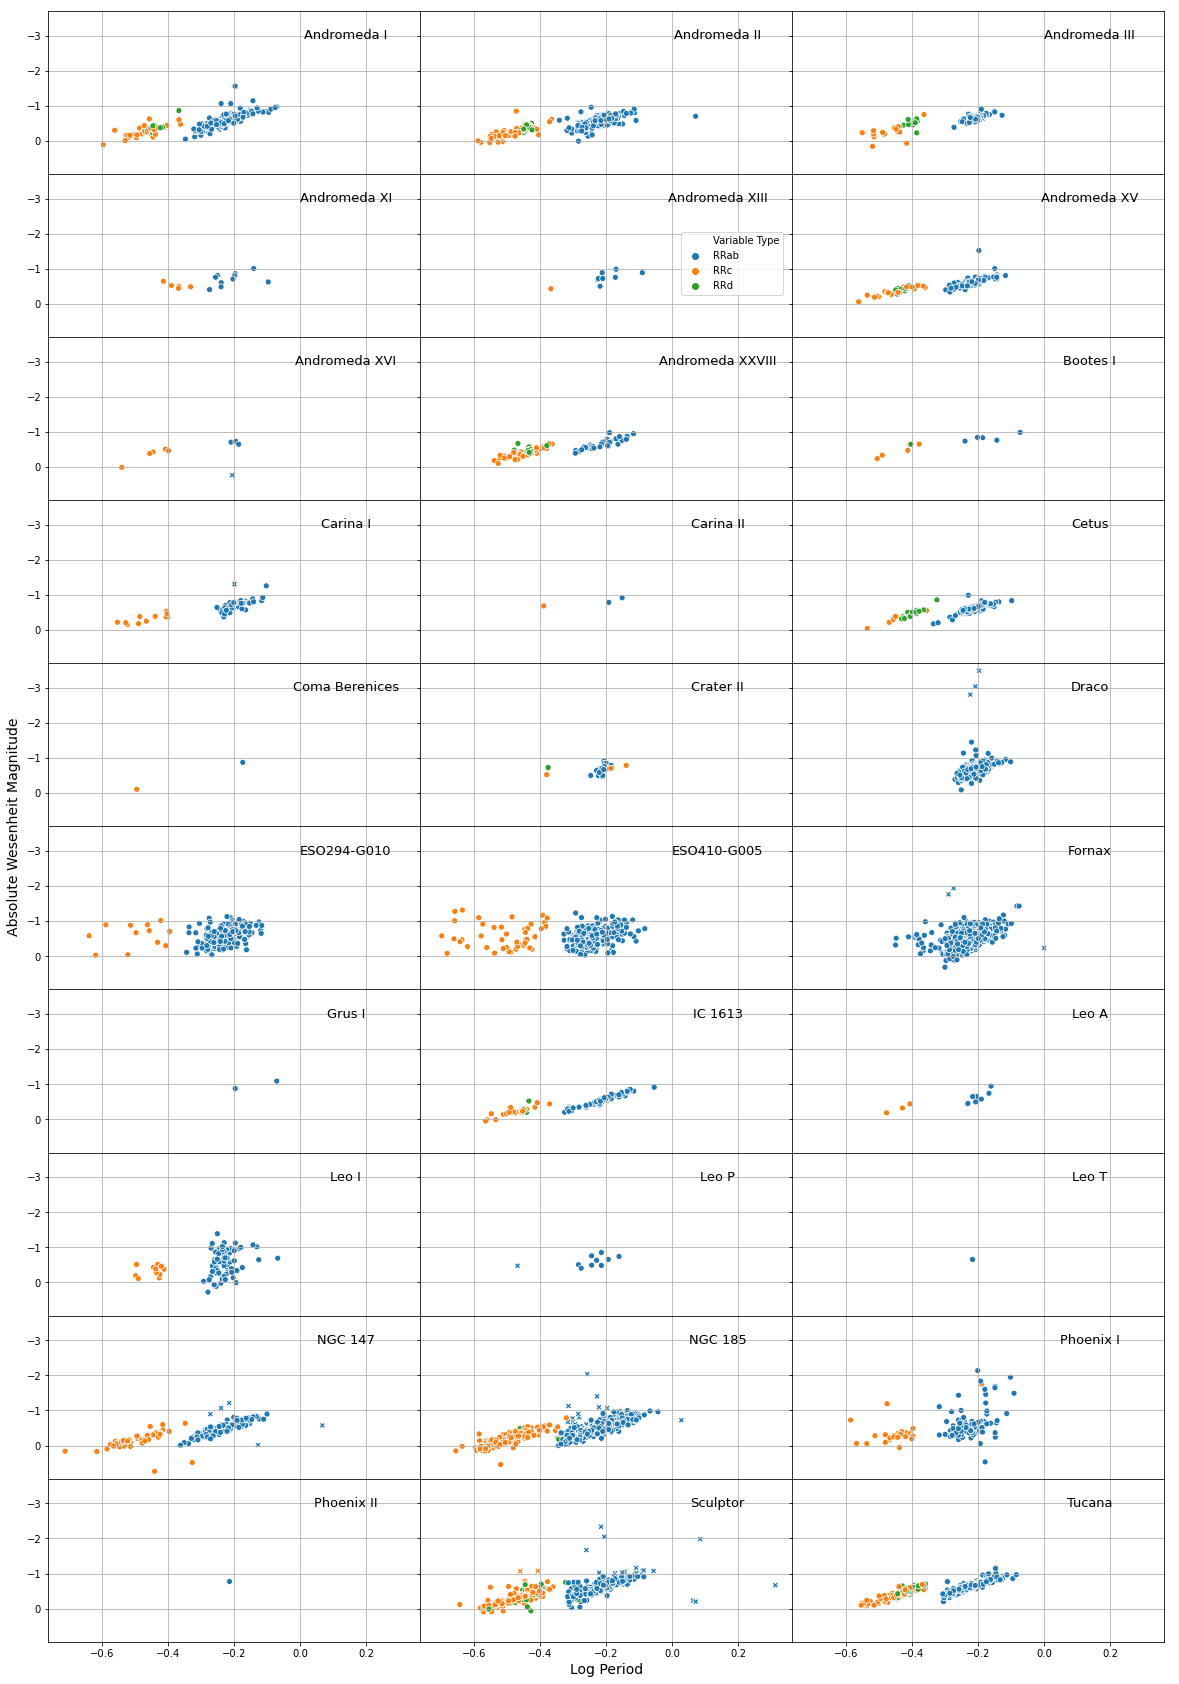

In [179]:
fig, ax = plt.subplots(10, 3, figsize = (20, 30), sharex = True, sharey = True, gridspec_kw = {'wspace' : 0, 'hspace' : 0})
data_repo = [and_one_graph_tab, and_two_graph_tab, and_three_graph_tab, and_eleven_graph_tab, and_thirteen_graph_tab, 
             and_fifteen_graph_tab, and_sixteen_graph_tab, and_twenty_eight_graph_tab, bootes_graph_tab, carina_graph_tab, 
             carina_two_graph_tab, cetus_graph_tab, coma_graph_tab, crater_graph_tab, draco_graph_tab, ESO_294_graph_tab, 
             ESO_410_graph_tab, fornax_graph_tab, grus_graph_tab, ic_graph_tab, leo_a_graph_tab, leo_i_graph_tab, 
             leo_p_graph_tab, leo_t_graph_tab, NGC_147_graph_tab, NGC_185_graph_tab, phoenix_graph_tab, phoenix_two_graph_tab,
             sculptor_graph_tab, tucana_graph_tab]
galaxy_names = ['Andromeda I', 'Andromeda II', 'Andromeda III', 'Andromeda XI', 'Andromeda XIII', 'Andromeda XV', 
                'Andromeda XVI', 'Andromeda XXVIII', 'Bootes I', 'Carina I', 'Carina II', 'Cetus', 'Coma Berenices', 
                'Crater II', 'Draco', 'ESO294-G010', 'ESO410-G005', 'Fornax', 'Grus I', 'IC 1613', 'Leo A', 'Leo I', 
                'Leo P', 'Leo T', 'NGC 147', 'NGC 185', 'Phoenix I', 'Phoenix II', 'Sculptor', 'Tucana']
median_mods = np.loadtxt('moduli.txt')

for data in [and_eleven_graph_tab, and_thirteen_graph_tab, and_sixteen_graph_tab, carina_graph_tab, 
             carina_two_graph_tab, cetus_graph_tab, draco_graph_tab, fornax_graph_tab, ic_graph_tab, leo_a_graph_tab, 
             phoenix_graph_tab, tucana_graph_tab]:
    data.loc[:, 'Variable Type'] = data['Variable Type'].replace({'ab' : 'RRab', 'c' : 'RRc', 'd' : 'RRd'})

for i in range(len(data_repo)):
    data_repo[i] = data_repo[i][data_repo[i]['Variable Type'].isin(np.array(['RRab', 'RRc', 'RRd']))]

for i in range(10):
    for j in range(3):
        lin_tab = data_repo[3*i + j].copy()
        mean_tab = median_mods[3*i + j] * np.ones(len(lin_tab))
        lin_tab['Absolute Wesenheit Magnitude'] = lin_tab['Wesenheit Magnitude'] - mean_tab
        if 'Outlier' in lin_tab.columns:
            sns.scatterplot(data = lin_tab, x = 'Log Period', y = 'Absolute Wesenheit Magnitude', 
                            hue = 'Variable Type', hue_order = ['RRab', 'RRc', 'RRd'], 
                            style = 'Outlier', ax = ax[i][j])
        else:
            sns.scatterplot(data = lin_tab, x = 'Log Period', y = 'Absolute Wesenheit Magnitude', 
                            hue = 'Variable Type', hue_order = ['RRab', 'RRc', 'RRd'], ax = ax[i][j])
        ax[i][j].invert_yaxis()
        ax[i][j].grid()
        ax[i][j].get_legend().remove()
        ax[i][j].set_xlabel('')
        ax[i][j].set_ylabel('')
        ax[i][j].text(0.8, 0.85, f'{galaxy_names[3*i + j]}', horizontalalignment='center', verticalalignment='center', 
                      transform=ax[i][j].transAxes, fontsize = 13)

handles, labels = ax[0][0].get_legend_handles_labels()
plt.legend(handles, labels, loc = 'upper center', bbox_to_anchor = (0.05,0,1.1,0.78),
           bbox_transform = plt.gcf().transFigure, prop={'size': 10})
plt.gca().invert_yaxis()

fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.xlabel("Log Period", fontsize = 14)
plt.ylabel("Absolute Wesenheit Magnitude", fontsize = 14);

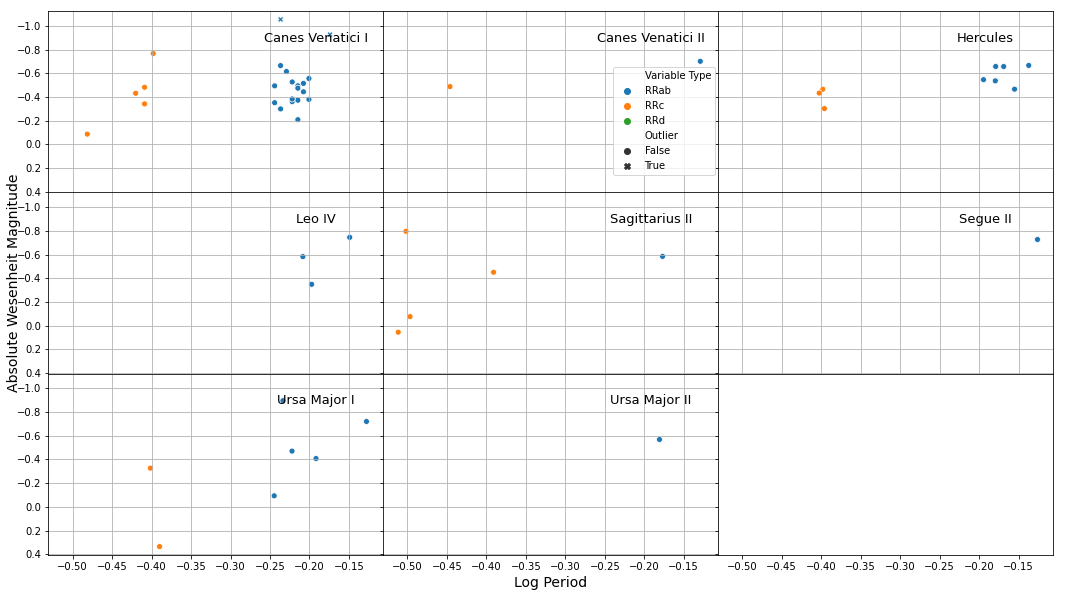

In [180]:
fig, ax = plt.subplots(3, 3, figsize = (18, 10), sharex = True, sharey = True, gridspec_kw = {'wspace' : 0, 'hspace' : 0})
data_repo = [canes_graph_tab, canes_two_graph_tab, hercules_graph_tab, leo_iv_graph_tab, sag_two_graph_tab, 
             segue_two_graph_tab, ursa_major_graph_tab, ursa_major_two_graph_tab]
galaxy_names = ['Canes Venatici I', 'Canes Venatici II', 'Hercules', 'Leo IV', 'Sagittarius II', 
                'Segue II', 'Ursa Major I', 'Ursa Major II']
median_mods = np.loadtxt('moduli.txt')

for data in [sag_two_graph_tab]:
    data.loc[:, 'Variable Type'] = data['Variable Type'].replace({'ab' : 'RRab', 'c' : 'RRc', 'd' : 'RRd'})

for i in range(len(data_repo)):
    data_repo[i] = data_repo[i][data_repo[i]['Variable Type'].isin(np.array(['RRab', 'RRc', 'RRd']))]

for i in range(3):
    for j in range(3):
        if i == 2 and j == 2:
            break
        lin_tab = data_repo[3*i + j].copy()
        mean_tab = median_mods[30 + (3*i + j)] * np.ones(len(lin_tab))
        lin_tab['Absolute Wesenheit Magnitude'] = lin_tab['Wesenheit Magnitude'] - mean_tab
        if 'Outlier' in lin_tab.columns:
            sns.scatterplot(data = lin_tab, x = 'Log Period', y = 'Absolute Wesenheit Magnitude', 
                            hue = 'Variable Type', hue_order = ['RRab', 'RRc', 'RRd'], 
                            style = 'Outlier', ax = ax[i][j])
        else:
            sns.scatterplot(data = lin_tab, x = 'Log Period', y = 'Absolute Wesenheit Magnitude', 
                            hue = 'Variable Type', hue_order = ['RRab', 'RRc', 'RRd'], ax = ax[i][j])
        ax[i][j].invert_yaxis()
        ax[i][j].grid()
        ax[i][j].get_legend().remove()
        ax[i][j].set_xlabel('')
        ax[i][j].set_ylabel('')
        ax[i][j].text(0.8, 0.85, f'{galaxy_names[3*i + j]}', horizontalalignment='center', verticalalignment='center', 
                      transform=ax[i][j].transAxes, fontsize = 13)

handles, labels = ax[0][0].get_legend_handles_labels()
plt.legend(handles, labels, loc = 'upper center', bbox_to_anchor = (0.05,0,1.1,0.81),
           bbox_transform = plt.gcf().transFigure, prop={'size': 10})
plt.gca().invert_yaxis()

fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.xlabel("Log Period", fontsize = 14)
plt.ylabel("Absolute Wesenheit Magnitude", fontsize = 14);

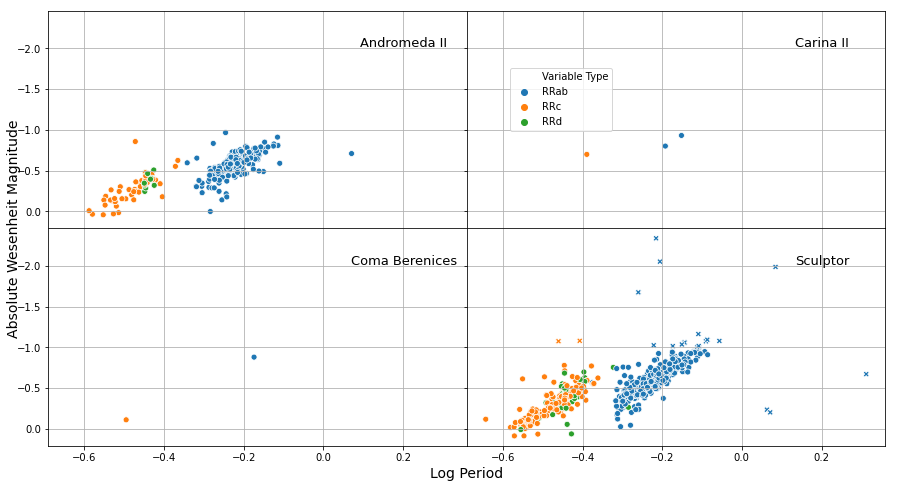

In [181]:
fig, ax = plt.subplots(2, 2, figsize = (15, 8), sharex = True, sharey = True, gridspec_kw = {'wspace' : 0, 'hspace' : 0})
data_repo = [and_two_graph_tab, carina_two_graph_tab, coma_graph_tab, sculptor_graph_tab]
galaxy_names = ['Andromeda II', 'Carina II', 'Coma Berenices', 'Sculptor']
mean_mods = [24.047878, 17.706367, 17.592585, 19.482905]

for data in [carina_two_graph_tab]:
    data.loc[:, 'Variable Type'] = data['Variable Type'].replace({'ab' : 'RRab', 'c' : 'RRc', 'd' : 'RRd'})

for i in range(len(data_repo)):
    data_repo[i] = data_repo[i][data_repo[i]['Variable Type'].isin(np.array(['RRab', 'RRc', 'RRd']))]

for i in range(2):
    for j in range(2):
        lin_tab = data_repo[2*i + j].copy()
        mean_tab = mean_mods[2*i + j] * np.ones(len(lin_tab))
        lin_tab['Absolute Wesenheit Magnitude'] = lin_tab['Wesenheit Magnitude'] - mean_tab
        if 'Outlier' in lin_tab.columns:
            sns.scatterplot(data = lin_tab, x = 'Log Period', y = 'Absolute Wesenheit Magnitude', 
                            hue = 'Variable Type', hue_order = ['RRab', 'RRc', 'RRd'], 
                            style = 'Outlier', markers = {True : 'X', False : 'o'}, ax = ax[i][j])
        else:
            sns.scatterplot(data = lin_tab, x = 'Log Period', y = 'Absolute Wesenheit Magnitude', 
                            hue = 'Variable Type', hue_order = ['RRab', 'RRc', 'RRd'], ax = ax[i][j])
        ax[i][j].grid()
        ax[i][j].get_legend().remove()
        ax[i][j].set_xlabel('')
        ax[i][j].set_ylabel('')
        ax[i][j].text(0.85, 0.85, f'{galaxy_names[2*i + j]}', horizontalalignment='center', verticalalignment='center', 
                      transform=ax[i][j].transAxes, fontsize = 13)

handles, labels = ax[1][1].get_legend_handles_labels()
plt.legend(handles[:4], labels[:4], loc = 'upper center', bbox_to_anchor = (0.05,0,1.1,0.79),
           bbox_transform = plt.gcf().transFigure, prop={'size': 10})
plt.gca().invert_yaxis()

fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.xlabel("Log Period", fontsize = 14)
plt.ylabel("Absolute Wesenheit Magnitude", fontsize = 14);

In [182]:
rrab = []
data_repo = [and_one_graph_tab, and_two_graph_tab, and_three_graph_tab, and_eleven_graph_tab, and_thirteen_graph_tab, 
             and_fifteen_graph_tab, and_sixteen_graph_tab, and_twenty_eight_graph_tab, bootes_graph_tab, canes_graph_tab, 
             canes_two_graph_tab, carina_graph_tab, carina_two_graph_tab, cetus_graph_tab, coma_graph_tab, crater_graph_tab, 
             draco_graph_tab, ESO_294_graph_tab, ESO_410_graph_tab, fornax_graph_tab, grus_graph_tab, hercules_graph_tab,
             ic_graph_tab, leo_a_graph_tab, leo_i_graph_tab, leo_iv_graph_tab, leo_p_graph_tab, leo_t_graph_tab, 
             NGC_147_graph_tab, NGC_185_graph_tab, phoenix_graph_tab, phoenix_two_graph_tab, sag_two_graph_tab, 
             sculptor_graph_tab, segue_two_graph_tab, tucana_graph_tab, ursa_major_graph_tab, ursa_major_two_graph_tab]
for tab in data_repo:
    filte = tab[tab['Variable Type'] == 'RRab']
    if 'Outlier' in filte.columns:
        filte = filte[filte['Outlier'] == False]
    rrab.append(len(filte))
print(rrab)

[229, 187, 84, 10, 8, 80, 3, 35, 5, 16, 1, 62, 2, 147, 1, 28, 211, 219, 224, 1386, 2, 6, 61, 7, 68, 3, 9, 1, 113, 531, 95, 1, 1, 271, 1, 216, 5, 1]


In [183]:
summary['Number of RRab'] = np.array(rrab)
summary = summary[['Galaxy Name', 'Apparent V Magnitude', 'Number of RRab', 'Number of RRL', 'Observed Filters', 
                   'Transformed Filters', 'References']]
summary.head()

,Galaxy Name,Apparent V Magnitude,Number of RRab,Number of RRL,Observed Filters,Transformed Filters,References
0,Andromeda I,12.7 $\pm$ 0.1,229,296,"F475W, F814W","V, I",Martinez-Vasquez et al. (2017)
1,Andromeda II,11.7 $\pm$ 0.2,187,251,"F475W, F814W","V, I",Martinez-Vasquez et al. (2017)
2,Andromeda III,14.4 $\pm$ 0.3,84,111,"F475W, F814W","V, I",Martinez-Vasquez et al. (2017)
3,Andromeda XI,17.5 $\pm$ 1.2,10,15,"F606W, F814W","V, I",Yang and Sarajedini (2012)
4,Andromeda XIII,18.1 $\pm$ 1.2,8,9,"F606W, F814W","V, I",Yang and Sarajedini (2012)


# 3D Plots of Galaxies

In [184]:
alphabetized_moduli = [24.37, 24.03, 24.27, 24.37, 24.44, 24.32, 23.58, 24.36, 19.09, 21.43, 21.21, 19.93, 17.68, 24.34, 
                       17.57, 20.18, 19.35, 26.32, 26.25, 20.55, 20.52, 20.56, 24.26, 24.30, 21.80, 20.99, 26.06, 23.11, 
                       23.85, 23.58, 22.92, 19.81, 18.94, 19.47, 17.83, 24.67, 19.81, 18.30]

def calc_3D_dist():
    """
    Calculates 3D distances (in kpc) to Local Group galaxies based on RA, Dec, and distance values.
    """
    
    from astropy.coordinates import SkyCoord
    from astropy import units as u
    
    file = open('LocalGroupGalaxies.dat')
    data = file.readlines()
    file.close()
    
    names, ras, decs, distmods, distmod_lower, distmod_upper = [], [], [], [], [], []
    
    coordinates = []
    for i, line in enumerate(data):
        tokens = line.split()
        names.append(tokens[0])
        if i < len(alphabetized_moduli):
            distmod = alphabetized_moduli[i]
        else:
            distmod = line.split()[7]
        d_kpc = 10**(float(distmod)/5 - 2)
        c = SkyCoord("%sh%sm%ss %sd%sm%ss" % (line.split()[1], line.split()[2], line.split()[3], 
                                              line.split()[4], line.split()[5], line.split()[6]), 
                     distance = d_kpc*u.kpc, frame='icrs')
        coordinates.append(c)
    
    andromeda = coordinates[-2]
    origin = SkyCoord(0 * u.deg, 0 * u.deg, distance = 0 * u.kpc, frame = 'icrs')
    
    dist_mws, dist_ands = [], []
    for c in coordinates:
        dist_mw = c.separation_3d(origin)
        dist_and = c.separation_3d(andromeda)
        dist_mws.append(dist_mw.value)
        dist_ands.append(dist_and.value)
    
    return np.array(names)[:-2], np.array(dist_mws)[:-2], np.array(dist_ands)[:-2]

In [185]:
names, dist_mws, dist_ands = calc_3D_dist()
summary_3d = pd.concat([galaxies_VI_table, galaxies_BV_table], ignore_index = True).sort_values('Galaxy Name')
dist_3d_table = pd.DataFrame({'Names' : names, 'Distance from Milky Way (kpc)' : np.rint(dist_mws).astype(int), 
                              'Distance from Andromeda (kpc)' : np.rint(dist_ands).astype(int),
                              'Apparent V Magnitude': summary_3d['Apparent V Magnitude']})
dist_3d_table.head()

,Names,Distance from Milky Way (kpc),Distance from Andromeda (kpc),Apparent V Magnitude
0,AndI,748,52,12.7
1,AndII,640,186,11.7
2,AndIII,714,89,14.4
3,AndXI,748,104,17.5
4,AndXIII,773,114,18.1


In [186]:
# Original Code by Kareem El-Badry
# Modified by Pranav Nagarajan
    
def rotate_to_vectors(X, v1, v2, v3):
    """
    Rotates the coordinate axes such that v1 is mapped to the x axis,
    v2 is mapped to the y axis, and v3 is mapped to the z axis. If v1, v2, and v3
    are take as the eigenvectors corresponding to the smallest, medium, and 
    largest eigenvalues of the moment of inertia tensor, this will transform 
    X into the eigenbasis. If v1, v2, and v3 are not perpendicular, beware! It 
    will tell you. 
    
    Returns an array of positions in the same format as X.
    
    parameters
    ------------
    X: array of positions such that X[0] = [x0, y0, z0] and X[1] = [x1, y1, z1], etc.
    v1: array of floats of length 3, which will be mapped to (1, 0, 0) in the 
        rotation.
    v2: will be mapped to (0, 1, 0).
    v3: will be mapped to (0, 0, 1).
    
    returns
    ------------
    new_xyz: array of positions in new rotates basis such that 
             X[0] = [x0, y0, z0] and X[1] = [x1, y1, z1], etc.
    """
    
    if (np.abs(np.dot(v1, v2)) > 1e-6) | (np.abs(np.dot(v1, v3)) > 1e-6) | (np.abs(np.dot(v2, v3)) > 1e-6):
        print("Oh no! The basis you gave me isn't orthogonal. All bets are off.")
    
    N = [v1, v2, v3]
            
    new_xyz = np.dot(N, X.T)
    
    return new_xyz.T


def map_local_group():
    """
    Creates 3D maps of Local Group based on RA, Dec, and distance values.
    """
    
    f = open('LocalGroupGalaxies.dat')
    d = f.readlines()
    f.close()

    names, ras, decs, distmods, distmod_lower, distmod_upper = [], [], [], [], [], []
    from astropy.coordinates import SkyCoord
    from astropy import units as u
    all_c = []
    for i, line in enumerate(d):
        p = line.split()
        names.append(p[0])
        if i < len(alphabetized_moduli):
            distmod = alphabetized_moduli[i]
        else:
            distmod = line.split()[7]
        d_kpc = 10**(float(distmod)/5 - 2)
        c = SkyCoord("%sh%sm%ss %sd%sm%ss" % (line.split()[1], line.split()[2], line.split()[3], 
                                              line.split()[4], line.split()[5], line.split()[6]), 
                     distance = d_kpc*u.kpc, frame='icrs')
        all_c.append(c)
    
    all_ra = np.array([x.ra.deg for x in all_c])
    all_dec = np.array([x.dec.deg for x in all_c])
    all_dist =  np.array([x.distance.kpc for x in all_c])
    
    c = SkyCoord(ra = all_ra*u.deg, dec = all_dec*u.deg, distance = all_dist*u.kpc)
    x, y, z = c.galactocentric.x.value, c.galactocentric.y.value, c.galactocentric.z.value
    
    X = np.vstack([x, y, z]).T
    
    v1 = X[-2]/np.linalg.norm(X[-2]) # M31 
    vm33= X[-1]/np.linalg.norm(X[-1])
    v_perp = np.cross(v1, vm33)/np.linalg.norm(np.cross(v1, vm33))
    vy = np.cross(v1, v_perp)/np.linalg.norm(np.cross(v1, v_perp))
    
    Xrot = rotate_to_vectors(X, v1 = v1, v2 = vy, v3 = v_perp)
    x, y, z = Xrot.T

    # Figure 1: Zoomed Out
    fig = plt.figure(figsize = (12, 8))
    ax = fig.add_subplot(111, projection='3d')
    v_mags = dist_3d_table['Apparent V Magnitude'].values
    v_mags = np.append(v_mags, [3.44, 5.72])
    norm = matplotlib.colors.Normalize(vmin = min(v_mags), vmax = max(v_mags))
    ax.scatter(x, y, z, c=plt.cm.RdBu(norm(v_mags)), marker='o')
    ax.scatter(x, y, z*0, c=plt.cm.RdBu(norm(v_mags)), marker='o', s=2) # show position on x-y plane
    cbar = fig.colorbar(plt.cm.ScalarMappable(cmap=plt.cm.RdBu, norm = norm))

    r_vals = [300, 600, 900, 1200, 1500]
    for r in r_vals:
        phis = np.linspace(0, 2*np.pi, 100)
        x_circle = r*np.cos(phis)
        y_circle = r*np.sin(phis)
        z_circle = np.zeros_like(x_circle)
        ax.plot(x_circle, y_circle, z_circle, 'b:')
        phi0 = 235*np.pi/180
        ax.text((r+200)*np.cos(phi0), (r+200)*np.sin(phi0), 0, '%d kpc' % r, color = 'b', fontsize=10)
    
    for i, name in enumerate(names):
        if z[i] > 0:
            ax.plot([x[i], x[i]], [y[i], y[i]], [z[i], 0], 'r', lw=0.5)
        else:
            ax.plot([x[i], x[i]], [y[i], y[i]], [z[i], 0], 'r:', lw=0.5)
    
    ax.set_xlim(-1500, 1500)
    ax.set_ylim(-1500, 1500)
    ax.set_zlim(-1500, 1500)
    ax.set_xlabel(r'$x\,\,[\rm kpc]$', fontsize=20)
    ax.set_ylabel(r'$y\,\,[\rm kpc]$', fontsize=20)
    ax.set_zlabel(r'$z\,\,[\rm kpc]$', fontsize=20)
    
    for i, name in enumerate(names):
        if name in ['LeoP', 'LeoA', 'Cetus', 'Tucana', 'PhoenixI', 'IC1613'] or 'ESO410' in name:
            ax.text(x[i] + 30, y[i] + 30, z[i] - 150, name, fontsize=8, alpha=0.75)
        if 'ESO294' in name:
            ax.text(x[i] - 200, y[i] - 200, z[i] - 150, name, fontsize=8, alpha=0.75)
    ax.grid(False)
    
    # Figure 2: Milky Way Environment
    msk = np.sqrt(x**2 + y**2 + z**2) < 300
    fig = plt.figure(figsize = (12, 8))
    ax = fig.add_subplot(111, projection='3d')    
    ax.scatter(x[msk], y[msk], z[msk], c=plt.cm.RdBu(norm(v_mags[msk])), marker='o')
    ax.scatter(x[msk], y[msk], z[msk]*0, c=plt.cm.RdBu(norm(v_mags[msk])), marker='o', s=2) # show position on x-y plane
    cbar = fig.colorbar(plt.cm.ScalarMappable(cmap=plt.cm.RdBu, norm = norm))

    r_vals = [100, 200, 300]
    for r in r_vals:
        phis = np.linspace(0, 2*np.pi, 100)
        x_circle = r*np.cos(phis)
        y_circle = r*np.sin(phis)
        z_circle = np.zeros_like(x_circle)
        ax.plot(x_circle, y_circle, z_circle, 'b:')
        phi0 = 235*np.pi/180
        ax.text((r+100)*np.cos(phi0), (r+100)*np.sin(phi0), 0, '%d kpc' % r, color = 'b', fontsize=10)
    
    for i, name in enumerate(names):
        if not msk[i]: continue
        if z[i] > 0:
            ax.plot([x[i], x[i]], [y[i], y[i]], [z[i], 0], 'r', lw=0.5)
        else:
            ax.plot([x[i], x[i]], [y[i], y[i]], [z[i], 0], 'r:', lw=0.5)
        if name in ['Fornax', 'CanesVenaticiI']:
            ax.text(x[i] + 10, y[i] + 10, z[i] - 5, name, fontsize=8, alpha=0.75)
        if name in ['LeoI', 'LeoIV', 'CraterII', 'GrusI', 'CanesVenaticiII']:
            ax.text(x[i] + 10, y[i] + 10, z[i] - 15, name, fontsize=8, alpha=0.75)
        
    ax.set_xlim(-300, 300)
    ax.set_ylim(-300, 300)
    ax.set_zlim(-300, 300)
    ax.set_xlabel(r'$x\,\,[\rm kpc]$', fontsize=20)
    ax.set_ylabel(r'$y\,\,[\rm kpc]$', fontsize=20)
    ax.set_zlabel(r'$z\,\,[\rm kpc]$', fontsize=20)
    
    ax.grid(False)
    
    # Figure 3: 100 kpc
    msk = np.sqrt(x**2 + y**2 + z**2) < 100
    fig = plt.figure(figsize = (12, 8))
    ax = fig.add_subplot(111, projection='3d')    
    ax.scatter(x[msk], y[msk], z[msk], c=plt.cm.RdBu(norm(v_mags[msk])), marker='o')
    ax.scatter(x[msk], y[msk], z[msk]*0, c=plt.cm.RdBu(norm(v_mags[msk])), marker='o', s=2) # show position on x-y plane
    cbar = fig.colorbar(plt.cm.ScalarMappable(cmap=plt.cm.RdBu, norm = norm))

    r_vals = [30, 60, 90]
    for r in r_vals:
        phis = np.linspace(0, 2*np.pi, 100)
        x_circle = r*np.cos(phis)
        y_circle = r*np.sin(phis)
        z_circle = np.zeros_like(x_circle)
        ax.plot(x_circle, y_circle, z_circle, 'b:')
        phi0 = 235*np.pi/180
        ax.text((r+30)*np.cos(phi0), (r+30)*np.sin(phi0), 0, '%d kpc' % r, color = 'b', fontsize=10)
    
    for i, name in enumerate(names):
        if not msk[i]: continue
        if z[i] > 0:
            ax.plot([x[i], x[i]], [y[i], y[i]], [z[i], 0], 'r', lw=0.5)
        else:
            ax.plot([x[i], x[i]], [y[i], y[i]], [z[i], 0], 'r:', lw=0.5)
        if name not in ['UrsaMajorII']:
            ax.text(x[i] + 2, y[i] + 2, z[i] - 5, name, fontsize=8, alpha=0.75)
        else:
            ax.text(x[i] + 2, y[i] + 2, z[i] + 5, name, fontsize=8, alpha=0.75)
        
    ax.set_xlim(-100, 100)
    ax.set_ylim(-100, 100)
    ax.set_zlim(-100, 100)
    ax.set_xlabel(r'$x\,\,[\rm kpc]$', fontsize=20)
    ax.set_ylabel(r'$y\,\,[\rm kpc]$', fontsize=20)
    ax.set_zlabel(r'$z\,\,[\rm kpc]$', fontsize=20)
    
    ax.grid(False)
    
    # Figure 4: M31 Environment
    msk = np.sqrt((x-780)**2 + y**2 + z**2) < 300
    fig = plt.figure(figsize = (12, 8))
    ax = fig.add_subplot(111, projection='3d')    
    ax.scatter(x[msk], y[msk], z[msk], c=plt.cm.RdBu(norm(v_mags[msk])), marker='o')
    ax.scatter(x[msk], y[msk], z[msk]*0, c=plt.cm.RdBu(norm(v_mags[msk])), marker='o', s=2) # show position on x-y plane
    cbar = fig.colorbar(plt.cm.ScalarMappable(cmap=plt.cm.RdBu, norm = norm))

    r_vals = [100, 200, 300]
    for r in r_vals:
        phis = np.linspace(0, 2*np.pi, 100)
        x_circle = r*np.cos(phis)
        y_circle = r*np.sin(phis)
        z_circle = np.zeros_like(x_circle)
        ax.plot(x_circle+780, y_circle, z_circle, 'b:')
        phi0 = 235*np.pi/180
        ax.text((r+50)*np.cos(phi0)+780, (r+50)*np.sin(phi0), 0, '%d kpc' % r, color = 'b', fontsize=10)
    
    for i, name in enumerate(names):
        if not msk[i]: continue
        if z[i] > 0:
            ax.plot([x[i], x[i]], [y[i], y[i]], [z[i], 0], 'r', lw=0.5)
        else:
            ax.plot([x[i], x[i]], [y[i], y[i]], [z[i], 0], 'r:', lw=0.5)
        if name not in ['AndIII', 'AndXIII', 'M33']:
            ax.text(x[i] + 5, y[i] + 5, z[i] - 10, name, fontsize=8, alpha=0.75)
        elif name not in ['M33']:
            ax.text(x[i] + 5, y[i] + 5, z[i] - 25, name, fontsize=8, alpha=0.75)
        else:
            ax.text(x[i] + 2, y[i] + 2, z[i] - 35, name, fontsize=8, alpha=0.75)
        
    ax.set_xlim(780-300, 780+300)
    ax.set_ylim(-300, 300)
    ax.set_zlim(-300, 300)
    ax.set_xlabel(r'$x\,\,[\rm kpc]$', fontsize=20)
    ax.set_ylabel(r'$y\,\,[\rm kpc]$', fontsize=20)
    ax.set_zlabel(r'$z\,\,[\rm kpc]$', fontsize=20)
    
    ax.grid(False)

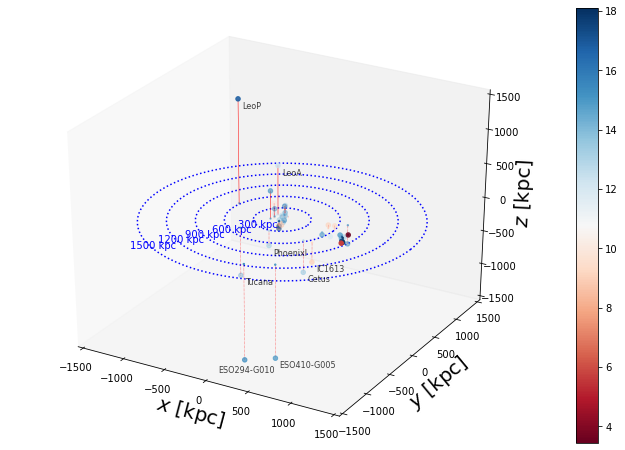

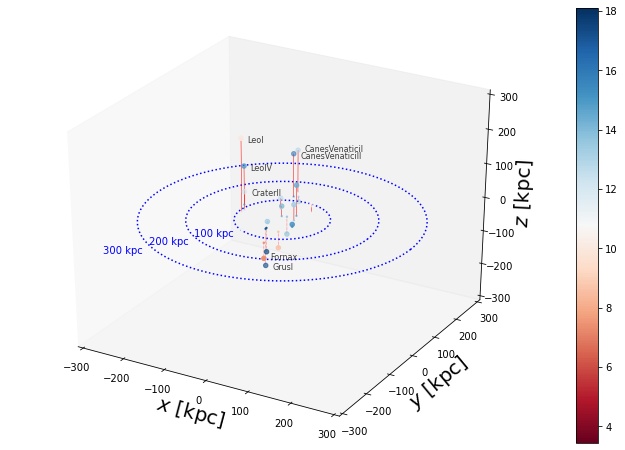

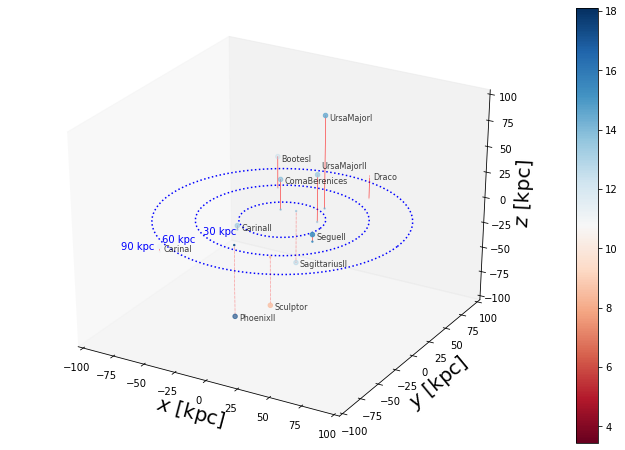

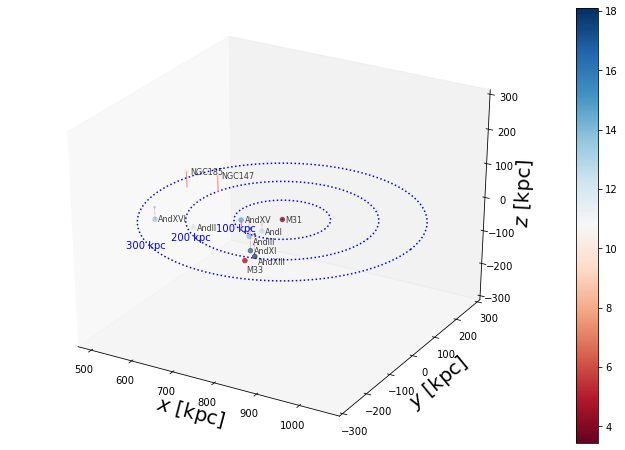

In [187]:
map_local_group()

# Absolute V Magnitude - Metallicity Relationship

In [188]:
# Caretta et al. (2000)
# Metallicity - Luminosity Relationship from Kirby et al. (2013)
def caretta(Mv, mv_RR, Av):
    mv_RR = mv_RR - 0.071
    log_term = -6 - 0.4 * (Mv - 4.83 - Av)
    metal = -1.68 + 0.29 * log_term
    Mv_RR = 0.18 * (metal + 1.5) + 0.57
    return mv_RR - Mv_RR

In [189]:
caretta_tab = pd.concat([galaxies_VI_table, galaxies_BV_table], ignore_index = True)

lit_truths = [24.49, 24.16, 24.36, 24.33, 24.62, 24.42, 23.72, 24.43, 19.11, 20.07, 17.86, 24.46, 
              18.13, 20.30, 19.58, 26.40, 26.33, 20.67, 20.51, 24.40, 24.48, 22.06, 26.04, 23.06, 24.15, 23.95, 
              23.09, 20.01, 19.62, 24.74, 21.62, 21.02, 20.60, 20.94, 19.03, 17.82, 19.94, 17.70]
lit_truths = np.array(lit_truths)

caretta_tab['Literature Distance Modulus'] = lit_truths
caretta_tab['Absolute V Magnitude'] = caretta_tab['Apparent V Magnitude'] - caretta_tab['Literature Distance Modulus']
caretta_tab = caretta_tab.sort_values('Galaxy Name')

caretta_tab.head()

,Galaxy Name,Apparent V Magnitude,Error in Magnitude,V Band Extinction,Literature Distance Modulus,Absolute V Magnitude
0,Andromeda I,12.7,0.1,0.145,24.49,-11.79
1,Andromeda II,11.7,0.2,0.167,24.16,-12.46
2,Andromeda III,14.4,0.3,0.152,24.36,-9.96
3,Andromeda XI,17.5,1.2,0.219,24.33,-6.83
4,Andromeda XIII,18.1,1.2,0.226,24.62,-6.52


In [190]:
caretta_rrl = []
for name in caretta_tab['Galaxy Name'].unique():
    for elem in mean_v_rrl:
        if elem[0] == name:
            caretta_rrl.append(elem[1])
            
caretta_tab['Mean V Magnitude of RRL'] = np.array(caretta_rrl)
caretta_tab.head()

,Galaxy Name,Apparent V Magnitude,Error in Magnitude,V Band Extinction,Literature Distance Modulus,Absolute V Magnitude,Mean V Magnitude of RRL
0,Andromeda I,12.7,0.1,0.145,24.49,-11.79,25.133284
1,Andromeda II,11.7,0.2,0.167,24.16,-12.46,24.786176
2,Andromeda III,14.4,0.3,0.152,24.36,-9.96,25.037417
3,Andromeda XI,17.5,1.2,0.219,24.33,-6.83,25.303624
4,Andromeda XIII,18.1,1.2,0.226,24.62,-6.52,25.480900


In [191]:
caretta_mods = []
for index, row in caretta_tab.iterrows():
    caretta_mod = caretta(row['Absolute V Magnitude'], row['Mean V Magnitude of RRL'], row['V Band Extinction'])
    caretta_mods.append(caretta_mod)
    
caretta_tab['Distance Modulus'] = np.array(caretta_mods)
caretta_tab

,Galaxy Name,Apparent V Magnitude,Error in Magnitude,V Band Extinction,Literature Distance Modulus,Absolute V Magnitude,Mean V Magnitude of RRL,Distance Modulus
0,Andromeda I,12.70,0.10,0.145,24.49,-11.79,25.133284,24.487831
1,Andromeda II,11.70,0.20,0.167,24.16,-12.46,24.786176,24.126274
2,Andromeda III,14.40,0.30,0.152,24.36,-9.96,25.037417,24.430028
3,Andromeda XI,17.50,1.20,0.219,24.33,-6.83,25.303624,24.760190
4,Andromeda XIII,18.10,1.20,0.226,24.62,-6.52,25.480900,24.943793
5,Andromeda XV,14.60,0.30,0.128,24.42,-9.82,25.078463,24.474498
6,Andromeda XVI,14.40,0.30,0.182,23.72,-9.32,24.551750,23.957098
7,Andromeda XXVIII,15.60,0.90,0.247,24.43,-8.83,25.144343,24.558565
8,Bootes I,12.80,0.20,0.047,19.11,-6.31,19.470000,18.941015
30,Canes Venatici I,13.10,0.20,0.043,21.62,-8.52,22.173889,21.598843


In [192]:
def convert(mv, mod):
    log_term = -6 - 0.4 * (mv - mod - 4.83)
    metal = -1.68 + 0.29 * log_term
    return metal

caretta_tab['Metallicity'] = convert(caretta_tab['Apparent V Magnitude'], alphabetized_moduli)
caretta_tab

,Galaxy Name,Apparent V Magnitude,Error in Magnitude,V Band Extinction,Literature Distance Modulus,Absolute V Magnitude,Mean V Magnitude of RRL,Distance Modulus,Metallicity
0,Andromeda I,12.70,0.10,0.145,24.49,-11.79,25.133284,24.487831,-1.50600
1,Andromeda II,11.70,0.20,0.167,24.16,-12.46,24.786176,24.126274,-1.42944
2,Andromeda III,14.40,0.30,0.152,24.36,-9.96,25.037417,24.430028,-1.71480
3,Andromeda XI,17.50,1.20,0.219,24.33,-6.83,25.303624,24.760190,-2.06280
4,Andromeda XIII,18.10,1.20,0.226,24.62,-6.52,25.480900,24.943793,-2.12428
5,Andromeda XV,14.60,0.30,0.128,24.42,-9.82,25.078463,24.474498,-1.73220
6,Andromeda XVI,14.40,0.30,0.182,23.72,-9.32,24.551750,23.957098,-1.79484
7,Andromeda XXVIII,15.60,0.90,0.247,24.43,-8.83,25.144343,24.558565,-1.84356
8,Bootes I,12.80,0.20,0.047,19.11,-6.31,19.470000,18.941015,-2.13008
30,Canes Venatici I,13.10,0.20,0.043,21.62,-8.52,22.173889,21.598843,-1.89344


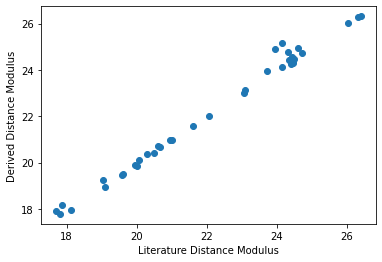

In [193]:
plt.scatter(caretta_tab['Literature Distance Modulus'], caretta_tab['Distance Modulus'])
plt.xlabel('Literature Distance Modulus')
plt.ylabel('Derived Distance Modulus');

0.06692856575989369


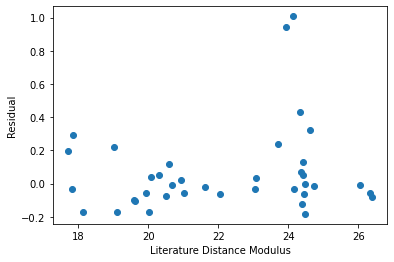

In [194]:
plt.scatter(caretta_tab['Literature Distance Modulus'], 
            caretta_tab['Distance Modulus'] - caretta_tab['Literature Distance Modulus'])
plt.xlabel('Literature Distance Modulus')
plt.ylabel('Residual');

print(abs(np.mean(caretta_tab['Distance Modulus'] - caretta_tab['Literature Distance Modulus'])))

0.1669285657598935


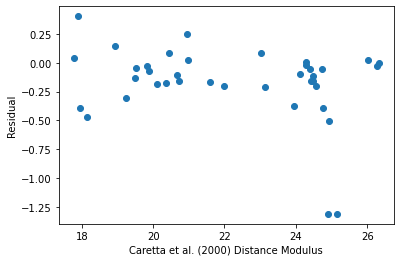

In [195]:
plt.scatter(caretta_tab['Distance Modulus'], 
            alphabetized_moduli - caretta_tab['Distance Modulus'])
plt.xlabel('Caretta et al. (2000) Distance Modulus')
plt.ylabel('Residual');

print(abs(np.mean(caretta_tab['Distance Modulus'] - alphabetized_moduli)))